#

# Import all the libraries that we will need 

In [1]:
%matplotlib inline 
import csv
import datetime
import fnmatch
import glob
import itertools
from itertools import groupby
import math
import matplotlib.cbook
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial.polynomial import polyfit
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import re
import scipy
from scipy import stats
from scipy.signal import find_peaks
import statistics
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Define acquired data path. Load other notebooks if necessary.

In [2]:
###Set the notebook screen ratio for jupyter
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:85% !important; }</style>"))

notebookPath=os.path.dirname(os.path.realpath("__file__"))
#pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_rat")
#os.chdir(pathToProcessingNotebooks)   
#%run loadRat_documentationmod.ipynb
#%run plotRat_documentation_1_GeneralBehaviormod.ipynb

#### DEFINE ROOT
#folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/datatest032021/20210426"
    #root="/home/david/Desktop/DATARUN_ANALYSIS/test0727"#new/test1203"#DATARUN ANALYSIS/all distance" #all distances" #DATARUN ANALYSIS/test0820
    savePath="/home/david/Desktop/Save"
else:
    #mac = 'Darwin'.    20210106test
    root="/Users/tom/Downloads/DATATEST/20210211"#AET-2/test1203"#Desktop/DATARUN_ANALYSIS/test0826"#" #current : test0826
    savePath="/Users/tom/Desktop/Save"#os.path.join(root,"ALLRATS","Fig")
print("Root: ", root)

retval = os.getcwd()
print("Current working directory: %s" % retval)#print("Notebook Path: ", notebookPath)
print("Save Path: ", savePath)   
print("Path to data is: %s"%root)
print("")
print("importing done")

Root:  /home/david/Desktop/datatest032021/20210426
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Path to data is: /home/david/Desktop/datatest032021/20210426

importing done


# Define a few utility functions
# + details
# columns in file from LV

In [3]:
#conversion inches to cm, sometimes needed for graphs
#check if used 
def inch2cm(value):
    return value/2.54
def cm2inch(value):
    return value*2.54
#old mostafa conversion
def px2cm(value):
    return value/11
    
#new px to cm conversion. To correct camera lens distorsion (pixels in the center of the treadmill are more precise than the ones located at the extremities), I directly applied a filter in LabView, and conversion should be uniform now, 11 px is equal to 1 cm at every point of the treadmill.
def datapx2cm(list):
    array = []
    for pos in list:
        if pos == 0:
            array.append(pos)
        elif pos > 0 and pos < 1300:
            array.append(pos/11)
        else: 
            array.append(pos)
            print("might have error in position", pos)
    return array         


#function to split lists --> used to split the raw X position array into smaller arrays (runs and stays). Later in the code we modify the array and change some values to 0, which will be used as cutting points.
def split_a_list_at_zeros(List):
    return [list(g) for k, g in groupby(List, key=lambda x:x!=0) if k]

#function to open and read from the .position files using pandas, specify the path of the file to open, the column that you want to extract from, and the extension of the file
def read_csv_pandas(path, Col=None, header=None):
    #verify that the file exists
    if not os.path.exists(path):
        print("No file %s"%path)
        return []
    try:
        #open the file
        csvData=pd.read_csv(path, header=header, delim_whitespace=True)
    except ValueError:
        print("%s not valid (usually empty)"%path)
        return []
        #verify that the column that we specified is not empty, and return the values
    if Col is not None:
        return csvData.values[:, Col[0]]
    else:
        return csvData

# FUNCTION UPDATED, COMMENT NOT UP TO DATE, BUT BASICALLY IT DOES THE SAME THING BUT BETTER. function to cut the 30min session (position plus time) into N bins of equal length, specify the data to cut (position), data template(we make the bins of a certain length so we use time), bot is where we start (usually 0, but can start later if we don't want the start), end is the end of what we want (usually the end of the session), binNumber is the number of bin that we want.
def bin_session(data_to_cut, data_template,  bot, end, bins):
    output={}
    bincount = 0
    for timebin in bins:
        #print(timebin)
        start_of_bin = timebin[0]
        end_of_bin = timebin[1]
        output[bincount] = data_to_cut[animal, session][np.logical_and(data_template[animal, session] >= start_of_bin, data_template[animal, session] < end_of_bin)]
        bincount += 1 
    return output

#Old function used before 23-02-2021 // use example : binTime[animal, session] = bin_session(rawTime, rawTime, 0, acquisitionCutOff, timeBins)
def OLDbin_session(data_to_cut, data_template,  bot, end, binNumber):
    output={}
    for count in range(0, binNumber):
        start_of_bin = count*end/binNumber
        end_of_bin = count*end/binNumber+end/binNumber
        output[count] = data_to_cut[animal, session][np.logical_and(data_template[animal, session] >= start_of_bin, data_template[animal, session] < end_of_bin)]
        #print(boot, toop, output, len(output))    
    return output

#function to read the parameters for each rat for the session in the behav.param file. Specify the name of the parameter that you want to get from the file and optionally the value type that you want. File path is not an option, maybe change that. Dataindex is in case you don't only want the last value in line, so you can choose which value you want using its index --maybe add the option to choose a range of values. 
def read_params(paramName, dataindex = -1, valueType=str):
    #define path of the file
    behav = root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".behav_param"
    #check if it exists
    if not os.path.exists(behav):
        print("No file %s" % behav)  
    #check if it is not empty
    #if os.stat(behav).st_size == 0:
        #print("File empty %s" % behav)
    #open the file
    with open(behav, "r") as f:
        #scan the file, if the name of the parameter is here, get the value 
        #scan the file
        for line in f:
            #if you look for a string do that
            if valueType is str:
                #find the line in which you have your parameter
                if paramName in line:
                    #get the last value of the line [-1], values are separated with _blanks_ with the .split() function
                    return int(line.split()[dataindex])  
                    #same if you want a float value, just convert the value
            if valueType is float: 
                if paramName in line:
                    return float(line.split()[dataindex])
            #can add other value type if needed (boolean, etc. )

#save data as pickle 
def save_as_pickle(data, animal, session, name):
    sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
    folderPath = os.path.join(sessionPath, "Analysis")
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)
    filePath = os.path.join(folderPath, name)
    pickle.dump(data, open(filePath, "wb" ))

#load data that has been pickled
def get_from_pickle(animal, session, name): # add pickle name to pick the good data
        sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
        analysisPath = os.path.join(sessionPath, "Analysis")
        picklePath = os.path.join(analysisPath, name) 
        # if not redo, and there is a pickle, try to read it
        if os.path.exists(picklePath):
            try:
                data = pickle.load(open(picklePath, "rb"))
                #print("Data loaded from %s" %picklePath)
                #print(data)
                return data
            except:
                print("error")
                pass

#function to compute speed array based on position and time arrays            
def compute_speed(dataPos, dataTime): #speed only computed along X axis. Compute along X AND Y axis?
    rawdata_speed = {}
    deltaXPos = (np.diff(dataPos))
    deltaTime = (np.diff(dataTime))
    rawdata_speed = np.divide(deltaXPos, deltaTime)
    rawdata_speed = np.append(rawdata_speed, 0)
    return rawdata_speed

# LOAD DATA
### Data is loaded in one dictionary per variable (time, position, etc.) and have [animal, session] as keys, so we have a set of data for each session of each rat
### This cell loads all the behavioral data from the files created with labview
#data in .position is as follows (as of feb 2021): 
#[0][1][2]: Step of the experiment, e.g. "Session 1 ON". Takes 3 columns because of the spaces.
#[3]: Time at which the LV iteration has been done. Depends on the acquisition frequency, clock adds 0.04s at each iteration. 
#[4]: POSITION DATA : Position on the X axis (length of the treadmill) of the animal's centroid. This position is in pixels, it needs to be converted into cm using the datapxtocm function. The conversion (11px = 1cm) has been determined in LabView as a result of a calibration to counteract the lens distorsion generated with the camera.
#[5]: Same for the position on the Y axis. 
#[6]: LICK DATA : Left hand side of the treadmill. True/1 if there is a lick False/0 if not.
#[7]: Same but Right side
#[8]: SOLENOID DATA : Same idea as just above, Left Side, but determines if the valve has been opened (might be usefull in %to get reward protocol)
#[9]: Same but Right Side valve.
#[10]: BUFFER DATA : #ID of the frame that has been analyzed by LabView in this iteration, used to check if there is acquisition bugs, difference between two consecutive frames should be == 1.
#[11]: EDITED TRACKING : True/False or 1/0 that tells wether the frame has been edited in LabView. When the animal goes too far into the sides, or when the animal rears, the tracking loses the position of the animal and places the centroid precisely at the center of the tracking area. When this happens I coded LabView to maintain the position of the centroid in the last position in which the rat was detected and resume adequate tracking when available. TLDR, eliminates the jitter when tracking is not working properly. 

# LOAD PARAMETERS
### Parameters are loaded from behav_param file for each [animal, session] in a Dict
#sessionDuration : duration of the session 
#acqPer : number of acquisition per second in labview // not used anymore (acqPer -> delta between Time value of two consecutive frames)
#waterLeft : (weight of the measuring cup + 10 drops of water - weight of the cup) --> Weight of 10 drops on the Left, in grams. divide by 10 to have weight of a drop, multiply by 1000 to have value in µL  
#waterRight : idem on right  
#weight : Weight of each rat just before the session 
#lastWeightadlib : Weight of each rat when the water bottles are removed
#lastDayadlib : Last day with ad lib water
#daysSinceadlib : compute the number of days have elapsed since "lastDayadlib"
#boundaries : initialise the boundary array, that is computed later
#bloc duration data
#probability of getting reward on each side for eeach bloc
#treadmill speed for each block

In [4]:
# initialise arrays and dicts
params = {}
extractTime, extractPositionX, extractPositionY, extractLickLeft, extractLickRight, framebuffer, solenoid_ON_Left, solenoid_ON_Right = ({} for i in range(8)) 
rawTime, rawPositionX, rawPositionY, rawLickLeft1X, rawLickRight1X, rawLickLeft1Y, rawLickRight1Y, smoothMask, rawSpeed = ({} for i in range(9)) 
binPositionX, binPositionY, binTime, binLickLeft1X, binLickRight1X = ({} for i in range(5)) 
rawLickLeft2X, rawLickRight2X = ({} for i in range(2)) 
#create the list of the animals and sessions
animalindex=1
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all sessions
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    #loop through animals and sessions
    for index, session in enumerate(sessionList):
        print("Session %s/%s: %s"%(index+1,nbSession,session), "['" +animal+ "\',\'" +session + "\']")
        #extract/compute parameters from behav_params and create a parameter dictionnary for each rat and each session
        #change of behav_param format 07/2020 -> labview ok 27/07/2020 before nOk #format behavparam ? #catchup manual up to 27/07
        params[animal, session] = {
        "sessionDuration" : read_params("sessionDuration"),
        "acqPer" : read_params("acqPer"),
        "waterLeft" : round((read_params("waterLeft", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2),
        "waterRight" : round((read_params("waterRight", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2),      
        "weight" : read_params("ratWeight"), 
        "lastWeightadlib" : read_params("ratWeightadlib"),
        "lastDayadlib" : read_params("lastDayadlib")
        } 
        #compute number of days elapsed between experiment day and removal of the water bottle
        lastDayadlib = str(datetime.datetime.strptime(str(read_params("lastDayadlib")), "%Y%m%d").date())
        match = re.search(r'\d{4}_\d{2}_\d{2}', session)
        experimentDay = str(datetime.datetime.strptime(match.group(), '%Y_%m_%d').date())
        daysSinceadlib = datetime.date(int(experimentDay[0:4]), int(experimentDay[5:7]), int(experimentDay[8:10]))-datetime.date(int(lastDayadlib[0:4]), int(lastDayadlib[5:7]), int(lastDayadlib[8:10]))
        params[animal, session]["daysSinceadLib"] = daysSinceadlib.days
        #initialize boundaries to be computed later using the KDE function
        params[animal, session]["boundaries"] = []

        #determine block duration set based on the block timing defined in labview. 1 block in labview is comprised of a ON period and a OFF period. Max 12 blocks in LabView (12 On + 12 Off)*repeat.
        blocklist = []# raw blocks from LabView -> 1 block (ON+OFF) + etc
        for blockN in range(1,13): #13? or more ? Max 12 blocks, hardcoded in LabView...
            #add block if  block >0 seconds then get data from file. 
            #Data from behav_params as follows: Block N°: // ON block Duration // OFF block duration // Repeat block // % reward ON // % reward OFF // Treadmill speed.
            if read_params("Block "+ str(blockN), dataindex =  -6, valueType = str) != 0:
                blocklist.append([read_params("Block "+ str(blockN), dataindex =  -6, valueType = str), read_params("Block "+ str(blockN), dataindex =  -5, valueType = str), read_params("Block "+ str(blockN), dataindex =  -4, valueType = str), read_params("Block "+ str(blockN), dataindex =  -3, valueType = str), read_params("Block "+ str(blockN), dataindex =  -2, valueType = str), read_params("Block "+ str(blockN), dataindex =  -1, valueType = str), blockN])
        #create an array [start_block, end_block] for each block using the values we have just read -> 1 block ON + 1 bloc OFF + etc.
        timecount, blockON_start, blockON_end, blockOFF_start, blockOFF_end = 0, 0, 0, 0, 0
        blocks = [] #blocks that we are going to use in the data processing. 1 block ON + 1 bloc OFF + etc.
        rewardP_ON = [] #probability of getting the reward in each ON phase 
        rewardP_OFF = [] #same for OFF
        treadmillSpeed = [] #treadmill speed for each block (ON + OFF blocks not differenciated for now)
        for block in blocklist:
            for repeat in range(0, block[2]): #in essence blocks = [a, b], [b, c], [c, d], ...
                #print(block)
                blockON_start = timecount
                timecount += block[0]
                blockON_end = timecount
                blockOFF_start = timecount
                timecount += block[1]
                blockOFF_end = timecount
                blocks.append([blockON_start, blockON_end])
                blocks.append([blockOFF_start, blockOFF_end])
                rewardP_ON.append(block[3])
                rewardP_OFF.append(block[4])
                treadmillSpeed.append(block[5])
        params[animal, session]["blocks"], params[animal, session]["rewardP_ON"], params[animal, session]["rewardP_OFF"], params[animal, session]["treadmillSpeed"] = blocks, rewardP_ON, rewardP_OFF, treadmillSpeed

        #Extract data for each .position file generated from LabView
        #Data loaded : time array, position of the animal X and Y axis, Licks to the left and to the right, and frame number
        extractTime[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[3])#old format = 5
        extractPositionX[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[4])#old format = 6
        extractPositionY[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[5])
        extractLickLeft[animal, session]  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[6])
        extractLickRight[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[7])
        solenoid_ON_Left[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[8])
        solenoid_ON_Right[animal, session]= read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[9])
        framebuffer[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[10])

        #Cut leftover data at the end of the session (e.g. session is 1800s long, data goes up to 1820s because session has not been stopped properly/stopped manually, so we remove the extra 20s)
        rawTime[animal, session]       = extractTime[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawPositionX[animal, session]  = extractPositionX[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawPositionY[animal, session]  = extractPositionY[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickLeft1X[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickLeft1Y[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]# not needed, check
        rawLickRight1X[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickRight1Y[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]#
        # Get lick data. 
        #Old data format:
        #if all lick values < 2 do old version #old version lick is preprocessed in labview and only outputs if licked (1 or True) or not licked (0 or False), so values always < 2. Now we want the true value that is detected by the lickometer for better data management, so value is >2.
        # Data is array of TRUE and FALSE values. Convert the FALSE values to 0. Convert TRUE to the position of the rat at this instant to be able to plot them (position at which the animal licked)
        if np.all([(abs(l) == 1 or abs(l) == 0) for l in rawLickLeft1X[animal, session]]):
            #print("old lick dataL (before 04-2021")
            rawLickLeft1X[animal, session][rawLickLeft1X[animal, session]==False] = 0  
            rawLickLeft1X[animal, session][rawLickLeft1X[animal, session]==True] = rawPositionX[animal, session][rawLickLeft1X[animal, session]==True]
            rawLickLeft1Y[animal, session][rawLickLeft1Y[animal, session]==False] = 0
            rawLickLeft1Y[animal, session][rawLickLeft1Y[animal, session]==True] = rawPositionY[animal, session][rawLickLeft1Y[animal, session]==True]
        if np.all([(abs(l) == 1 or abs(l) == 0) for l in rawLickRight1X[animal, session]]):
            #print("old lick dataR (before 04-2021") 
            rawLickRight1X[animal, session][rawLickRight1X[animal, session]==False] = 0
            rawLickRight1X[animal, session][rawLickRight1X[animal, session]==True] = rawPositionX[animal, session][rawLickRight1X[animal, session]==True]
            rawLickRight1Y[animal, session][rawLickRight1Y[animal, session]==False] = 0
            rawLickRight1Y[animal, session][rawLickRight1Y[animal, session]==True] = rawPositionY[animal, session][rawLickRight1Y[animal, session]==True]

        #new lick data format (04-2021):
        #"""
        #lick data is capacitance of lickometer, so way above 0 and 1 so if we have one lickval > 2 convert all values to True/False or 0/1 to be able to use the rest of the code as before. The difference is that we can define the lickthreshold post hoc for each side, so if there are differences in lickometer sensitivity (happens once in a while) during a session we don't loose all/chunk of lick data. 
        lickthresholdLeft = 300
        lickthresholdRight = 300
        if np.any([abs(l) > lickthresholdLeft for l in rawLickLeft1X[animal, session]]):
            #print("new lick dataL")
            rawLickLeft1X[animal, session][rawLickLeft1X[animal, session] < lickthresholdLeft] = 0 
            rawLickLeft1X[animal, session][rawLickLeft1X[animal, session] >= lickthresholdLeft] = rawPositionX[animal, session][rawLickLeft1X[animal, session] >= lickthresholdLeft]
            rawLickLeft1Y[animal, session][rawLickLeft1Y[animal, session] < lickthresholdLeft] = 0
            rawLickLeft1Y[animal, session][rawLickLeft1Y[animal, session] >= lickthresholdLeft] = rawPositionY[animal, session][rawLickLeft1Y[animal, session] >= lickthresholdLeft]

        if np.any([abs(l) > lickthresholdRight for l in rawLickRight1X[animal, session]]):
            #print("new lick dataR")  
            rawLickRight1X[animal, session][rawLickRight1X[animal, session] < lickthresholdRight] = 0
            rawLickRight1X[animal, session][rawLickRight1X[animal, session] >= lickthresholdRight] = rawPositionX[animal, session][rawLickRight1X[animal, session] >= lickthresholdRight]
            rawLickRight1Y[animal, session][rawLickRight1Y[animal, session] < lickthresholdRight] = 0
            rawLickRight1Y[animal, session][rawLickRight1Y[animal, session] >= lickthresholdRight] = rawPositionY[animal, session][rawLickRight1Y[animal, session] >= lickthresholdRight]
        #"""
        #Cut the data (time, posision, licks) in time bins following the blocks timing that we computed above.
        binTime[animal, session] = bin_session(rawTime, rawTime, blocks[0][0], blocks[-1][1], blocks) ### verify that this works and that we don't need to get this data from the params dict. Should look like something like that: params[animal, session]["blocks"][0][0], params[animal, session]["blocks"][-1][1], params[animal, session]["blocks"]
        binPositionX[animal, session] = bin_session(rawPositionX, rawTime, blocks[0][0], blocks[-1][1], blocks)
        binPositionY[animal, session] = bin_session(rawPositionY, rawTime, blocks[0][0], blocks[-1][1], blocks)
        binLickLeft1X[animal, session] = bin_session(rawLickLeft1X, rawTime, blocks[0][0], blocks[-1][1], blocks)
        binLickRight1X[animal, session] = bin_session(rawLickRight1X, rawTime, blocks[0][0], blocks[-1][1], blocks) 

        #Transform from px to cm -- camera lens distorsion is managed directly in labview
        rawPositionX[animal, session], rawPositionY[animal, session], rawLickLeft1X[animal, session], rawLickRight1X[animal, session] = datapx2cm(rawPositionX[animal, session]), datapx2cm(rawPositionY[animal, session]), datapx2cm(rawLickLeft1X[animal, session]), datapx2cm(rawLickRight1X[animal, session])
        #Idem for the time bins data
        for i in range(0, len(blocks)):
            binPositionX[animal, session][i] = datapx2cm(binPositionX[animal, session][i])
            binPositionY[animal, session][i] = datapx2cm(binPositionY[animal, session][i])
            binLickLeft1X[animal, session][i] = datapx2cm(binLickLeft1X[animal, session][i])
            binLickRight1X[animal, session][i] = datapx2cm(binLickRight1X[animal, session][i])
        rawSpeed[animal, session] = compute_speed(rawPositionX[animal, session], rawTime[animal, session])
        smoothMask[animal,session] = np.array([True])
        print(animal, "Data loaded")
        print()   
#clear_output()

Animal RatF00
1 out of 1
**********
Session 1/1: RatF00_2021_04_26_13_23_30 ['RatF00','RatF00_2021_04_26_13_23_30']
RatF00 Data loaded



In [5]:
#TODO#para
solenoid_ON_Left[animal, session][0:100]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 4.8, 4.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [6]:
params[animal, session]

{'sessionDuration': 3600,
 'acqPer': 25,
 'waterLeft': 13.9,
 'waterRight': 11.9,
 'weight': 240,
 'lastWeightadlib': 300,
 'lastDayadlib': 20210322,
 'daysSinceadLib': 35,
 'boundaries': [],
 'blocks': [[0, 300],
  [300, 600],
  [600, 900],
  [900, 1200],
  [1200, 1500],
  [1500, 1800],
  [1800, 2100],
  [2100, 2400],
  [2400, 2700],
  [2700, 3000],
  [3000, 3300],
  [3300, 3600]],
 'rewardP_ON': [90, 90, 90, 90, 90, 90],
 'rewardP_OFF': [10, 10, 10, 10, 10, 10],
 'treadmillSpeed': [0, 0, 0, 0, 0, 0]}

In [7]:
#test ok, do that in function of bin (% not the same)
test= split_a_list_at_zeros(solenoid_ON_Left[animal, session])
test2= split_a_list_at_zeros(solenoid_ON_Right[animal, session])

In [8]:
#for t in test2:
    #print(t[0])

In [9]:
sum([1 if t[0] <= params[animal, session]["rewardP_ON"][0] else 0 for t in test])

224

In [10]:
sum([1 if t[0] <= params[animal, session]["rewardP_ON"][0] else 0 for t in test2])

216

RatF00_2021_04_26_13_23_30
[2 1 1 ... 1 1 1]
12 // 90031



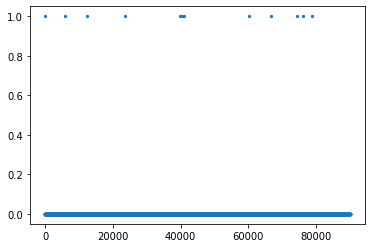

In [11]:
#check visually if there is some acquisition bugs
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.gca()
        print(session)
        print(np.diff(framebuffer[animal, session]))
        a = sum(np.diff(framebuffer[animal, session])-1)
        print(a, "//", len(framebuffer[animal, session]))
        #print([i + framebuffer[animal, session][0] for i, e in enumerate(np.diff(framebuffer[animal, session])) if e == 0])
        #print([i + framebuffer[animal, session][0] for i, e in enumerate(np.diff(framebuffer[animal, session])) if e != 1])
        #print([e for i, e in enumerate(np.diff(framebuffer[animal, session])) if e != 1])
        print()
        plt.scatter(list(range(1, len(framebuffer[animal, session]))), [ x-1 for x in np.diff(framebuffer[animal, session])], s=5)
        plt.show()

In [12]:
buggedRatSessions = ["", ""] #exclude bugged rat sessions (e.g. labview crash) from otherwise ok session
lickBug = ["Rat000 Rat000_2020_08_22_19_07_01", ""] #put complete list of invalid lick sessions, only analyze runs

#discard completely specified bugged sessions
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        if animal + " " + session in buggedRatSessions:
            print("Rat Session %s discarded"%session)
            animalList.remove(animal)
            #sessionList.remove(session)
            print(animalList,"removed session: ", sessionList)
            print()
#Specify if a session has lick data problems, so we don't discard the whole session (keep the run behavior, remove lick data)     
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        if all(v == 0 for v in rawLickLeft1X[animal, session]):
            params[animal, session]["hasLick"] = False
        elif all(v == 0 for v in rawLickRight1X[animal, session]):
            params[animal, session]["hasLick"] = False       
        elif animal + " " + session in lickBug:
            params[animal, session]["hasLick"] = False
        else:
            params[animal, session]["hasLick"] = True
        print("Lick data for this session: ", animal, params[animal, session]["hasLick"])

Lick data for this session:  RatF00 True


# Water data
### Compute drop size for each reward port. Determine if drops are equal, or which one is bigger. Assign properties (e.g. line width for plots) accordingly.
### Two next boxes could easily be integrated in the general params dict, not sure for understandability.

In [13]:
water={}
water[animal, session] = {}
#print(round(params[animal, session]["waterLeft"], 1), "µL/drop")
#print(round(params[animal, session]["waterRight"], 1), "µL/drop")
limitWater_diff = 5 #in%, if waterRight > waterLeft + X% or waterRight < waterLeft - X% we consider that Left is different from Right, maybe try 5% #modify that, 5% in a big drop is more than 5% in a small drop 

for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        watL = round(params[animal, session]["waterLeft"], 1)
        watR = round(params[animal, session]["waterRight"], 1)
        print(session)
        if watL-(watL*limitWater_diff/100) <= watR <= watL+(watL*limitWater_diff/100):
            print(watL, watR, "     same L-R")
            #print(watL-(watL*limitWater_diff/100))
            #print(watL+(watL*limitWater_diff/100))
            water[animal, session] = ["Same Reward Size", "Same Reward Size", 2, 2]
        elif watL < watR:
            print(watL, watR, "     bigR")
            water[animal, session] = ["Small Reward", "Big Reward", 1, 5]
        elif watL > watR:
            print(watL, watR, "     bigL")
            water[animal, session] = ["Big Reward", "Small Reward", 5, 1]
        else:
            print("error, bypass? Y/N")

RatF00_2021_04_26_13_23_30
13.9 11.9      bigL


# Create rat markers
### Define a marker (male, female) and a color for each rat (plots are prettier)

In [14]:
rat_markers={}
rat_markers[animal] = {}
#OLD palette = ['r', 'm', 'y', 'c', 'r', 'm', 'y', 'c']
palette = ['darkred', 'indianred', 'orangered', 'tomato', 'darkgreen', 'forestgreen', 'limegreen', 'chartreuse']
index = 0
for animal in animalList:
    # if the animal is F use Female symbol and 1 color per F rat
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[palette[index], "$\u2640$"]
        index+=1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        #same for males
        rat_markers[animal]=[palette[index], "$\u2642$"]
        index+=1  
        #if rat is not F or M (Rat000) use black and ? 
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[palette[index], "$\u2426$"]
        index+=1 
    else:
        print("error, bypass? Y/N")
        answer = input()
        if answer== 'Y':
            rat_markers[animal]= ['k',"$\u2426$"] 
        else:
            print("do nothing")

In [15]:
print(params)

{('RatF00', 'RatF00_2021_04_26_13_23_30'): {'sessionDuration': 3600, 'acqPer': 25, 'waterLeft': 13.9, 'waterRight': 11.9, 'weight': 240, 'lastWeightadlib': 300, 'lastDayadlib': 20210322, 'daysSinceadLib': 35, 'boundaries': [], 'blocks': [[0, 300], [300, 600], [600, 900], [900, 1200], [1200, 1500], [1500, 1800], [1800, 2100], [2100, 2400], [2400, 2700], [2700, 3000], [3000, 3300], [3300, 3600]], 'rewardP_ON': [90, 90, 90, 90, 90, 90], 'rewardP_OFF': [10, 10, 10, 10, 10, 10], 'treadmillSpeed': [0, 0, 0, 0, 0, 0], 'hasLick': True}}


# BASE TRAJECTORY
### This first part is about plotting the trajectory+licks of the animals along the X axis.

In [16]:
# This function plots the base trajectory of the rat. Parameters are time : time data, position : X position data, lickL/R, lick data, maxminstep for x and y axis, color and marker of the plot, width of the axis, and x y labels
def plot_BASEtrajectory(time, position, lickLeft, lickRight, maxminstep, maxminstep2, color = [], marker = [], linewidth = [], xyLabels=["N","Bins"]):   
        #select data that we want to plot
        plt.plot(time, position, color=color[0], marker=marker[0], linewidth = linewidth[0])#easy time againt position of the animal
        plt.plot(time, [None if x == 0 else x for x in lickLeft], color=color[1], marker=marker[1], markersize = marker[2])#lick data, plot position in which the animal licked, NoLick = we don't care so None
        plt.plot(time, [None if x == 0 else x for x in lickRight], color=color[1], marker=marker[1], markersize = marker[2])
        #configure plot
        ax0 = plt.gca()
        #configure ax xy span
        ax0.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
        ax0.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
        #configure xy style
        ax0.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
        ax0.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
        ax0.xaxis.set_ticks_position('bottom')
        ax0.yaxis.set_ticks_position('left')
        ax0.get_xaxis().set_tick_params(direction='out',pad=2)
        ax0.get_yaxis().set_tick_params(direction='out',pad=2)
        #remove unnecessary axes
        ax0.spines['top'].set_color("none")
        ax0.spines['right'].set_color("none")
        return ax0

In [17]:
# Function to compute start of run and end of run boundaries
# animals lick in the extremities, so they spend more time there, so probability of them being there is more important than the probability of being in the middle of the apparatus. we compute the two average positions of these resting points. We defined a run as the trajectory of the animal between the resting points. So we have to find these resting points. In later stages of the experiments the start/end of runs is defined based on the speed of the animals. 
# function params : data is X position array for the session that we analyse, height = parameter to define a limit to the probability of detecting a place as significantly more probable than another.
#We use a KDE (Kernel Density Estimate) to find said places. See testhitopeak.ipynb 2nd method for histogram. histogram is coded in next cell between """ """, but does not work on linux
def extract_boundaries(data, animal, session, height = None):
    kde = stats.gaussian_kde(data)
    #compute KDE = get the position probability curve and compute peaks of the curve
    peak_pos, peak_height = [], []
    nb_samples = 120 #played a bit with the values, this works (number of data bins, we chose 1 per cm, also tested 10 bins per cm)
    samples = np.linspace(0, 120, nb_samples)
    probs = kde.evaluate(samples)
    maxima_index = find_peaks(probs, height) 
    peak_pos = maxima_index[0]
    peak_height = maxima_index[1]["peak_heights"]
    #print("values", peak_pos, peak_height)
    # if there is more than two peaks (e.g. an animal decides to stay in the middle of the treadmill), only keep the two biggest peaks (should be the extremities) and remove the extra peak/s if there is one or more
    while len(peak_height)>2:
        peak_pos = np.delete(peak_pos, np.argmin(peak_height))
        peak_height = np.delete(peak_height, np.argmin(peak_height))
        continue   
    if len(peak_height) == 2:
        leftBoundaryPeak = peak_pos[0]
        rightBoundaryPeak = peak_pos[1]
        print("computing ok", animal, leftBoundaryPeak, rightBoundaryPeak)
    return leftBoundaryPeak, rightBoundaryPeak, kde

# this function plots the peak that we just extracted
def plot_peak(data, animal, session, leftBoundaryPeak, rightBoundaryPeak, kde, maxminstep, maxminstep2, marker = [], xyLabels=["N","Bins"]):
    #fig, ax = plt.subplots(figsize=(3,6))
    bins = np.arange(120)
    xx = np.linspace(0, 120, 120)
    xline1 = [leftBoundaryPeak, leftBoundaryPeak]
    xline2 = [rightBoundaryPeak, rightBoundaryPeak]
    yline = [0, 0.01]

    if platform.system()== 'Darwin':
        ax7.hist(data, normed=True, bins=bins, alpha=0.3, orientation='horizontal') #bugged on linux, working on mac
    #plot kde + boundaries
    ax7.plot(kde(xx), xx, color = 'r')
    ax7.plot(yline, xline1, ":", color='k')
    ax7.plot(yline, xline2, ":", color='k')
    ax7.plot(yline, [xline1[0]+border, xline1[0]+border], ":", color='k', alpha = 0.5)
    ax7.plot(yline, [xline2[0]-border, xline2[0]-border], ":", color='k', alpha = 0.5)
    #configure plot
    ax7.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax7.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
    ax7.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    ax7.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    ax7.spines['top'].set_color("none")
    ax7.spines['left'].set_color("none")
    ax7.spines['right'].set_color("none")
    ax7.yaxis.set_ticks_position('left')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.get_xaxis().set_tick_params(direction='out',pad=2)
    ax7.get_yaxis().set_tick_params(direction='out',pad=2)
    ax7.axes.get_yaxis().set_visible(False)
    return ax7

In [18]:
#Use previously defined functions to compute the boundaries and store them in params. Result is saved as pickle. 
redoBoundKDE = False #redo computation YES/NO
leftBoundaryPeak = {}
rightBoundaryPeak = {}
kde = {}
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        #Avoid recomputing KDE (quite long) so fetch pickle file if already there
        picklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"boundaries.p"
        if os.path.exists(picklePath) and (not redoBoundKDE):
            params[animal, session]["boundaries"] = get_from_pickle(animal, session, name="boundaries.p")
        else:
            border = 5 #define arbitrary border
            leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session]= extract_boundaries(rawPositionX[animal, session], animal, session, height = 0.001)
            params[animal, session]["boundaries"] = [rightBoundaryPeak[animal, session] - border, leftBoundaryPeak[animal, session] + border]
            #params[animal, session]["boundaries"] = [800, 200]
            save_as_pickle(params[animal, session]["boundaries"], animal, session, "boundaries.p")
"""
#problem leftBoundaryPEak, rightBoundaryPeak and kde are not created if we read the information from params
        print("plotting", animal)
        fig = plt.figure(constrained_layout=True, figsize=(21,6))
        fig.suptitle(animal + " " + session)
        widths = [3, 18]
        heights = [6]
        rows = 1
        cols = 2

        spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
        index =0
        for row in range(rows):
            for col in range(cols):
                ax = fig.add_subplot(spec[row, col])
                
                if index == 0:
                    plot_peak(rawPositionX[animal, session], animal, session, leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session],[0.05, 0, 0],[0,120,0],  marker = [""], xyLabels=["Position (px)", "%"])
                    index+=1
                    
                elif index == 1:
                    plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft1X[animal, session], rawLickRight1X[animal, session], [0, read_params("sessionDuration"), 1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (px)", "Time(s)"])
                    index+=1
"""

'\n#problem leftBoundaryPEak, rightBoundaryPeak and kde are not created if we read the information from params\n        print("plotting", animal)\n        fig = plt.figure(constrained_layout=True, figsize=(21,6))\n        fig.suptitle(animal + " " + session)\n        widths = [3, 18]\n        heights = [6]\n        rows = 1\n        cols = 2\n\n        spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)\n        index =0\n        for row in range(rows):\n            for col in range(cols):\n                ax = fig.add_subplot(spec[row, col])\n                \n                if index == 0:\n                    plot_peak(rawPositionX[animal, session], animal, session, leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session],[0.05, 0, 0],[0,120,0],  marker = [""], xyLabels=["Position (px)", "%"])\n                    index+=1\n                    \n                elif index == 1:\n                    plot_BASEt

In [19]:
#there in case of KDE bug --> boundaries wrong, manually specify them to check the data 
if animal + " " + session in ["Rat000 Rat000_2020_08_22_19_07_01"]:
    params[animal, session]["boundaries"] = [700, 300]

<Figure size 1440x360 with 0 Axes>

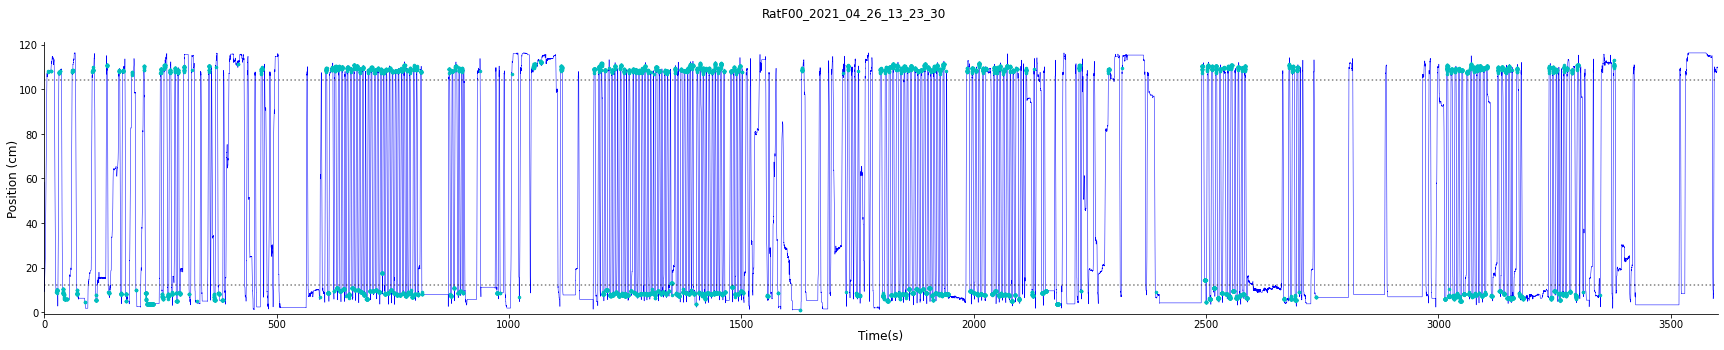

In [20]:
#Plot trajectory of each animal
#position in cm in blue line, lick at each side in cyan dots, computed boundary in dotted line
plt.figure(figsize = [20, 5])
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.figure(figsize = [30, 5])
        plt.suptitle(session)
        plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft1X[animal, session], rawLickRight1X[animal, session], [0, read_params("sessionDuration"),1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 2.5], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
        plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]], ":", color='k', alpha = 0.5)
        plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]], ":", color='k', alpha = 0.5)

# Extract Runs and Stays 
### Separate each run and each stay from the raw data and place them in different arrays. 1st pass to get all_data and compute mean of all data, 2nd pass to differentiate between good and bad items (bad if 2 StDev for mean computed in 1st pass) 
### We extract the duration of the run/stay, and the array of positions and time for each run/stay
### We differentiate between stays in the left/right and runs to the left/to the right

In [21]:
#old function to separate runs and stays#def extract_runsRightLeftFiltered(dataPos, dataTime, dataLickR, dataLickL, animal, session, boundary, limspeed, hasLick):
def extract_runSpeed(dataPos, dataSpeed, dataTime, dataLickR, dataLickL, mask, animal, session, boundary, limspeed, hasLick):
    rawdata_run = {}
    rawdata_stay = {}
    data = {}
    runs = {}
    stays = {}
    goodPos, badPos = [], []
    goodSpeed, badSpeed = [], []
    goodTime, badTime = [], []

    good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft = ([] for i in range(6)) 
    bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight, bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft = ([] for i in range(6)) 
    all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft = ([] for i in range(4)) 

    good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft = ([] for i in range(6)) 
    bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft = ([] for i in range(6)) 
    all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft = ([] for i in range(4)) 

    lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ([] for i in range(6)) 
    good_instantSpeedRight, bad_instantSpeedRight, all_instantSpeedRight, good_instantSpeedLeft, bad_instantSpeedLeft, all_instantSpeedLeft = ([] for i in range(6))
    good_maxSpeedRight, bad_maxSpeedRight, all_maxSpeedRight, good_maxSpeedLeft, bad_maxSpeedLeft, all_maxSpeedLeft = ([] for i in range(6))

    #crop the complete track at the set boundaries -> keep only the runs and set the rest to 0
    rawdata_run[animal, session] = [[e[0], e[1]] if e[0] <= boundary[0] and e[0]>= boundary[1] else 0 for e in [[i , j] for i, j in zip(dataPos[animal, session],dataTime[animal, session])]]
    # use the split a list function to create a new sublist when there is a 0, which we just set up before
    for run in split_a_list_at_zeros(rawdata_run[animal, session]):
        #calculate distance run as the distance between first and last value
        distanceRun = abs(run[0][0]-run[-1][0])
        #calculate time as sum of time interval between frames
        totaltimeRun = []
        xTrackRun = []
        for item in run:
            xTrackRun.append(item[0])
            totaltimeRun.append(item[1])
        speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
        #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
        if run[0][0] < ((boundary[0]+boundary[1])/2):
            #check if the subsplit is ending on the other side -> determine if this is a run 
            if run[-1][0] > ((boundary[0]+boundary[1])/2):
                #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                #second pass : there is a computed limspeed, use it to sort good and bad runs
                if limspeed[0] is not None:
                    #check if this is a good or bad run and assign im to the good or bad array accordingly
                    if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]:
                        #good run array
                        good_speedRunToRight.append(speedRun)
                        good_XtrackRunToRight.append(xTrackRun)
                        good_timeRunToRight.append(totaltimeRun)   
                    else:
                        #bad run array
                        bad_speedRunToRight.append(speedRun)
                        bad_XtrackRunToRight.append(xTrackRun)
                        bad_timeRunToRight.append(totaltimeRun)
                else:
                    #all runs array first pass
                    all_speedRunToRight.append(speedRun)
                    all_timeRunToRight.append(totaltimeRun)

        #same thing for the runs that go to the other side
        elif run[0][0]>((boundary[0]+boundary[1])/2):
            if run[-1][0]<((boundary[0]+boundary[1])/2):
                if limspeed[1] is not None:
                    if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                        good_speedRunToLeft.append(speedRun)   
                        good_XtrackRunToLeft.append(xTrackRun)
                        good_timeRunToLeft.append(totaltimeRun)
                    else:
                        bad_speedRunToLeft.append(speedRun)
                        bad_XtrackRunToLeft.append(xTrackRun)
                        bad_timeRunToLeft.append(totaltimeRun)
                else:
                    all_speedRunToLeft.append(speedRun)
                    all_timeRunToLeft.append(totaltimeRun)

    # inverse crop, at the boundaries keep the distal parts, same process as above
    #same principle as packing time and position together
    # stay : 0=position, 1=time, 2=lickright, 3=lickleft
    rawdata_stay[animal, session]= [[e[0], e[1], e[2], e[3]] if e[0] >= boundary[0] or e[0] <= boundary[1] else 0 for e in [[i, j, k, l] for i, j, k, l in zip(dataPos[animal, session], dataTime[animal, session], dataLickR[animal, session], dataLickL[animal, session])]]

    for stay in split_a_list_at_zeros(rawdata_stay[animal, session]):
        tInZone = []
        xTrackStay = []
        lickR = []
        lickL = []
        for item in stay:
            xTrackStay.append(item[0])
            tInZone.append(item[1])
            lickR.append(item[2])
            lickL.append(item[3])
        totaltimeStay = np.sum(np.diff(tInZone))
        #first identify if the subsplit created is on the left or right by comparing to the middle
        if stay[0][0] > ((boundary[0]+boundary[1]) / 2):
            if hasLick == True: #put hasLick as a param
                #if no lick put in bad stay
                if not all(v == 0 for v in lickR):
                    #bad_timeStayInRight.append(totaltimeStay)
                    #bad_XtrackStayInRight.append(xTrackStay)
                    #bad_TtrackStayInRight.append(tInZone)
                    #continue
                    pre = []
                    drink = []
                    post = []
                    for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                        pre.append(t)
                    for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                        drink.append(t)
                    for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                        post.append(t)
                    
                    #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)
                    lick_arrivalRight.append(np.sum(np.diff(pre)))
                    lick_drinkingRight.append(np.sum(np.diff(drink)))
                    lick_waitRight.append(np.sum(np.diff(post)))

            if limspeed[0] is not None:
                if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:
                    good_timeStayInRight.append(totaltimeStay)
                    good_XtrackStayInRight.append(xTrackStay)
                    good_TtrackStayInRight.append(tInZone)
                else:
                    bad_timeStayInRight.append(totaltimeStay)
                    bad_XtrackStayInRight.append(xTrackStay)
                    bad_TtrackStayInRight.append(tInZone)
            else:
                all_timeStayInRight.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)
      
        elif stay[0][0] < ((boundary[0] + boundary[1]) / 2):
            if hasLick == True:
                if not all(v == 0 for v in lickL):
                    #bad_timeStayInLeft.append(totaltimeStay)
                    #bad_XtrackStayInLeft.append(xTrackStay)
                    #bad_TtrackStayInLeft.append(tInZone)
                    #continue
                    preL = []
                    drinkL = []
                    postL = []
                    for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                        preL.append(t)
                    for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                        drinkL.append(t)
                    for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                        postL.append(t)

                    lick_arrivalLeft.append(np.sum(np.diff(preL)))
                    lick_drinkingLeft.append(np.sum(np.diff(drinkL)))
                    lick_waitLeft.append(np.sum(np.diff(postL)))

            if limspeed[1] is not None:
                if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:
                    good_timeStayInLeft.append(totaltimeStay)   
                    good_XtrackStayInLeft.append(xTrackStay)
                    good_TtrackStayInLeft.append(tInZone)
                else:
                    bad_timeStayInLeft.append(totaltimeStay)
                    bad_XtrackStayInLeft.append(xTrackStay)
                    bad_TtrackStayInLeft.append(tInZone)
            else:
                all_timeStayInLeft.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)

    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

    #old output order#return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight, bad_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

# Stats function
### basic stats, check if distrib is normal, then see if difference between two means

In [22]:
def statsrun(dataRight, dataLeft, animal):
    #define sitistical significance threshold
    sig_threshold = 0.05
    #compute average of speeds
    average_semToRight = [np.mean(dataRight), scipy.stats.sem(dataRight), np.median(dataRight)]
    average_semToLeft = [np.mean(dataLeft), scipy.stats.sem(dataLeft), np.median(dataLeft)]
    #check if the sample is from a normal distribution 
    #normaltest, if p<0.05, reject null hypothesis that sample comes from a normal distribution
    normalToRight = scipy.stats.normaltest(dataRight)
    normalToLeft = scipy.stats.normaltest(dataLeft)

    #check if the two samples that we are comparing are from a normal distribution; if they both are perform a ttest, if at least one of them is not do a mannwhitney 
    if normalToLeft[1] > sig_threshold and normalToRight[1] > sig_threshold:
        #stat from ttest
        statValue = [scipy.stats.ttest_ind(dataRight, dataLeft)[1], "Ttest"]
    else: 
        #stat from mannwhitney
        statValue = [scipy.stats.mannwhitneyu(dataRight, dataLeft)[1], "MannWhitney"]

    #if the stat value (ttest or mannwhitney) is below statistical signifiance threshold show big arrow to the side they go the faster, print a *, else not
    #if statValue[0] > sig_threshold:
    #    print("----------->", "\t", "<-----------")
    #else:
    #    if average_semToRight[0] > average_semToLeft[0]:
    #        print("=>=>=>=>=>=>", "\t", "<-----------")
    #    else:
    #        print("----------->", "\t", "<=<=<=<=<=<=")

    #fnmatch.fnmatch(animal, 'RatF*')
    #print and format the results
    return "R "+"%.2f" % average_semToRight[0] + " \u00B1 " + "%.2f" % average_semToRight[1] + "   " +"L "+"%.2f" % average_semToLeft[0]+" \u00B1 "+"%.2f" % average_semToLeft[1]+"     median R-L "+"%.2f" % average_semToRight[2]+"-"+"%.2f" % average_semToLeft[2] + "   " + "%.3f" % statValue[0] + (" " if statValue[0] > sig_threshold else "*") + statValue[1]

# plotting functions


In [23]:
#function to plot the tracks of each runs and stays
def plot_tracks(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, index, bounds, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1 ): 
    ax = plt.gca()
    for i, j in zip(good_PosdataRight, good_TimedataRight):
        plt.plot(np.subtract(j, j[0]), i, color='g' , linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] and index ==0 else "")
    for k, l in zip(bad_PosdataRight, bad_TimedataRight):
        plt.plot(np.subtract(l, l[0]), k, color='r', linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] and index == 0 else "")
    ax.set_title(title[0], fontsize = title[1])
    ax.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    ax.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    xline1 = [bounds[0], bounds[0]]
    xline2 = [bounds[1], bounds[1]]
    yline = [0,20]
    plt.plot(yline, xline1, ":", color='k')
    plt.plot(yline, xline2, ":", color='k')
    if index == 0:
        ax.legend()
    return ax

#function to plot the cumulative distribution of the run speeds and stay times        
def cumul_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, xyLabels=["","","",""], title=[None], linewidth = 1):      
    ax1 = plt.gca()
    custom_legend = [Line2D([0], [0], color ='g', lw=legend[3]), Line2D([0], [0], color ='g', lw=legend[2])]
    plt.hist(gooddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataRight)/float(len(gooddataRight + baddataRight)), color ='g', histtype = 'step', cumulative = True, linewidth = legend[3])
    plt.hist(gooddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataLeft)/float(len(gooddataLeft + baddataLeft)), color ='g', histtype = 'step', cumulative = True, linewidth = legend[2])
    plt.hist(baddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(baddataRight)/float(len(gooddataRight + baddataRight)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[3])
    plt.hist(baddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(baddataLeft)/float(len(gooddataLeft + baddataLeft)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[2])
    #plt.hist(gooddataRight + baddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataRight + baddataRight)/float(len(gooddataRight + baddataRight)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[3])
    #plt.hist(gooddataLeft + baddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataLeft + baddataLeft)/float(len(gooddataRight + baddataRight)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[2])
    ax1.set_title(title[0], fontsize = title[1], pad=50)
    ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    ax1.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize = xyLabels[2]) 
    plt.tight_layout(pad=0.5)
    ax1.legend(custom_legend, [legend[0], legend[1]], bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    return ax1

#function to plot the scatter data of run times and stay times
def distribution_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, xyLabels=["","","",""], title=[None], linewidth = 1):
    ax2 = plt.gca()
    plt.scatter(np.random.normal(1, 0.05, len(gooddataRight)), gooddataRight, s=20, color = 'g', marker = "$\u25ba$", label=legend[0])
    plt.scatter(np.random.normal(2, 0.05, len(gooddataLeft)), gooddataLeft, s=20, color = 'g', marker = "$\u25c4$", label=legend[1])
    plt.scatter(np.random.normal(1, 0.05, len(baddataRight)), baddataRight, s=20, color = 'r', alpha = 0.2, marker = "$\u25ba$", label=legend[2])
    plt.scatter(np.random.normal(2, 0.05, len(baddataLeft)), baddataLeft, s=20, color = 'r', alpha = 0.2, marker = "$\u25c4$", label=legend[3])
    plt.scatter(1.2, np.mean(gooddataRight), s=25, color = 'g')
    plt.scatter(2.2, np.mean(gooddataLeft), s=25, color = 'g')
    plt.boxplot(gooddataRight, positions = [1.35])
    plt.boxplot(gooddataLeft, positions = [2.35])
    ax2.set_xlabel(xyLabels[1], fontsize = xyLabels[4])
    ax2.set_ylabel(xyLabels[0], fontsize = xyLabels[4])
    ax2.set_title(title[0], fontsize = title[1], pad=50)
    ax2.set_xlim([scatterplotaxes[0], scatterplotaxes[1]])
    ax2.set_ylim([scatterplotaxes[2], scatterplotaxes[3]])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels([xyLabels[2],xyLabels[3]], fontsize = xyLabels[5])
    ax2.spines['bottom'].set_linewidth(linewidth[0])
    ax2.spines['left'].set_linewidth(linewidth[0])
    ax2.spines['top'].set_color("none")
    ax2.spines['right'].set_color("none")
    ax2.tick_params(width=2, labelsize = xyLabels[5])
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend([handles[0], handles[2], handles[1], handles[3]], [legend[0], legend[2], legend[1], legend[3]], bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., frameon = False)
    return ax2

#plot a blank plot to have some space
def blank_plot():
    ax4 = plt.gca()
    ax4.axis('off') 

#plot the average runnning speed/stay time for each rat. 
def plot_recap(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            ax3 = plt.gca()
            plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], label=animal)
            plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), s=40, color ='k')
            plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values())))), s=40, color ='k')
            plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), 
                             np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))))), color='k')
            if baddataRight != [] and baddataLeft != []:
                plt.scatter(1, np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.scatter(2, np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.plot((1, 2), (np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session])), color = rat_markers[animal][0], alpha = 0.05)
                plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), s=40, color ='k', alpha = 0.01)
                plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values())))), s=40, color ='k', alpha = 0.01)
                plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values()))))), color='k', alpha = 0.01)
            ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
            ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
            ax3.set_title(title[0], fontsize = title[1])
            ax3.set_xlim([axes[0], axes[1]])
            ax3.set_ylim([axes[2], axes[3]])
            ax3.set_xticks([1,2])
            ax3.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
            ax3.spines['bottom'].set_linewidth(linewidth[0])
            ax3.spines['left'].set_linewidth(linewidth[0])
            ax3.spines['top'].set_color("none")
            ax3.spines['right'].set_color("none")
            ax3.tick_params(width=2, labelsize = xyLabels[5])
            plt.legend()
    return ax3

# Extract Runs and Stays

In [24]:
redoExtractRuns_wBounds = True
limspeedRunToRight, limspeedRunToLeft, limstayRight, limstayLeft, all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({} for i in range(54))

for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        picklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"behav_bounds.p"
        if os.path.exists(picklePath) and (not redoExtractRuns_wBounds):
            print(session, "pickled")
            all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], all_timeRunToRight[animal, session], all_timeRunToLeft[animal, session], all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], all_TtrackStayInRight[animal, session], all_TtrackStayInLeft[animal, session], all_instantSpeedRight[animal, session], all_instantSpeedLeft[animal, session], all_maxSpeedRight[animal, session], all_maxSpeedLeft[animal, session], good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToRight[animal, session], good_timeRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], bad_XtrackRunToRight[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToRight[animal, session], bad_timeRunToLeft[animal, session], good_instantSpeedRight[animal, session], good_instantSpeedLeft[animal, session], good_maxSpeedRight[animal, session], good_maxSpeedLeft[animal, session], bad_instantSpeedRight[animal, session], bad_instantSpeedLeft[animal, session], bad_maxSpeedRight[animal, session], bad_maxSpeedLeft[animal, session], good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session], lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session], limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session], limstayRight[animal, session], limstayLeft[animal, session] = get_from_pickle(animal, session, name="behav_bounds.p")[0:54]

        else:
            all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], all_timeRunToRight[animal, session], all_timeRunToLeft[animal, session], all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], all_TtrackStayInRight[animal, session], all_TtrackStayInLeft[animal, session], all_instantSpeedRight[animal, session], all_instantSpeedLeft[animal, session], all_maxSpeedRight[animal, session], all_maxSpeedLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, params[animal, session]["boundaries"], [None, None], False)[0:12]
            #compute limspeed (speed below which we consider that the rats are not running, or spent too long in the sides) as the speeds below 2 st dev of the mean speed. can be changed #test confidence interval
            limspeedRunToRight[animal, session] = [np.mean(all_speedRunToRight[animal, session]) - 2*statistics.stdev(all_speedRunToRight[animal, session]), np.mean(all_speedRunToRight[animal, session]) + 2*statistics.stdev(all_speedRunToRight[animal, session])]
            limspeedRunToLeft[animal, session]  = [np.mean(all_speedRunToLeft[animal, session]) - 2*statistics.stdev(all_speedRunToLeft[animal, session]), np.mean(all_speedRunToLeft[animal, session]) + 2*statistics.stdev(all_speedRunToLeft[animal, session])]
            limstayRight[animal, session]       = [np.mean(all_timeStayInRight[animal, session]) - 2*statistics.stdev(all_timeStayInRight[animal, session]), np.mean(all_timeStayInRight[animal, session]) + 2*statistics.stdev(all_timeStayInRight[animal, session])]
            limstayLeft[animal, session]        = [np.mean(all_timeStayInLeft[animal, session]) - 2*statistics.stdev(all_timeStayInLeft[animal, session]), np.mean(all_timeStayInLeft[animal, session]) + 2*statistics.stdev(all_timeStayInLeft[animal, session])]
            #extract the run data (good/bad, to left/to right) 
            good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToRight[animal, session], good_timeRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], bad_XtrackRunToRight[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToRight[animal, session], bad_timeRunToLeft[animal, session], good_instantSpeedRight[animal, session], good_instantSpeedLeft[animal, session], good_maxSpeedRight[animal, session], good_maxSpeedLeft[animal, session], bad_instantSpeedRight[animal, session], bad_instantSpeedLeft[animal, session], bad_maxSpeedRight[animal, session], bad_maxSpeedLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[12:32]
            #extract the stay data (good/bad, in left/in right) 
            if params[animal, session]["hasLick"] == True:
                good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session], lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:50]

            if params[animal, session]["hasLick"] == False:
                good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:44]
                lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session] = [], [], [], [], [], []

            print(animal, "donecomputing")
            save_as_pickle([all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], all_timeRunToRight[animal, session], all_timeRunToLeft[animal, session], all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], all_TtrackStayInRight[animal, session], all_TtrackStayInLeft[animal, session], all_instantSpeedRight[animal, session], all_instantSpeedLeft[animal, session], all_maxSpeedRight[animal, session], all_maxSpeedLeft[animal, session], good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToRight[animal, session], good_timeRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], bad_XtrackRunToRight[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToRight[animal, session], bad_timeRunToLeft[animal, session], good_instantSpeedRight[animal, session], good_instantSpeedLeft[animal, session], good_maxSpeedRight[animal, session], good_maxSpeedLeft[animal, session], bad_instantSpeedRight[animal, session], bad_instantSpeedLeft[animal, session], bad_maxSpeedRight[animal, session], bad_maxSpeedLeft[animal, session], good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session], lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session], limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session], limstayRight[animal, session], limstayLeft[animal, session]], animal, session, "behav_bounds.p")

ipykernel_launcher:36: RuntimeWarning: invalid value encountered in double_scalars


RatF00 donecomputing


# COMPUTE STATISTICS

In [25]:
print("**************RUNS***********")
print("*********NOT_FILTERED********")
#idea : do stats as statsrun(rightdata, leftdata, "", [rat1, rat2, rat3, Rat4], [etc]for groups or [Rat1], [rat2], [etc] for individuals)
#pool all data
all_speedRunToRightPooled = list(itertools.chain.from_iterable(list(all_speedRunToRight.values())))
all_speedRunToLeftPooled = list(itertools.chain.from_iterable(list(all_speedRunToLeft.values())))
good_speedRunToRightPooled = list(itertools.chain.from_iterable(list(good_speedRunToRight.values())))
good_speedRunToLeftPooled = list(itertools.chain.from_iterable(list(good_speedRunToLeft.values())))
bad_speedRunToRightPooled = list(itertools.chain.from_iterable(list(bad_speedRunToRight.values())))
bad_speedRunToLeftPooled = list(itertools.chain.from_iterable(list(bad_speedRunToLeft.values())))

for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            print(animal, statsrun(all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], animal))
print()
#compute stats for the group
print("POOLED", statsrun(all_speedRunToRightPooled, all_speedRunToLeftPooled, ""))
print()
print("*****************************")
print("***********FILTERED**********")
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            print(animal, statsrun(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], animal))
print()
print("POOLED", statsrun(good_speedRunToRightPooled, good_speedRunToLeftPooled, ""))

**************RUNS***********
*********NOT_FILTERED********
RatF00 R 74.64 ± 1.52   L 73.83 ± 1.23     median R-L 84.64-80.30   0.000*MannWhitney

POOLED R 74.64 ± 1.52   L 73.83 ± 1.23     median R-L 84.64-80.30   0.000*MannWhitney

*****************************
***********FILTERED**********
RatF00 R 81.06 ± 0.96   L 78.89 ± 0.72     median R-L 86.03-81.65   0.000*MannWhitney

POOLED R 81.06 ± 0.96   L 78.89 ± 0.72     median R-L 86.03-81.65   0.000*MannWhitney


In [26]:
print("*************STAYS***********")
print("*********NOT_FILTERED********")
#pool all data
all_timeStayInRightPooled = list(itertools.chain.from_iterable(list(all_timeStayInRight.values())))
all_timeStayInLeftPooled = list(itertools.chain.from_iterable(list(all_timeStayInLeft.values())))
good_timeStayInRightPooled = list(itertools.chain.from_iterable(list(good_timeStayInRight.values())))
good_timeStayInLeftPooled = list(itertools.chain.from_iterable(list(good_timeStayInLeft.values())))
bad_timeStayInRightPooled = list(itertools.chain.from_iterable(list(bad_timeStayInRight.values())))
bad_timeStayInLeftPooled = list(itertools.chain.from_iterable(list(bad_timeStayInLeft.values())))
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            #compute stats for individual animals
            print(animal, statsrun(all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], animal))

#compute stats for the group
print()
print("POOLED", statsrun(all_timeStayInRightPooled, all_timeStayInLeftPooled, ""))
print()
print("*****************************")
print("***********FILTERED**********")
#idea : do stats as statsrun(rightdata, leftdata, "", [rat1, rat2, rat3, Rat4], [etc]for groups or [Rat1], [rat2], [etc] for individuals)
#pool all data

for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            #compute stats for individual animals
            print(animal, statsrun(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], animal))

#compute stats for the group
print()
print("POOLED", statsrun(good_timeStayInRightPooled, good_timeStayInLeftPooled, ""))

*************STAYS***********
*********NOT_FILTERED********
RatF00 R 3.50 ± 0.40   L 6.42 ± 0.83     median R-L 2.04-2.56   0.000*MannWhitney

POOLED R 3.50 ± 0.40   L 6.42 ± 0.83     median R-L 2.04-2.56   0.000*MannWhitney

*****************************
***********FILTERED**********
RatF00 R 2.65 ± 0.15   L 4.07 ± 0.33     median R-L 2.00-2.52   0.000*MannWhitney

POOLED R 2.65 ± 0.15   L 4.07 ± 0.33     median R-L 2.00-2.52   0.000*MannWhitney


# VISUALISE TRACKS

In [27]:
def plot_behavPos(data, animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(21, 6))
    plt.suptitle(session, y= 1, fontsize = 24)
    widths, heights = [5, 5, 1, 5, 5], [6]
    rows, cols = 1, 5
    spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
    index=0
    sub = spec[0,2].subgridspec(2,1)

    for row in range(rows):
        for col in range(cols):
            ax=fig.add_subplot(spec[row, col])              
            if index == 0:
                plot_tracks(animal, session, data[0], data[1], data[2], data[3], index, params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], xyLabels=["Time (s)","X Position (cm)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1
            elif index ==1:
                plot_tracks(animal, session, data[4], data[5], data[6], data[7], index, params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1
            elif index ==2:
                blank_plot()
                index+=1
            elif index ==3:
                plot_tracks(animal, session, data[8], data[9], data[10], data[11], index, params[animal, session]["boundaries"], xylim = [-2, 20, 100, 120], xyLabels=["Time (s)","X Position (cm)", 14, 12], title=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1
            elif index ==4:
                plot_tracks(animal, session, data[12], data[13], data[14], data[15], index, params[animal, session]["boundaries"], xylim = [-2, 20, 0, 20], xyLabels=["Time (s)","", 14, 12], title=["In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1

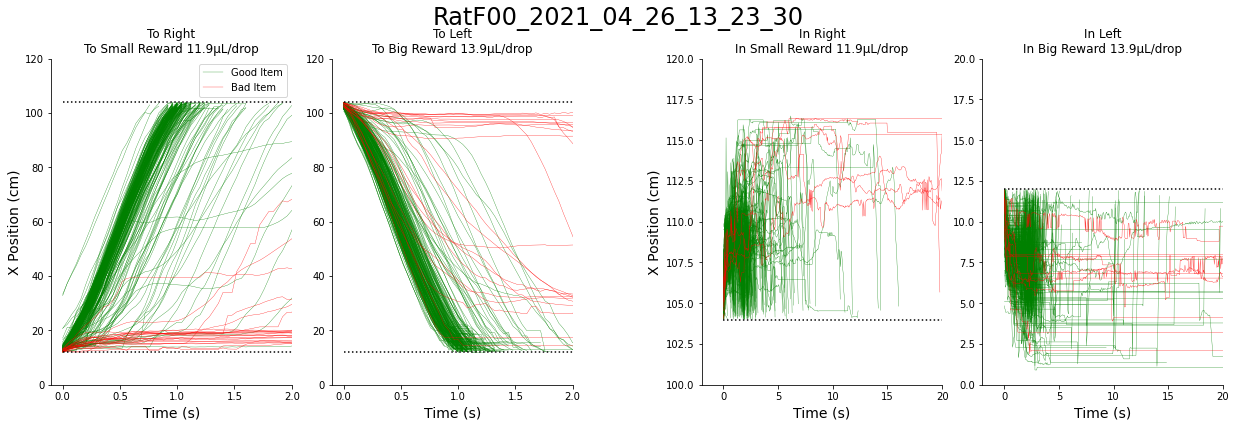

In [28]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        plot_behavPos([good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], good_XtrackStayInRight[animal, session], good_TtrackStayInRight[animal, session], bad_XtrackStayInRight[animal, session], bad_TtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInLeft[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInLeft[animal, session]], animal, session)


# PLOT DISTRIBUTION 

In [29]:
def plot_baseBehav(data, animal, session, title):
    data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7]
    fig = plt.figure(constrained_layout = False, figsize=(21, 6))
    plt.suptitle(title, y= 1, fontsize = 24)
    widths, heights = [5, 5, 1, 5, 5], [6]
    rows, cols = 1, 5
    spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
    index=0
    sub = spec[0,2].subgridspec(2,1)

    for row in range(rows):
        for col in range(cols):
            ax=fig.add_subplot(spec[row, col])              
            if index == 0:
                cumul_plot(data[0], data[1], data[2], data[3], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0,120,1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Speed cm/s","Cumulative Frequency Run Speed", 14, 12], title=["Cumulative Plot Good Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                index+=1
            elif index ==1:
                distribution_plot(data[0], data[1], data[2], data[3], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 120, 1], scatterplotaxes = [0.5, 2.5, 0, 120], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs ", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                index+=1
            elif index ==2:
                blank_plot()
                index+=1
            elif index ==3:
                cumul_plot(data[4], data[5], data[6], data[7], barplotaxes = [0, 15, 0, 1], maxminstepbin = [0, 15, 0.1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Time in zone (s)","Cumulative Frequency Time In Zone", 14, 12], title=["Cumulative Plot Good Time In Zone", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                index+=1
            elif index ==4:
                distribution_plot(data[4], data[5], data[6], data[7], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0,30,1], scatterplotaxes = [0.5, 2.5, 0, 30], xyLabels=["Time in zone (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Time In Zone", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                index+=1
    plt.show()  

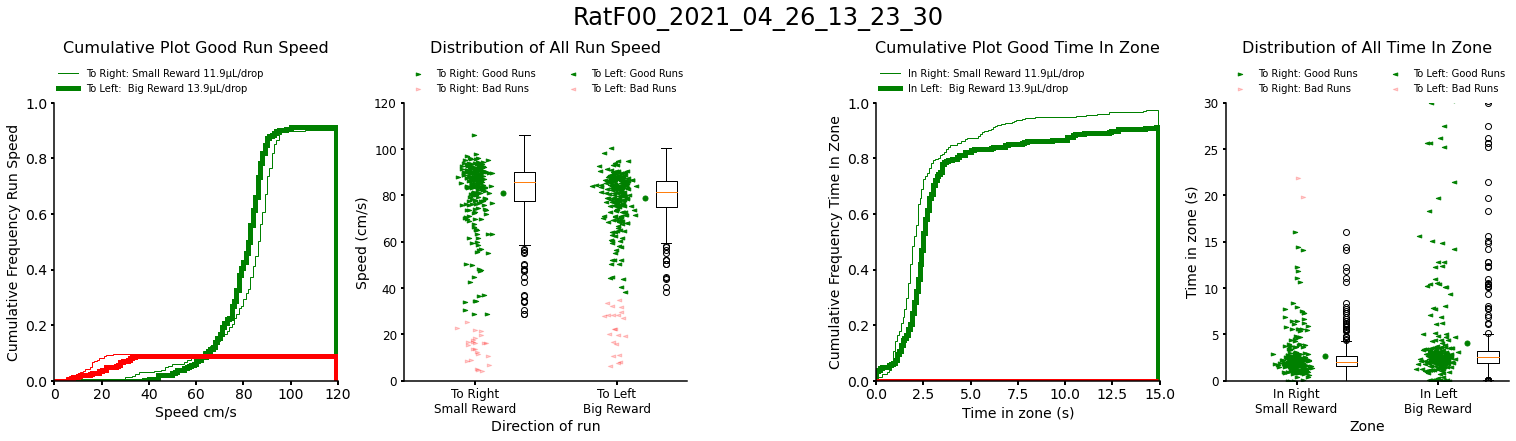

In [30]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        plot_baseBehav([good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session]], animal, session, title = session)

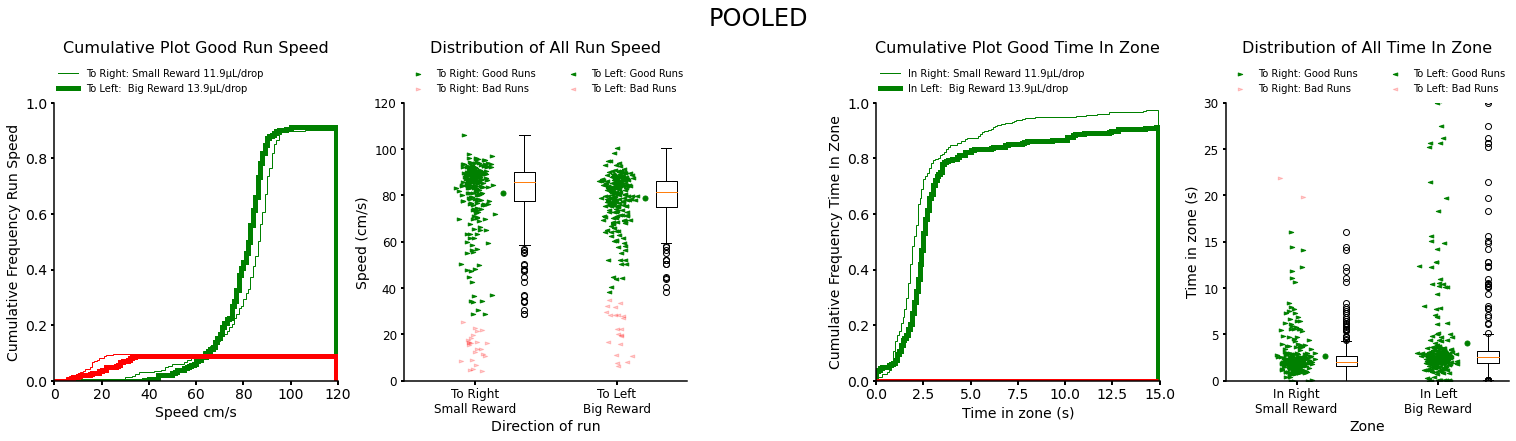

In [31]:
plot_baseBehav([good_speedRunToRightPooled, good_speedRunToLeftPooled, bad_speedRunToRightPooled, bad_speedRunToLeftPooled, good_timeStayInRightPooled, good_timeStayInLeftPooled, bad_timeStayInRightPooled, bad_timeStayInLeftPooled], animal, session, title ="POOLED")

# lick data

In [32]:
prePooledL = list(itertools.chain.from_iterable(list(lick_arrivalLeft.values())))
prePooledR = list(itertools.chain.from_iterable(list(lick_arrivalRight.values())))
drinkPooledL = list(itertools.chain.from_iterable(list(lick_drinkingLeft.values())))
drinkPooledR = list(itertools.chain.from_iterable(list(lick_drinkingRight.values())))
waitPooledL = list(itertools.chain.from_iterable(list(lick_waitLeft.values())))
waitPooledR = list(itertools.chain.from_iterable(list(lick_waitRight.values())))
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            if params[animal, session]["hasLick"] == True:
            #compute stats for individual animals
                print(session)
                print("pre    ", statsrun(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], animal))
                print("drink  ", statsrun(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], animal))
                print("wait   ", statsrun(lick_waitRight[animal, session], lick_waitLeft[animal, session], animal))
                print()
print("POOLED")
print("pre    ", statsrun(prePooledR, prePooledL, ""))
print("drink  ", statsrun(drinkPooledR, drinkPooledL, ""))
print("wait   ", statsrun(waitPooledR, waitPooledL, ""))

RatF00_2021_04_26_13_23_30
pre     R 0.49 ± 0.11   L 0.60 ± 0.16     median R-L 0.28-0.32   0.000*MannWhitney
drink   R 1.11 ± 0.10   L 1.45 ± 0.14     median R-L 0.98-1.24   0.000*MannWhitney
wait    R 1.78 ± 0.34   L 2.95 ± 0.75     median R-L 0.68-0.80   0.000*MannWhitney

POOLED
pre     R 0.49 ± 0.11   L 0.60 ± 0.16     median R-L 0.28-0.32   0.000*MannWhitney
drink   R 1.11 ± 0.10   L 1.45 ± 0.14     median R-L 0.98-1.24   0.000*MannWhitney
wait    R 1.78 ± 0.34   L 2.95 ± 0.75     median R-L 0.68-0.80   0.000*MannWhitney


In [33]:
def plot_lickData(data, animal, session, title):
    #if params[animal, session]["hasLick"] == True:
    fig = plt.figure(constrained_layout = False, figsize=(36, 6))
    plt.suptitle(title, y= 1, fontsize = 24)
    widths, heights = [5, 5, 0.1, 5, 5, 0.1, 5, 5], [6]
    rows, cols = 1, 8
    spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
    index=0
    sub = spec[0,2].subgridspec(2,1)

    for row in range(rows):
        for col in range(cols):
            ax=fig.add_subplot(spec[row, col])              
            if index == 0:
                cumul_plot(data[0], data[1], data[2], data[3], barplotaxes = [0, 2, 0, 1], maxminstepbin = [0,2,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot preDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                index+=1
            elif index ==1:
                distribution_plot(data[0], data[1], data[2], data[3], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 2], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution preDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
                index+=1
            elif index ==2:
                blank_plot()
                index+=1
            elif index ==3:
                cumul_plot(data[4], data[5], data[6], data[7], barplotaxes = [0, 4, 0, 1], maxminstepbin = [0,4,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot Drink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                index +=1
            elif index ==4:
                distribution_plot(data[4], data[5], data[6], data[7], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 4], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of Drink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
                index+=1
            elif index ==5:
                blank_plot()
                index+=1
            elif index ==6:
                cumul_plot(data[8], data[9], data[10], data[11], barplotaxes = [0, 10, 0, 1], maxminstepbin = [0,10,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot postDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                index +=1
            elif index ==7:
                distribution_plot(data[8], data[9], data[10], data[11], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 10], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of postDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
    plt.show()

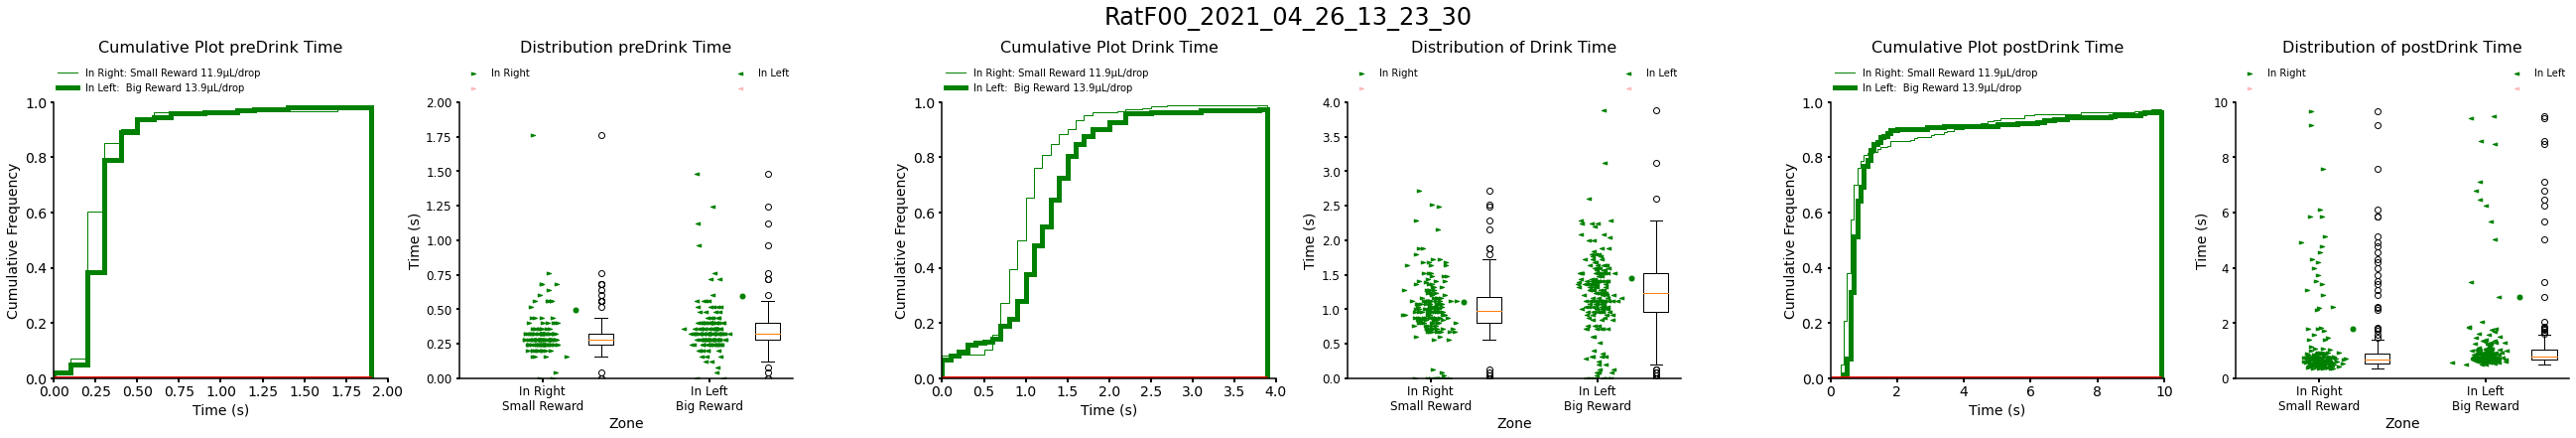

In [34]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        plot_lickData([lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], lick_waitRight[animal, session], lick_waitLeft[animal, session], [], []], animal, session, title = session)

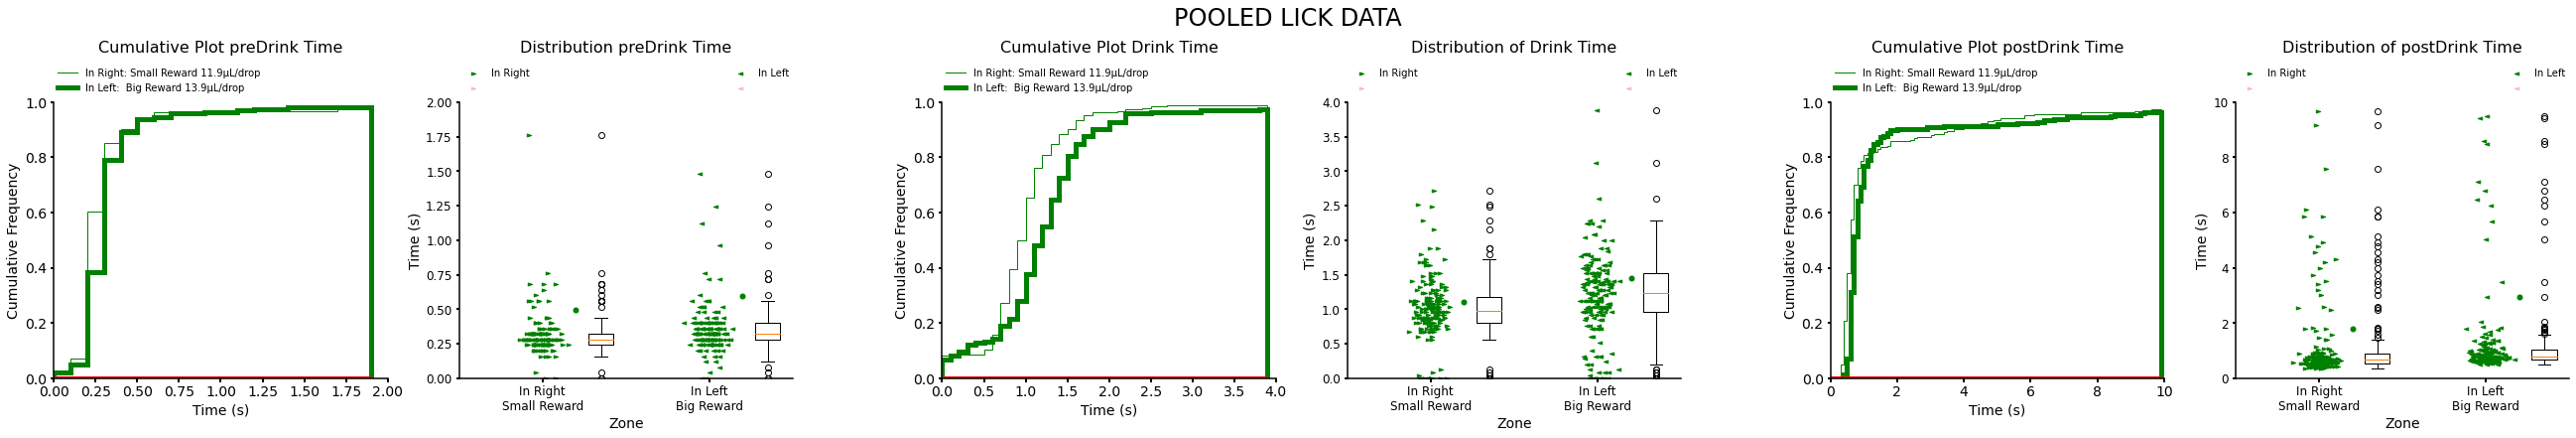

In [35]:
plot_lickData([prePooledR, prePooledL, [], [], drinkPooledR, drinkPooledL, [], [], waitPooledR, waitPooledL, [], []], animal, session, title = "POOLED LICK DATA")

# PLOT RECAPS

In [36]:
def plot_recapBehav(data, animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(30, 6))
    plt.suptitle("RECAP", y= 1, fontsize = 24)
    widths, heights = [4, 4, 0.1, 2, 2, 2], [6]
    rows, cols = 1, 6
    spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
    index=0
    #sub = spec[0,2].subgridspec(2,1)

    for row in range(rows):
        for col in range(cols):
            ax=fig.add_subplot(spec[row, col])              
            if index == 0:
                plot_recap(animal, session, data[0], data[1], data[2], data[3], axes = [0.5, 2.5, 20, 120], xyLabels=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Direction", "Speed (cm/s)", 14, 12], title=["Recap dist/run duration", 16], linewidth = [1.5])
                plt.axvspan(0.5, 2.5, color='red', alpha=0.05)
                index+=1
            elif index ==1:
                plot_recap(animal, session, data[4], data[5], data[6], data[7], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Side", "Time (s)", 14, 12], title=["Recap time in sides", 16], linewidth = [1.5])
                index += 1
            elif index ==2:
                blank_plot()
                index+=1
            elif index ==3:
                plot_recap(animal, session, data[8], data[9], data[10], data[11], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time pre-drink", 16], linewidth = [1.5])
                index+=1
            elif index ==4:
                plot_recap(animal, session, data[12], data[13], data[14], data[15], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time spent drinking", 16], linewidth = [1.5])
                index+=1
            elif index ==5:
                plot_recap(animal, session, data[16], data[17], data[18], data[19], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time post-drink = wait", 16], linewidth = [1.5])
                plt.axvspan(0.5, 2.5, color='red', alpha=0.05)


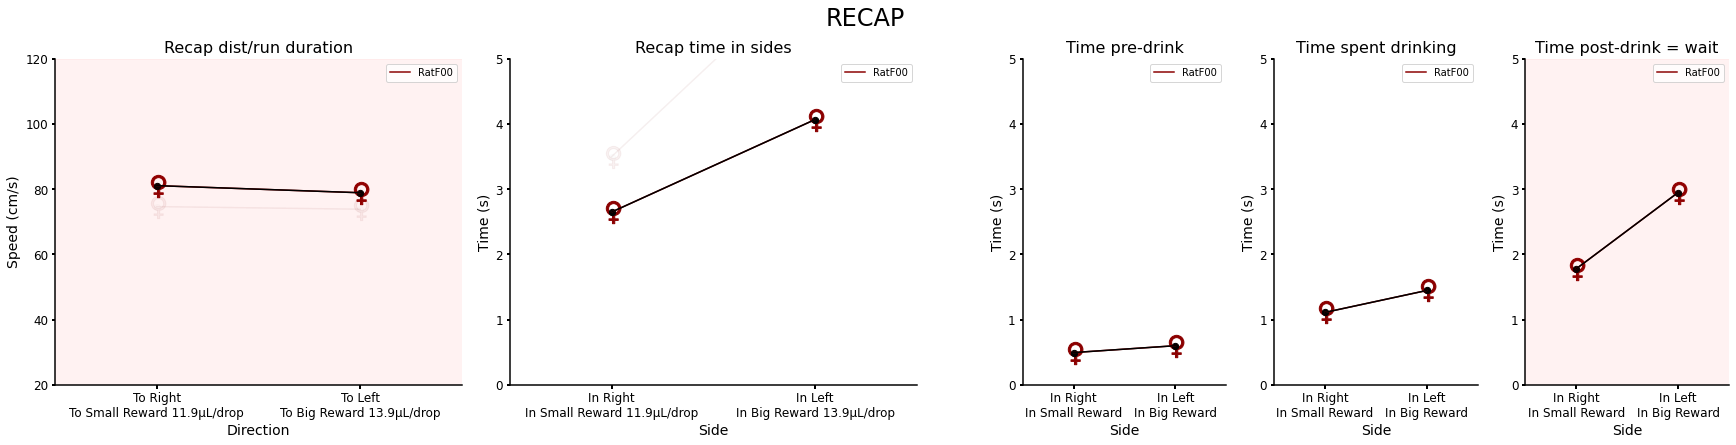

In [37]:
plot_recapBehav([good_speedRunToRight, good_speedRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, good_timeStayInRight, good_timeStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, lick_arrivalRight, lick_arrivalLeft, [], [], lick_drinkingRight, lick_drinkingLeft, [], [], lick_waitRight, lick_waitLeft, [], []], animal, session)

### RECAP_FIG_DAVID
def plot_recapfigDavid(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            ax3 = plt.gca()
            plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0])
            plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0])
            plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 2.5)

            ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
            ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
            ax3.set_title(title[0], fontsize = title[1])
            ax3.set_xlim([axes[0], axes[1]])
            ax3.set_ylim([axes[2], axes[3]])
            ax3.set_xticks([1,2])
            ax3.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
            ax3.spines['bottom'].set_linewidth(linewidth[0])
            ax3.spines['left'].set_linewidth(linewidth[0])
            ax3.spines['top'].set_color("none")
            ax3.spines['right'].set_color("none")
            ax3.tick_params(width=2, labelsize = xyLabels[5])
            return plt
            #plt.legend()

#axes reversed
fig = plt.figure(constrained_layout = False, figsize=(16, 6))
#plt.suptitle("RECAP", y= 1, fontsize = 24)
widths, heights = [5, 5], [6]
rows, cols = 1, 2
spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
index=0

for row in range(rows):
    for col in range(cols):
        ax=fig.add_subplot(spec[row, col])              
        if index == 0:
            plot_recapfigDavid(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [2.25, 0.75, 60, 120], xyLabels=["Toward " + water[animal, session][1] + "\n" + str(round(params[animal, session]["waterRight"], 1)) + "µL", "Toward " + water[animal, session][0] + "\n" + str(round(params[animal, session]["waterLeft"], 1)) + "µL", "", "Speed (cm/s)", 16, 12], title=["Running speed", 18], linewidth = [1.5])
            index+=1
        elif index ==1:
            plot_recapfigDavid(animal, session, lick_waitRight, lick_waitLeft, [], [], axes = [2.25, 0.75, 0, 5], xyLabels=["In " + water[animal, session][1] + " Zone \n" + str(round(params[animal, session]["waterRight"], 1)) + "µL", "In " + water[animal, session][0] + " Zone \n" + str(round(params[animal, session]["waterLeft"], 1)) + "µL", "", "Time (s)", 16, 12], title=["Time post-drink", 18], linewidth = [1.5])
            index+=1

# Split runs/stays using running speed

In [38]:
def convert_scale(number): #convert scale, looping through i=0:120 and convert to 60:-60 which correspnds to the speed to the right (0 to 60) and to the left (0 to -60)
    old_min=0
    old_max=120
    new_max=-60
    new_min=60
    return int(((number- old_min) / (old_max - old_min)) * (new_max - new_min) + new_min)

def filterspeed(dataPos, dataSpeed, dataTime):
    #dissociate runs from non runs, we want a cut off based on animal, speed. How to define this speed? If we plot the speed of the animal in function of the X position in the apparatus, so we can see that there is some blobs of speeds close to 0 and near the extremities of the treadmill, these are the ones that we want to define as non running speeds. With this function we want to compute the area of these points of data (higher density, this technique might not work when animals are not properly trained) in order to differentiate them.
                            
    xmin, xmax = 0, 120 #specify the x and y range of the window that we want to analyse
    ymin, ymax =-60, 60
    position = np.array(dataPos, dtype = float) #data needs to be transformed to float perform the KDE
    speed = np.array(dataSpeed, dtype = float)
    time = np.array(dataTime, dtype = float)

    X, Y = np.mgrid[xmin:xmax:120j, ymin:ymax:120j]#create 2D grid to compute KDE
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([position, speed])
    kernel = stats.gaussian_kde(values)#compute KDE, this gives us an estimation of the point density
    Z = np.reshape(kernel(positions).T, X.shape)
    #Using the KDE that we just computed, we select the zones that have a density above a certain threshold (after testing 0.0001 seems to work well), which roughly corresponds to the set of data that we want to extract. We loop through the 2D array, if the datapoint is > threshold we get the line (speed limit) and the row (X position in cm). This gives us the speed limit for each part of the treadmill, so basically a zone delimited with speed limits (speed limits can be different in different points of the zone).
    i, j = [], [] #i is the set of speeds (lines) for which we will perform operations, j is the set of positions (rows) for each speed for which we will perform operations
    for line in range(0, len(np.rot90(Z))):
        if len(np.where(np.rot90(Z)[line]> 0.0001)[0]) > 1:
            i.append(convert_scale(line))
            j.append(np.where(np.rot90(Z)[line] > 0.0001)[0])

    #create a mask using the zone computed before and combine them. We have two zones (left and right), so we perform the steps on each side, firs part is on the left.
    rawMask = []
    for line, pos in zip(i, j): #pos is the array of positions for which the speed of the animal is under the speed limit. "11 [ 7  8  9 10 11]" for instance here the speed limit is 11 cm/s, and is attained between 7 and 11cm on the treadmill. "10 [  4   5   6   7   8   9  10  11  12  13 105 106 107 108 109 110]" when we decrease the speed limit, here 10, we here have 2 zones, one between 4 and 13cm and another between 105 and 110cm. we continue through these speed values (roughly from 11 to 0, then from 0 to -10 in this example)
        if pos[pos<60] != []:
            low = pos[pos<60][0]#first value of the array, explained above (7)
            high = pos[pos<60][-1]#last value of the array (11)
            a = np.ma.masked_less(position, high)#take everything left of the rightmost point, if the value is ok == True
            b = np.ma.masked_greater(position,low)#take everything right of the leftmost point
            c = np.ma.masked_less(speed, line+0.5)#take everything below the high point
            d = np.ma.masked_greater(speed,line-0.5)#take everything above the low point

            mask = np.logical_and(a.mask,b.mask)#first combination for all the rows (=Xposition), keep the intersection of mask a AND b, so keep all between the leftmost and rightmost points
            mask2 = np.logical_and(c.mask, d.mask)#second combination for all the lines (=speed), keep the intersection of mask c AND d, so keep all between speed+0.5:speed-0.5
            combiLeft = np.logical_and(mask, mask2)# combine the first and the second mask, so we only keep the intersection of the two masks, intersection is TRUE, the rest is FALSE
            if rawMask == []:#must do that for the first iteration so it's not empty
                rawMask = combiLeft
            else : rawMask = np.logical_xor(combiLeft, rawMask) # merge the newly computed mask with the previously computed masks. We use XOR so that the TRUE values of the new mask are added to the complete mask. Same step left and right just add to the existing full mask wether the new mask is on the left or the right. 
        #same as above for the right part
        if pos[pos>60] != []:
            low = pos[pos>60][0]
            high = pos[pos>60][-1]
            a = np.ma.masked_less(position, high)
            b = np.ma.masked_greater(position,low)
            c = np.ma.masked_less(speed, line+0.5)
            d = np.ma.masked_greater(speed,line-0.5)

            mask = np.logical_and(a.mask,b.mask)
            mask2 = np.logical_and(c.mask, d.mask)
            combiRight = np.logical_and(mask, mask2)
            if rawMask == []:
                rawMask = combiRight
            else : rawMask = np.logical_xor(combiRight, rawMask)

    return ~rawMask

# this function allows to smooth the mask that we created above. Basically if we have something like [False, True, False], the middle TRUE might break a long line of FALSE, so we check the mask and replace these T/F. Obviously the break can be >1, so this function checks for gaps of size "N", so if N = 5 we look from the [False, True, False] sequence up to [False, True, True,True,True,True,True, False] sequence. By checking for small gaps first it is not so computationally expensive, we then check for bigger gaps once the small ones have been filled. After multiple tests a first pass at 10 then a second pass at 20 provides good results. Have to do 2 passes, maybe modify the function to have N == [10, 20] and loop through these values. Done but does not give intended results, check that later not important and previous version works fine. If suggestion is worked out, can look for a way to add this function in the function just above and do one big function that computes the finished mask. 
def cutoff_smooth(mask, N):    
    modified_mask = []
    modified_mask = mask
    for i in range(0, len(mask)-N):
        seq = [mask[i], mask[i+1], mask[i+2]]
        checkTrue = [False, True, False]
        checkFalse= [True, False, True]        
        for j in range(2, N):
            if seq == checkTrue:
                mask[i+1] = False
            elif seq == checkFalse:
                mask[i+1] = True
            seq.append(mask[i+j])
            checkTrue.insert(-2, True)
            checkFalse.insert(-2, False)
    return modified_mask

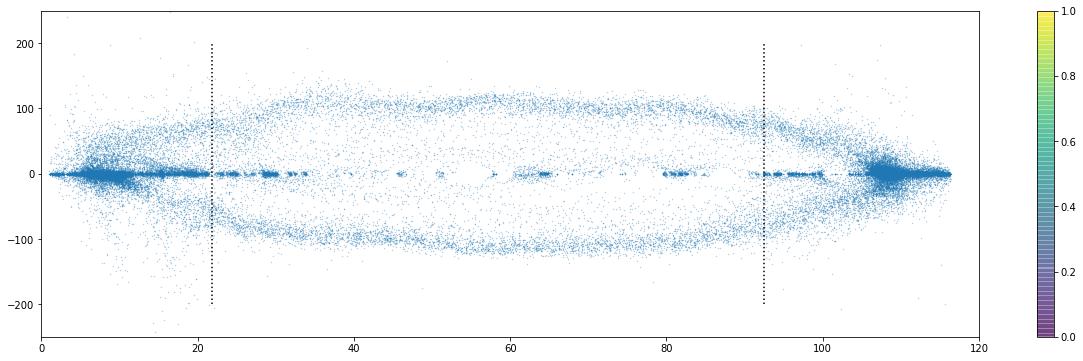

In [39]:
#just plot to have an idea of what we are going to analyse
import seaborn as sns
for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
                fig = plt.figure(constrained_layout = False, figsize=(21, 6))
                #sns.set_style("white")
                #sns.kdeplot(x, y, cmap="Reds", shade=True, bw_adjust=.5)#, thresh=0.7)
                plt.scatter(rawPositionX[animal, session], rawSpeed[animal, session], s=0.1, alpha=0.5)
                plt.colorbar()
                plt.xlim(0,120)
                plt.ylim(-250, 250)

                plt.xlim(0,120)
                plt.ylim(-250, 250)

                xline1 = [px2cm(240), px2cm(240)]
                xline2 = [px2cm(1017),px2cm(1017)]
                xline = [-200,200]

                plt.plot(xline1, xline, ":", color='k')
                plt.plot(xline2, xline, ":", color='k')

In [40]:
#remove treadmill speed from animal speed
treadmillCorrectedSpeed = {}
treadmillCorrectedSpeedBin = {}
for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        treadmillCorrectedSpeed[animal, session] = []
        treadmillCorrectedSpeedBin[animal, session] = {}
        if all(v == params[animal, session]['treadmillSpeed'][0] for v in params[animal, session]['treadmillSpeed']):
            treadmillCorrectedSpeed[animal, session] = [(speed + params[animal, session]['treadmillSpeed'][0] if speed > 0 else speed - params[animal, session]['treadmillSpeed'][0]) if np.logical_and(mask==True, pos >=21.81 and pos<= 92.45) else speed for speed, pos, mask in zip(rawSpeed[animal, session], rawPositionX[animal,session], smoothMask[animal,session])]
        else:
            continue
            #for i in range( 0, len()) do the same for bins

#rawSpeed = {}
for animal in animalList: 
        for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]:
                fig = plt.figure(constrained_layout = False, figsize=(21, 6))
                plt.scatter(rawPositionX[animal, session], treadmillCorrectedSpeed[animal, session], s=0.1, alpha=0.5)
                plt.xlim(0,120)
                plt.ylim(-250, 250)

                xline1 = [px2cm(240), px2cm(240)]
                xline2 = [px2cm(1017),px2cm(1017)]
                xline3 = [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]]
                xline4 = [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]]
                xline = [-200,200]

                plt.plot(xline1, xline, ":", color='k')
                plt.plot(xline2, xline, ":", color='k')
                plt.plot(xline3, xline, ":", color='k')
                plt.plot(xline4, xline, ":", color='k')

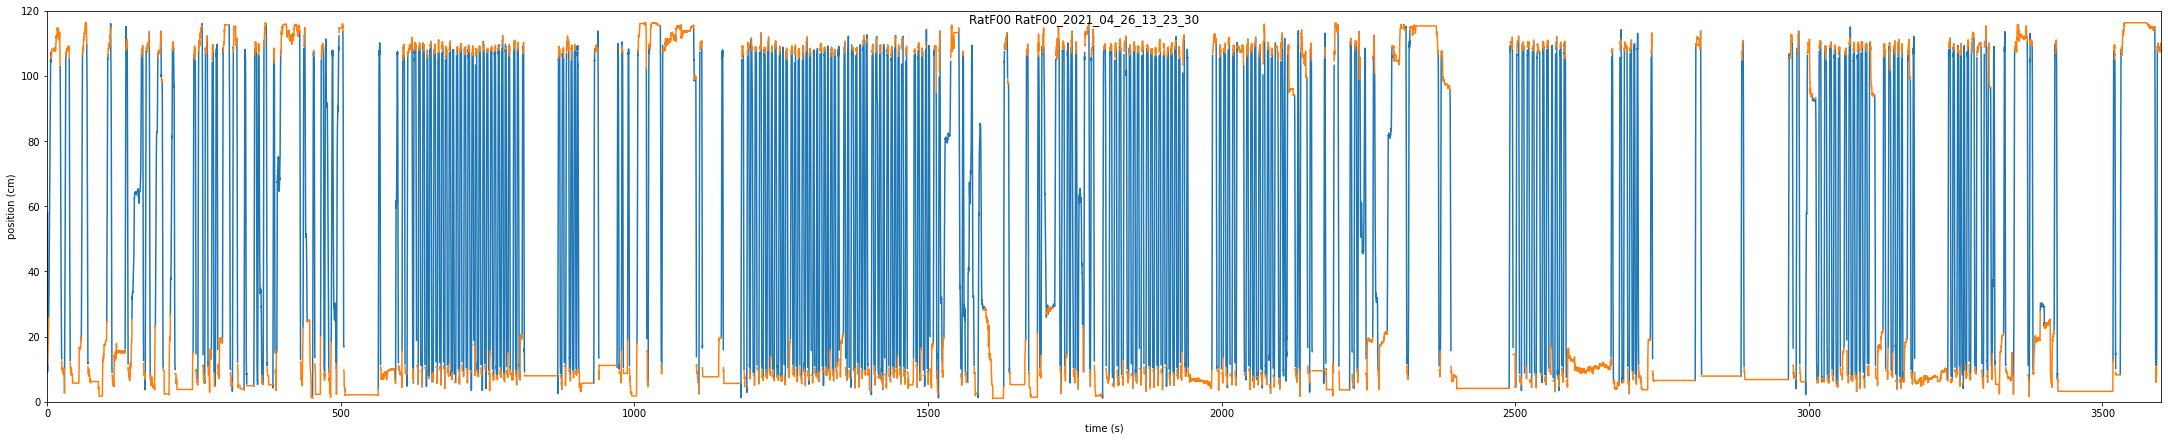

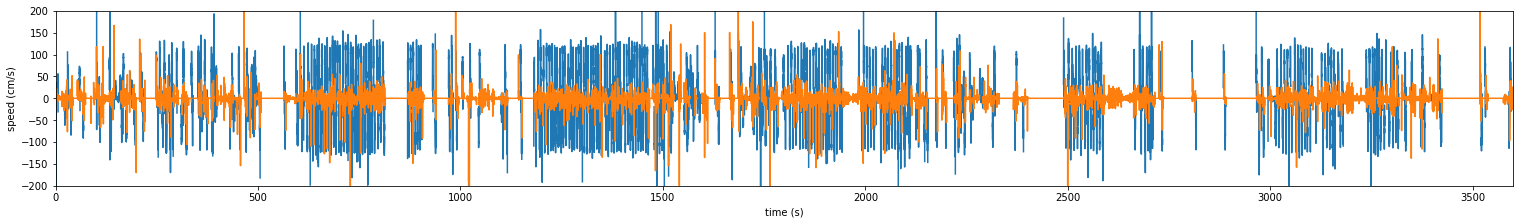

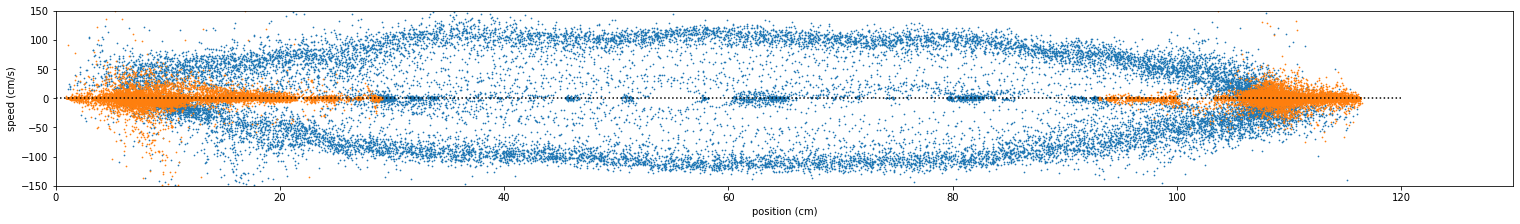

In [41]:
#test to see if everything is working properly, extract runs and stuff instead of plotting
redoMask = False
smoothMask = {}
rawMask = {}
binSpeed = {}
binMask = {}
goodPos, badPos = {}, {}
goodSpeed, badSpeed = {}, {}

for animal in animalList: 
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]:
        picklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"mask.p"
        if os.path.exists(picklePath) and (not redoMask):
            smoothMask[animal,session] = get_from_pickle(animal, session, name="mask.p")
        else:
            rawMask[animal,session] = filterspeed(rawPositionX[animal, session], rawSpeed[animal, session], rawTime[animal, session])#Deprecation warning here
            smoothMask[animal,session] = cutoff_smooth(cutoff_smooth(rawMask[animal,session], 10), 20)#Have to do 2 passes, maybe modify the function to have N == [10, 20] and loop through these values. Done but does not give intended results, check that later not important and previous version works fine. Maybe improve computation by skipping stuff that we don't have to compute. Modified into a one liner, directly feeding the first line to the second one.
            save_as_pickle(smoothMask[animal, session], animal, session, "mask.p")
        
        goodPos[animal,session] = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
        badPos[animal,session]  = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
        goodSpeed[animal,session] = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
        badSpeed[animal,session]  = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
        binMask[animal,session] = bin_session(smoothMask, rawTime, blocks[0][0], blocks[-1][1], blocks)
        binSpeed[animal,session] = bin_session(rawSpeed, rawTime, blocks[0][0], blocks[-1][1], blocks)


        fig = plt.figure(constrained_layout=True, figsize=(30,6))
        fig.suptitle(animal + " " + session)
        plt.plot(rawTime[animal, session], goodPos[animal, session])
        plt.plot(rawTime[animal, session], badPos[animal, session])
        plt.xlabel('time (s)')
        plt.ylabel('position (cm)')
        plt.xlim(0,3600)
        plt.ylim(0,120)

        fig = plt.figure(constrained_layout=True, figsize=(21,3))
        plt.plot(rawTime[animal,session], goodSpeed[animal,session])
        plt.plot(rawTime[animal,session], badSpeed[animal, session])
        plt.xlabel('time (s)')
        plt.ylabel('speed (cm/s)')
        plt.xlim(0, 3600)
        plt.ylim(-200,200)

        fig = plt.figure(constrained_layout=True, figsize=(21,3))
        plt.scatter(rawPositionX[animal,session], goodSpeed[animal,session], s=0.5)
        plt.scatter(rawPositionX[animal,session], badSpeed[animal,session], s=0.5)
        plt.xlabel('position (cm)')
        plt.ylabel('speed (cm/s)')
        plt.xlim(0,130)
        plt.ylim(-150,150)
        yline = [0, 120]
        xline = [0,0]
        plt.plot(yline, xline, ":", color='k')

In [42]:
def extract_runSpeed(dataPos, dataSpeed, dataTime, dataLickR, dataLickL, mask, animal, session, boundary, limspeed, hasLick):
    runs = {}
    stays = {}
    goodPos, badPos = [], []
    goodSpeed, badSpeed = [], []
    goodTime, badTime = [], []

    good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft = ([] for i in range(6)) 
    bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight, bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft = ([] for i in range(6)) 
    all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft = ([] for i in range(4)) 

    good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft = ([] for i in range(6)) 
    bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft = ([] for i in range(6)) 
    all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft = ([] for i in range(4)) 

    lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ([] for i in range(6)) 
    good_instantSpeedRight, bad_instantSpeedRight, all_instantSpeedRight, good_instantSpeedLeft, bad_instantSpeedLeft, all_instantSpeedLeft = ([] for i in range(6))
    good_maxSpeedRight, bad_maxSpeedRight, all_maxSpeedRight, good_maxSpeedLeft, bad_maxSpeedLeft, all_maxSpeedLeft = ([] for i in range(6))

    position = np.array(dataPos[animal, session], dtype = float)
    speed = np.array(dataSpeed[animal, session], dtype = float)
    time = np.array(dataTime[animal, session], dtype = float)

    goodPos = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(position, mask)]]
    badPos  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(position, mask)]]
    goodSpeed = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(speed, mask)]]
    badSpeed  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(speed, mask)]]
    goodTime = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(time, mask)]]
    badTime  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(time, mask)]]

    stays[animal, session] = [[e[0], e[1], e[2], e[3], e[4]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k, l, m] for i, j, k, l, m in zip(goodPos, goodSpeed, goodTime, dataLickR[animal, session], dataLickL[animal, session])]]
    runs[animal, session] = [[e[0], e[1], e[2]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k] for i, j, k, in zip(badPos, badSpeed, badTime)]]

    for run in split_a_list_at_zeros(runs[animal, session]):
        #calculate distance run as the distance between first and last value
        distanceRun = abs(run[0][0]-run[-1][0])
        #calculate time as sum of time interval between frames
        totaltimeRun = []
        xTrackRun = []
        instantSpeed = []
        maxSpeed = []
        for item in run:
            xTrackRun.append(item[0])
            instantSpeed.append(abs(item[1]))
            totaltimeRun.append(item[2])
        speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
        maxSpeed = [max(instantSpeed), xTrackRun[np.argmax(instantSpeed)], totaltimeRun[np.argmax(instantSpeed)]] #[max speed reached during the run, where it was reached, and when]
        #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
        if run[0][0] < ((boundary[0]+boundary[1])/2):
            #check if the subsplit is ending on the other side -> determine if this is a run 
            if run[-1][0] > ((boundary[0]+boundary[1])/2):
                #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                #second pass : there is a computed limspeed, use it to sort good and bad runs
                if limspeed[0] is not None:
                    #check if this is a good or bad run and assign im to the good or bad array accordingly
                    if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]:
                        #good run array
                        good_speedRunToRight.append(speedRun)
                        good_XtrackRunToRight.append(xTrackRun)
                        good_timeRunToRight.append(totaltimeRun)  
                        good_instantSpeedRight.append(instantSpeed) 
                        good_maxSpeedRight.append(maxSpeed)
                    else:
                        #bad run array
                        bad_speedRunToRight.append(speedRun)
                        bad_XtrackRunToRight.append(xTrackRun)
                        bad_timeRunToRight.append(totaltimeRun)
                        bad_instantSpeedRight.append(instantSpeed)
                        bad_maxSpeedRight.append(maxSpeed)
                else:
                    #all runs array first pass
                    all_speedRunToRight.append(speedRun)
                    all_timeRunToRight.append(totaltimeRun)
                    all_instantSpeedRight.append(instantSpeed)
                    all_maxSpeedRight.append(maxSpeed)
        #same thing for the runs that go to the other side
        elif run[0][0]>((boundary[0]+boundary[1])/2):
            if run[-1][0]<((boundary[0]+boundary[1])/2):
                if limspeed[1] is not None:
                    if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                        good_speedRunToLeft.append(speedRun)   
                        good_XtrackRunToLeft.append(xTrackRun)
                        good_timeRunToLeft.append(totaltimeRun)
                        good_instantSpeedLeft.append(instantSpeed) 
                        good_maxSpeedLeft.append(maxSpeed)
                    else:
                        bad_speedRunToLeft.append(speedRun)
                        bad_XtrackRunToLeft.append(xTrackRun)
                        bad_timeRunToLeft.append(totaltimeRun)
                        bad_instantSpeedLeft.append(instantSpeed)
                else:
                    all_speedRunToLeft.append(speedRun)
                    all_timeRunToLeft.append(totaltimeRun)
                    all_instantSpeedLeft.append(instantSpeed)


    for stay in split_a_list_at_zeros(stays[animal, session]):
        tInZone = []
        xTrackStay = []
        lickR = []
        lickL = []
        for item in stay:
            xTrackStay.append(item[0])
            tInZone.append(item[2])
            lickR.append(item[3])
            lickL.append(item[4])
        totaltimeStay = np.sum(np.diff(tInZone))
        #first identify if the subsplit created is on the left or right by comparing to the middle
        if stay[0][0] > ((boundary[0]+boundary[1]) / 2):
            if hasLick == True: #put hasLick as a param
                # if empty put in bad stay
                if not all(v == 0 for v in lickR):
                    #bad_timeStayInRight.append(totaltimeStay)
                    #bad_XtrackStayInRight.append(xTrackStay)
                    #bad_TtrackStayInRight.append(tInZone)
                    #continue
                    pre = []
                    drink = []
                    post = []
                    for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                        pre.append(t)
                    for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                        drink.append(t)
                    for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                        post.append(t)
                    
                    #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)
                    lick_arrivalRight.append(np.sum(np.diff(pre)))
                    lick_drinkingRight.append(np.sum(np.diff(drink)))
                    lick_waitRight.append(np.sum(np.diff(post)))

            if limspeed[0] is not None:
                if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:# and xTrackStay[0] > boundary[0] and xTrackStay[-1] > boundary[0]:
                    good_timeStayInRight.append(totaltimeStay)
                    good_XtrackStayInRight.append(xTrackStay)
                    good_TtrackStayInRight.append(tInZone)
                else:
                    bad_timeStayInRight.append(totaltimeStay)
                    bad_XtrackStayInRight.append(xTrackStay)
                    bad_TtrackStayInRight.append(tInZone)
            else:
                all_timeStayInRight.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)
      
        elif stay[0][0] < ((boundary[0] + boundary[1]) / 2):
            if hasLick == True: #put hasLick as a param
                if not all(v == 0 for v in lickL):
                    #bad_timeStayInLeft.append(totaltimeStay)
                    #bad_XtrackStayInLeft.append(xTrackStay)
                    #bad_TtrackStayInLeft.append(tInZone)
                    #continue
                    preL = []
                    drinkL = []
                    postL = []
                    for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                        preL.append(t)
                    for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                        drinkL.append(t)
                    for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                        postL.append(t)

                    lick_arrivalLeft.append(np.sum(np.diff(preL)))
                    lick_drinkingLeft.append(np.sum(np.diff(drinkL)))
                    lick_waitLeft.append(np.sum(np.diff(postL)))

            if limspeed[1] is not None:
                if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:# and xTrackStay[0] < boundary[1] and xTrackStay[-1] < boundary[1]:
                    good_timeStayInLeft.append(totaltimeStay)   
                    good_XtrackStayInLeft.append(xTrackStay)
                    good_TtrackStayInLeft.append(tInZone)
                else:
                    bad_timeStayInLeft.append(totaltimeStay)
                    bad_XtrackStayInLeft.append(xTrackStay)
                    bad_TtrackStayInLeft.append(tInZone)
            else:
                all_timeStayInLeft.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)         

    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

In [43]:
redoExtractRuns_wSpeed = True
limspeedRunToRight, limspeedRunToLeft, limstayRight, limstayLeft, all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({} for i in range(54))

for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        picklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"behav_speed.p"
        if os.path.exists(picklePath) and (not redoExtractRuns_wSpeed):
            print(session, "pickled")
            all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], all_timeRunToRight[animal, session], all_timeRunToLeft[animal, session], all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], all_TtrackStayInRight[animal, session], all_TtrackStayInLeft[animal, session], all_instantSpeedRight[animal, session], all_instantSpeedLeft[animal, session], all_maxSpeedRight[animal, session], all_maxSpeedLeft[animal, session], good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToRight[animal, session], good_timeRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], bad_XtrackRunToRight[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToRight[animal, session], bad_timeRunToLeft[animal, session], good_instantSpeedRight[animal, session], good_instantSpeedLeft[animal, session], good_maxSpeedRight[animal, session], good_maxSpeedLeft[animal, session], bad_instantSpeedRight[animal, session], bad_instantSpeedLeft[animal, session], bad_maxSpeedRight[animal, session], bad_maxSpeedLeft[animal, session], good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session], lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session], limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session], limstayRight[animal, session], limstayLeft[animal, session] = get_from_pickle(animal, session, name="behav_speed.p")[0:54]

        else:
            all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], all_timeRunToRight[animal, session], all_timeRunToLeft[animal, session], all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], all_TtrackStayInRight[animal, session], all_TtrackStayInLeft[animal, session], all_instantSpeedRight[animal, session], all_instantSpeedLeft[animal, session], all_maxSpeedRight[animal, session], all_maxSpeedLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, params[animal, session]["boundaries"], [None, None], False)[0:12]
            #compute limspeed (speed below which we consider that the rats are not running, or spent too long in the sides) as the speeds below 2 st dev of the mean speed. can be changed #test confidence interval
            limspeedRunToRight[animal, session] = [np.mean(all_speedRunToRight[animal, session]) - 2*statistics.stdev(all_speedRunToRight[animal, session]), np.mean(all_speedRunToRight[animal, session]) + 2*statistics.stdev(all_speedRunToRight[animal, session])]
            limspeedRunToLeft[animal, session]  = [np.mean(all_speedRunToLeft[animal, session]) - 2*statistics.stdev(all_speedRunToLeft[animal, session]), np.mean(all_speedRunToLeft[animal, session]) + 2*statistics.stdev(all_speedRunToLeft[animal, session])]
            limstayRight[animal, session]       = [np.mean(all_timeStayInRight[animal, session]) - 2*statistics.stdev(all_timeStayInRight[animal, session]), np.mean(all_timeStayInRight[animal, session]) + 2*statistics.stdev(all_timeStayInRight[animal, session])]
            limstayLeft[animal, session]        = [np.mean(all_timeStayInLeft[animal, session]) - 2*statistics.stdev(all_timeStayInLeft[animal, session]), np.mean(all_timeStayInLeft[animal, session]) + 2*statistics.stdev(all_timeStayInLeft[animal, session])]
            #extract the run data (good/bad, to left/to right) 
            good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToRight[animal, session], good_timeRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], bad_XtrackRunToRight[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToRight[animal, session], bad_timeRunToLeft[animal, session], good_instantSpeedRight[animal, session], good_instantSpeedLeft[animal, session], good_maxSpeedRight[animal, session], good_maxSpeedLeft[animal, session], bad_instantSpeedRight[animal, session], bad_instantSpeedLeft[animal, session], bad_maxSpeedRight[animal, session], bad_maxSpeedLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[12:32]
            #extract the stay data (good/bad, in left/in right) 
            if params[animal, session]["hasLick"] == True:
                good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session], lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:50]

            if params[animal, session]["hasLick"] == False:
                good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session] = extract_runSpeed(rawPositionX, rawSpeed, rawTime, rawLickRight1X, rawLickLeft1X, smoothMask[animal,session], animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:44]
                lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session] = [], [], [], [], [], []

            print(animal, "donecomputing")
            save_as_pickle([all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], all_timeRunToRight[animal, session], all_timeRunToLeft[animal, session], all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], all_TtrackStayInRight[animal, session], all_TtrackStayInLeft[animal, session], all_instantSpeedRight[animal, session], all_instantSpeedLeft[animal, session], all_maxSpeedRight[animal, session], all_maxSpeedLeft[animal, session], good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToRight[animal, session], good_timeRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], bad_XtrackRunToRight[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToRight[animal, session], bad_timeRunToLeft[animal, session], good_instantSpeedRight[animal, session], good_instantSpeedLeft[animal, session], good_maxSpeedRight[animal, session], good_maxSpeedLeft[animal, session], bad_instantSpeedRight[animal, session], bad_instantSpeedLeft[animal, session], bad_maxSpeedRight[animal, session], bad_maxSpeedLeft[animal, session], good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft[animal, session], lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session], limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session], limstayRight[animal, session], limstayLeft[animal, session]], animal, session, "behav_speed.p")

RatF00 donecomputing


In [44]:
def plot_speed(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, index, bounds, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1 ): 
    ax = plt.gca()
    for i, j in zip(good_PosdataRight, good_TimedataRight):
        time = np.subtract(j, j[0])
        iabs =  [abs(ele) for ele in i]
        plt.plot(np.subtract(j, j[0]), iabs, color='g' , linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] and index ==0 else "")
        if len(np.where(i == max(i))[0]) == 1:
            maxspeed = max(iabs)
            maxspeedtime = np.where(iabs == maxspeed)[0]
            plt.scatter(time[maxspeedtime], maxspeed, color ='darkgreen', s=20)
        else:
            print(max(i))

    for k, l in zip(bad_PosdataRight, bad_TimedataRight):
        time = np.subtract(l, l[0])
        kabs =  [abs(ele) for ele in k]
        plt.plot(np.subtract(l, l[0]), kabs, color='r', linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] and index == 0 else "")
        if len(np.where(k == max(k))[0]) == 1:
            maxspeed = max(kabs)
            maxspeedtime = np.where(kabs == maxspeed)[0]
            plt.scatter(time[maxspeedtime], maxspeed, color ='darkgreen', s=20)
        else:
            print(max(k))

    ax.set_title(title[0], fontsize = title[1])
    ax.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    ax.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    xline1 = [bounds[0], bounds[0]]
    xline2 = [bounds[1], bounds[1]]
    yline = [0,20]
    plt.plot(yline, xline1, ":", color='k')
    plt.plot(yline, xline2, ":", color='k')
    if index == 0:
        ax.legend()
    return ax

def plot_figSpeed(data, animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(21, 6))
    plt.suptitle(session, y= 1, fontsize = 24)
    widths, heights = [5, 5,], [6]
    rows, cols = 1, 2
    spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
    index=0
    for row in range(rows):
        for col in range(cols):
            ax=fig.add_subplot(spec[row, col])              
            if index == 0:
                plot_speed(animal, session, data[0], data[1], data[2], data[3], index, [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","X Speed (cm/s)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1
            elif index ==1:
                plot_speed(animal, session, data[4], data[5], data[6], data[7], index, [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1

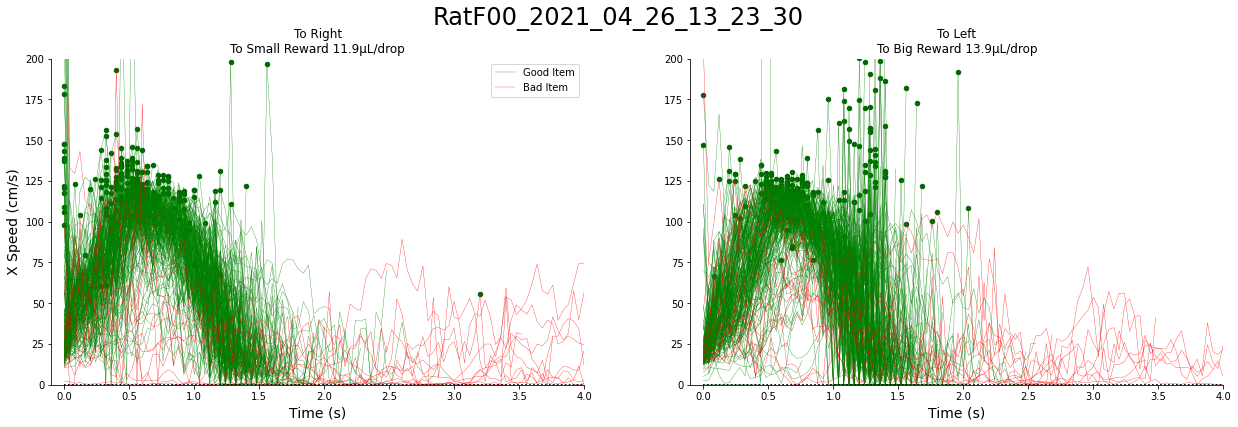

In [45]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        plot_figSpeed([good_instantSpeedRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_timeRunToRight[animal, session], good_instantSpeedLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_timeRunToLeft[animal, session], [],[],[],[],[],[],[],[]], animal, session)

In [46]:
#same function as before but we have to modify a few axes values
def plot_behavPos2(data, animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(21, 6))
    plt.suptitle(session, y= 1, fontsize = 24)
    widths, heights = [5, 5, 1, 5, 5], [6]
    rows, cols = 1, 5
    spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
    index=0
    sub = spec[0,2].subgridspec(2,1)

    for row in range(rows):
        for col in range(cols):
            ax=fig.add_subplot(spec[row, col])              
            if index == 0:
                plot_tracks(animal, session, data[0], data[1], data[2], data[3], index, params[animal, session]["boundaries"], xylim = [-0.1, 4, 0, 120], xyLabels=["Time (s)","X Position (cm)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1
            elif index ==1:
                plot_tracks(animal, session, data[4], data[5], data[6], data[7], index, params[animal, session]["boundaries"], xylim = [-0.1, 4, 0, 120], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1
            elif index ==2:
                blank_plot()
                index+=1
            elif index ==3:
                plot_tracks(animal, session, data[8], data[9], data[10], data[11], index, params[animal, session]["boundaries"], xylim = [-1, 5, 80, 120], xyLabels=["Time (s)","X Position (cm)", 14, 12], title=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1
            elif index ==4:
                plot_tracks(animal, session, data[12], data[13], data[14], data[15], index, params[animal, session]["boundaries"], xylim = [-1, 5, 0, 40], xyLabels=["Time (s)","", 14, 12], title=["In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
                index+=1

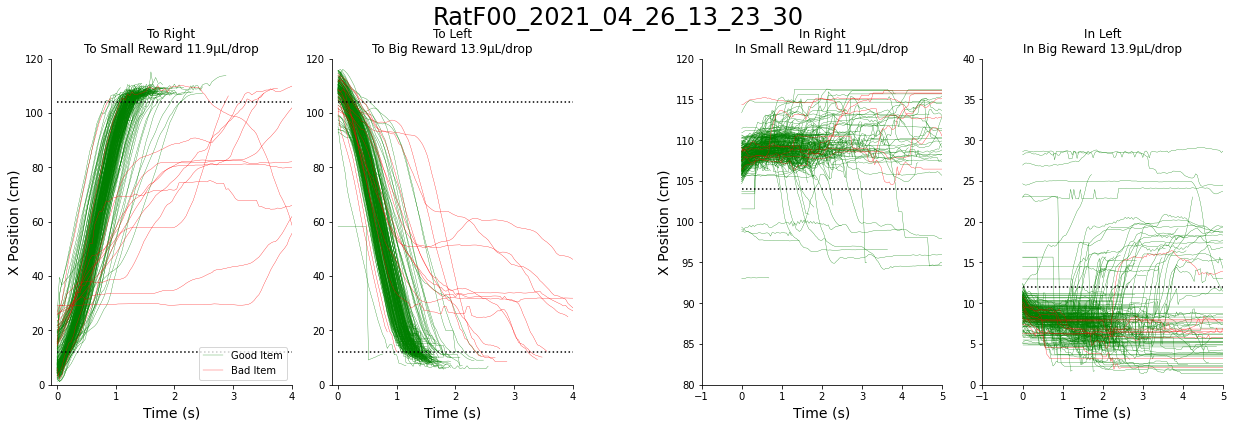

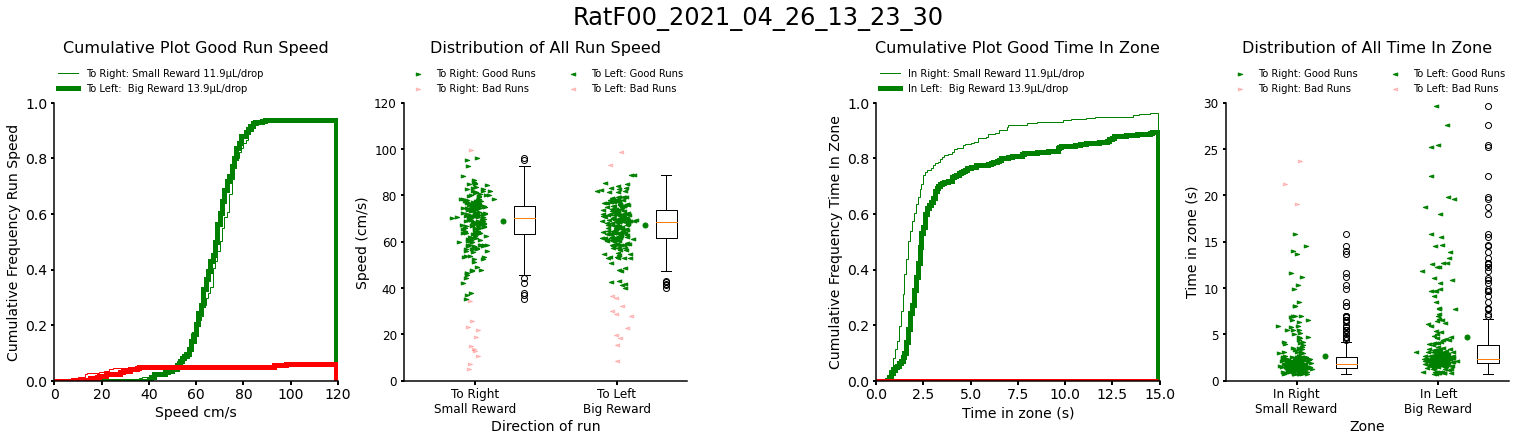

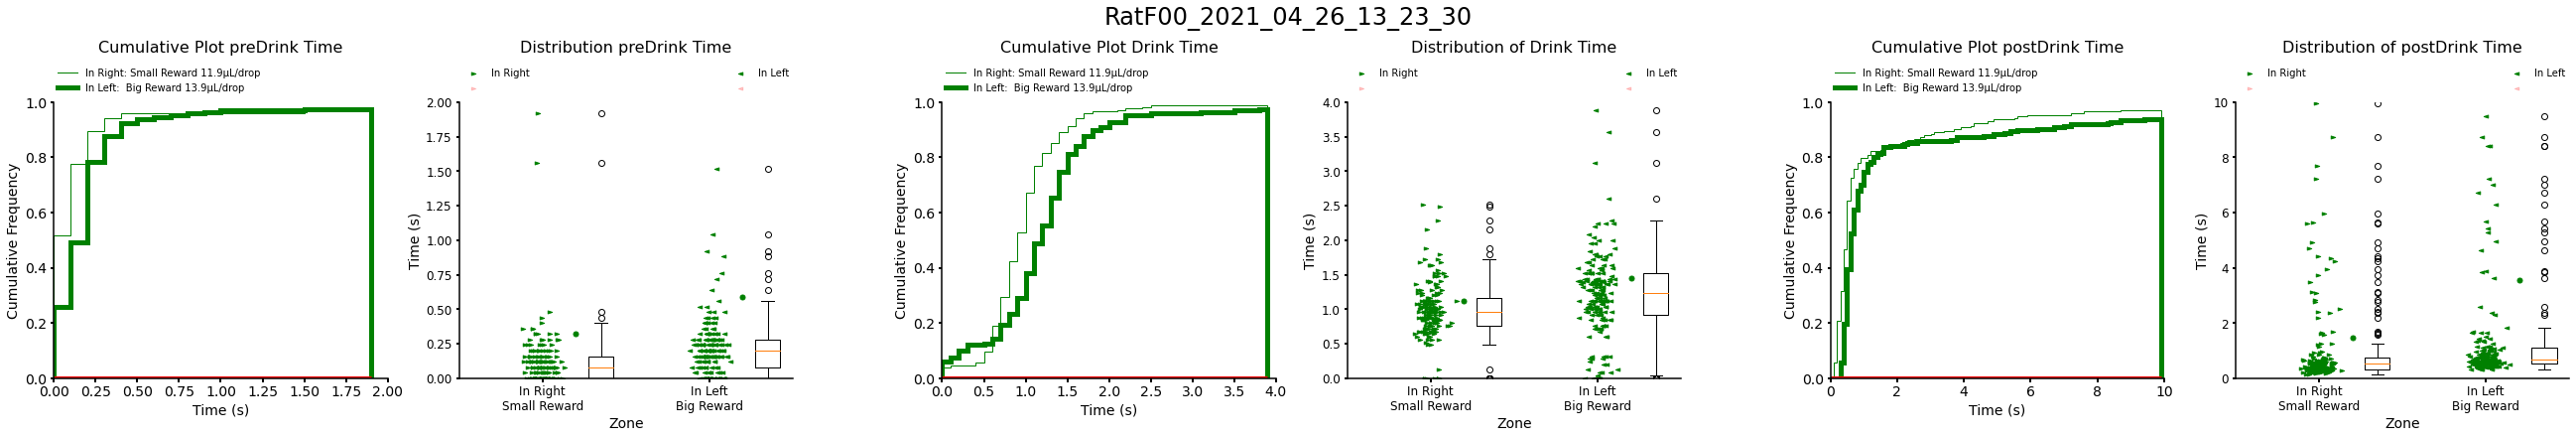

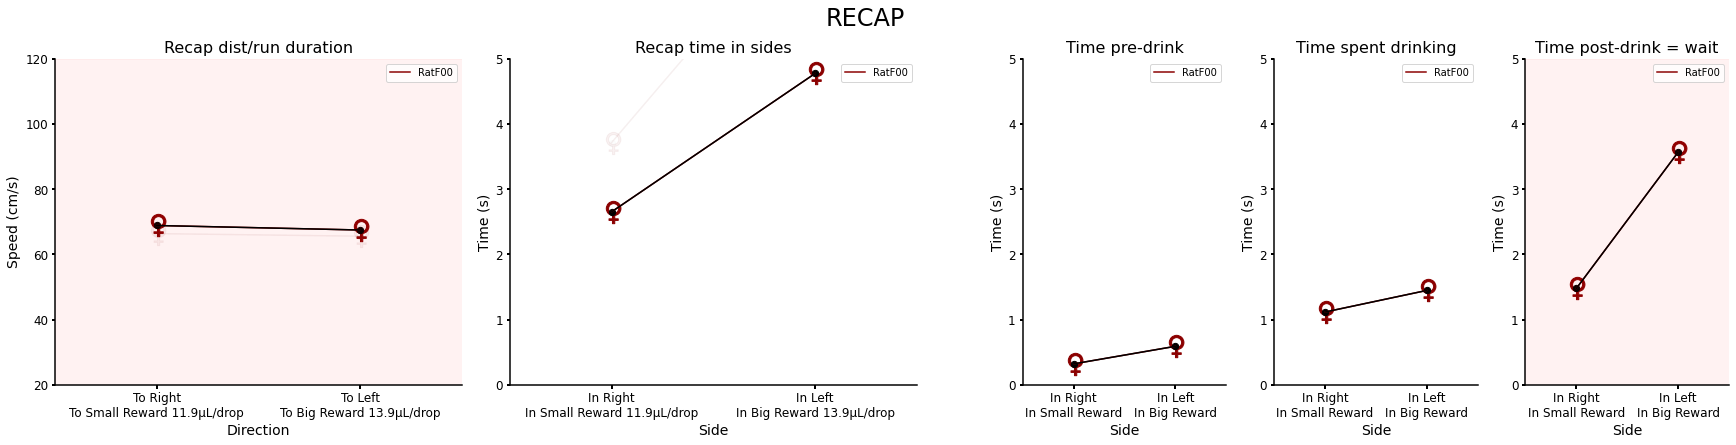

In [47]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        plot_behavPos2([good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], good_XtrackStayInRight[animal, session], good_TtrackStayInRight[animal, session], bad_XtrackStayInRight[animal, session], bad_TtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], good_TtrackStayInLeft[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInLeft[animal, session]], animal, session)
        plot_baseBehav([good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session]], animal, session, title = session)
        plot_lickData([lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], lick_waitRight[animal, session], lick_waitLeft[animal, session], [], []], animal, session, title = session)
plot_recapBehav([good_speedRunToRight, good_speedRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, good_timeStayInRight, good_timeStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, lick_arrivalRight, lick_arrivalLeft, [], [], lick_drinkingRight, lick_drinkingLeft, [], [], lick_waitRight, lick_waitLeft, [], []], animal, session)

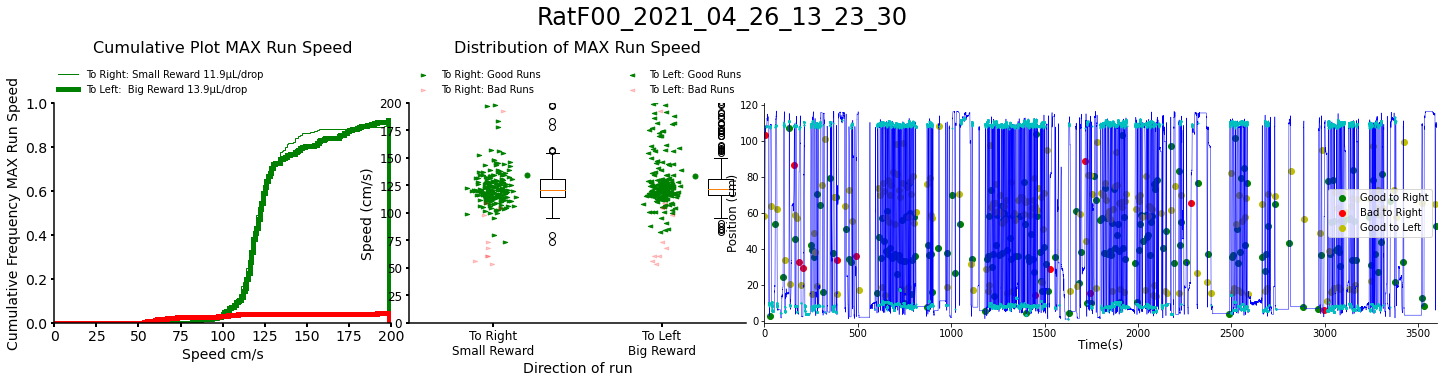

In [48]:
for animal in animalList:
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]:
        fig = plt.figure(constrained_layout = False, figsize=(20, 5))
        plt.suptitle(session, y= 1, fontsize = 24)
        widths, heights = [5, 5, 10], [6]
        rows, cols = 1, 3
        spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
        index=0
        for row in range(rows):
            for col in range(cols):
                ax=fig.add_subplot(spec[row, col])              
                if index == 0:
                    cumul_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 200, 0, 1], maxminstepbin = [0,200,1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["Cumulative Plot MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                    index+=1
                elif index ==1:
                    distribution_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 200], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                    index+=1
                elif index ==2:  
                    plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft1X[animal, session], rawLickRight1X[animal, session], [0, 3600,1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
                    for item in good_maxSpeedRight[animal, session]: plt.scatter(item[2], item[1], c='g', label = "Good to Right" if item == good_maxSpeedRight[animal, session][0] else "")
                    for item in bad_maxSpeedRight[animal, session]: plt.scatter(item[2], item[1], c='r', label = "Bad to Right" if item == bad_maxSpeedRight[animal, session][0] else "")
                    for item in good_maxSpeedLeft[animal, session]: plt.scatter(item[2], item[1], c='y', label = "Good to Left" if item == good_maxSpeedLeft[animal, session][0] else "")
                    for item in bad_maxSpeedLeft[animal, session]: plt.scatter(item[2], item[1], c='r', label = "Bad to Left" if item == bad_maxSpeedLeft[animal, session][0] else "")
                    plt.legend()

(195.0, 205.0)

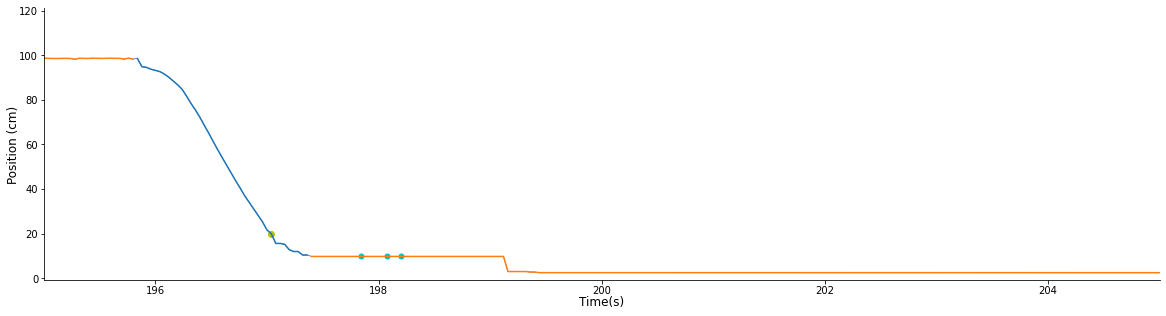

In [49]:
# This function plots the base trajectory of the rat. Parameters are time : time data, position : X position data, lickL/R, lick data, maxminstep for x and y axis, color and marker of the plot, width of the axis, and x y labels
def plot_BASEtrajectory(time, position, lickLeft, lickRight, maxminstep, maxminstep2, color = [], marker = [], linewidth = [], xyLabels=["N","Bins"]):   
        #select data that we want to plot
        plt.plot(time, position, color=color[0], marker=marker[0], linewidth = linewidth[0])#easy time againt position of the animal
        plt.plot(time, [None if x == 0 else x for x in lickLeft], color=color[1], marker=marker[1], markersize = marker[2])#lick data, plot position in which the animal licked, NoLick = we don't care so None
        plt.plot(time, [None if x == 0 else x for x in lickRight], color=color[1], marker=marker[1], markersize = marker[2])
        #configure plot
        ax0 = plt.gca()
        #configure ax xy span
        ax0.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
        ax0.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
        #configure xy style
        ax0.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
        ax0.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
        ax0.xaxis.set_ticks_position('bottom')
        ax0.yaxis.set_ticks_position('left')
        ax0.get_xaxis().set_tick_params(direction='out',pad=2)
        ax0.get_yaxis().set_tick_params(direction='out',pad=2)
        #remove unnecessary axes
        ax0.spines['top'].set_color("none")
        ax0.spines['right'].set_color("none")
        return ax0
fig = plt.figure(constrained_layout = False, figsize=(20, 5))
plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft1X[animal, session], rawLickRight1X[animal, session], [0, 3600,1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 5], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
plt.plot(rawTime[animal, session], goodPos[animal, session])
plt.plot(rawTime[animal, session], badPos[animal, session])
for item in good_maxSpeedRight[animal, session]: plt.scatter(item[2], item[1], c='g', label = "Good to Right" if item == good_maxSpeedRight[animal, session][0] else "")
for item in bad_maxSpeedRight[animal, session]: plt.scatter(item[2], item[1], c='r', label = "Bad to Right" if item == bad_maxSpeedRight[animal, session][0] else "")
for item in good_maxSpeedLeft[animal, session]: plt.scatter(item[2], item[1], c='y', label = "Good to Left" if item == good_maxSpeedLeft[animal, session][0] else "")
for item in bad_maxSpeedLeft[animal, session]: plt.scatter(item[2], item[1], c='r', label = "Bad to Left" if item == bad_maxSpeedLeft[animal, session][0] else "")
plt.xlim(195, 205)

In [50]:
def extract_speedCharacteristics(animal, session, good_PosdataRight, good_pos, good_TimedataRight, bad_PosdataRight, bad_pos, bad_TimedataRight, treadmillSpeed):
    good_maxspeed, good_maxspeedCorrected, good_maxTime, good_maxPos, bad_maxspeed, bad_maxspeedCorrected, bad_maxTime, bad_maxPos = ([] for i in range(8))
    for i, j, m in zip(good_PosdataRight, good_TimedataRight, good_pos):
        time = np.subtract(j, j[0])
        i_abs =  [abs(ele) for ele in i]
        if len(np.where(i == max(i))[0]) == 1:
            maxspeed = max(i_abs)
            maxspeedtime = np.where(i_abs == maxspeed)[0]
            if all(v == treadmillSpeed[0] for v in treadmillSpeed):
                good_maxspeedCorrected.append(maxspeed - treadmillSpeed[0])#max speed corrected
            else:
                print("not yet implemented")
            good_maxspeed.append(maxspeed)#max speed 
            good_maxTime.append(float(time[maxspeedtime])) #when maxspeed
            good_maxPos.append(m[int(maxspeedtime)] - m[0] if m[0] < m[int(maxspeedtime)] else m[0] - m[int(maxspeedtime)]) #where maxspeed
        else:
            print(max(i))
            good_maxspeed.append(None)
            good_maxTime.append(None)
            good_maxPos.append(None)

    for k, l, n in zip(bad_PosdataRight, bad_TimedataRight, bad_pos):
        time = np.subtract(l, l[0])
        k_abs =  [abs(ele) for ele in k]
        if len(np.where(k == max(k))[0]) == 1:
            maxspeed = max(k_abs)
            maxspeedtime = np.where(k_abs == maxspeed)[0]
            if all(v == treadmillSpeed[0] for v in treadmillSpeed):
                bad_maxspeedCorrected.append(maxspeed - treadmillSpeed[0])#max speed corrected
            else:
                print("not yet implemented")
            bad_maxspeed.append(maxspeed)#max speed 
            bad_maxTime.append(float(time[maxspeedtime])) #when maxspeed
            bad_maxPos.append(n[int(maxspeedtime)] - n[0] if n[0] < n[int(maxspeedtime)] else n[0] - n[int(maxspeedtime)]) #where maxspeed
        else:
            print(max(k))
            bad_maxspeed.append(None)
            bad_maxTime.append(None)
            bad_maxPos.append(None)  
    return good_maxspeed, good_maxPos, good_maxTime, bad_maxspeed, bad_maxPos, bad_maxTime, good_maxspeedCorrected, bad_maxspeedCorrected


speedToRightCharacteristics, speedToLeftCharacteristics = {}, {}
for animal in animalList:
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]:

        speedToRightCharacteristics[animal, session] = extract_speedCharacteristics(animal, session, good_instantSpeedRight[animal, session], good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], params[animal, session]['treadmillSpeed'])
        speedToLeftCharacteristics[animal, session] = extract_speedCharacteristics(animal, session, good_instantSpeedLeft[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], params[animal, session]['treadmillSpeed'])

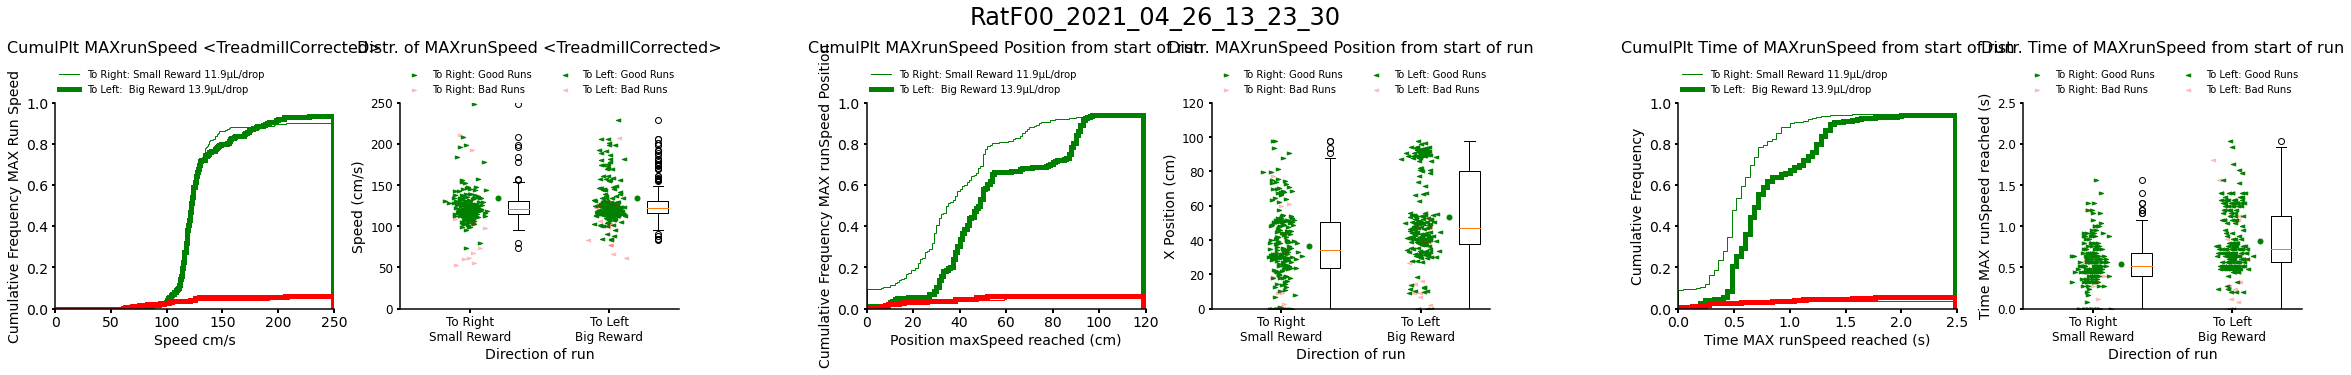

In [51]:
#plot max speed analysis
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        fig = plt.figure(constrained_layout = False, figsize=(32, 5))
        plt.suptitle(session, y= 1, fontsize = 24)
        widths, heights = [5, 5, 1, 5, 5, 1, 5, 5], [6]
        rows, cols = 1, 8
        spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
        index=0
        for row in range(rows):
            for col in range(cols):
                ax=fig.add_subplot(spec[row, col])
                #maxspeed corrected              
                if index == 0:
                    #treadmill speed not taken in account
                    #cumul_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                    #treadmill corrected speed
                    cumul_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                    index+=1
                elif index == 1:
                    #no TM speed
                    #distribution_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                    #treadmill corrected speed
                    distribution_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                    index+=1
                elif index == 2:
                    blank_plot()
                    index+=1
                #where maxspeed
                elif index == 3:
                    cumul_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0, 120, 1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Position maxSpeed reached (cm)", "Cumulative Frequency MAX runSpeed Position", 14, 12], title=["CumulPlt MAXrunSpeed Position from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                    index+=1
                elif index == 4:
                    distribution_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 120], xyLabels=["X Position (cm)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. MAXrunSpeed Position from start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                    index+=1
                elif index == 5:
                    blank_plot()
                    index+=1
                #when maxspeed
                elif index == 6:
                    cumul_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 2.5, 0, 1], maxminstepbin = [0, 2.5, 0.04], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Time MAX runSpeed reached (s)","Cumulative Frequency", 14, 12], title=["CumulPlt Time of MAXrunSpeed from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                    index+=1
                elif index == 7:
                    distribution_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 2.5], xyLabels=["Time MAX runSpeed reached (s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. Time of MAXrunSpeed from start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                    index+=1
                    

# TIMEBINS

In [52]:
def extract_runSpeedBin(dataPos, dataSpeed, dataTime, dataLickR, dataLickL, mask, animal, session, boundary, limspeed, hasLick):
    runs = {}
    stays = {}
    runs[animal, session] = {}
    stays[animal, session] = {}
    position, speed, time, goodPos, badPos, goodSpeed, badSpeed, goodTime, badTime = ({bin : [] for bin in range(0, len(params[animal, session]['blocks']))} for i in range(9))

    all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({bin : [] for bin in range(0, len(params[animal, session]['blocks']))} for i in range(50))

    for i in range(0, len(params[animal, session]['blocks'])):
        position[i] = np.array(dataPos[animal, session][i], dtype = float)
        speed[i] = np.array(dataSpeed[animal, session][i], dtype = float)
        time[i] = np.array(dataTime[animal, session][i], dtype = float)
        #print(mask[animal, session][i])

        goodPos[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(position[i], mask[animal, session][i])]]
        badPos[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(position[i], mask[animal, session][i])]]
        goodSpeed[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(speed[i], mask[animal, session][i])]]
        badSpeed[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(speed[i], mask[animal, session][i])]]
        goodTime[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(time[i], mask[animal, session][i])]]
        badTime[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(time[i], mask[animal, session][i])]]

        stays[animal, session][i] = [[e[0], e[1], e[2], e[3], e[4]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k, l, m] for i, j, k, l, m in zip(goodPos[i], goodSpeed[i], goodTime[i], dataLickR[animal, session][i], dataLickL[animal, session][i])]]
        runs[animal, session][i] = [[e[0], e[1], e[2]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k] for i, j, k, in zip(badPos[i], badSpeed[i], badTime[i])]]

        for run in split_a_list_at_zeros(runs[animal, session][i]):

            #calculate distance run as the distance between first and last value
            distanceRun = abs(run[0][0]-run[-1][0])

            #calculate time as sum of time interval between frames
            totaltimeRun = []
            xTrackRun = []
            instantSpeed = []
            maxSpeed = []
            for item in run:
                xTrackRun.append(item[0])
                instantSpeed.append(abs(item[1]))
                totaltimeRun.append(item[2])
            speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
            maxSpeed = [max(instantSpeed), xTrackRun[np.argmax(instantSpeed)], totaltimeRun[np.argmax(instantSpeed)]] #[max speed reached during the run, where it was reached, and when]
            #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
            if run[0][0] < ((boundary[0]+boundary[1])/2):
                #check if the subsplit is ending on the other side -> determine if this is a run 
                if run[-1][0] > ((boundary[0]+boundary[1])/2):
                    #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                    #second pass : there is a computed limspeed, use it to sort good and bad runs
                    if limspeed[0] is not None:
                        #check if this is a good or bad run and assign im to the good or bad array accordingly
                        if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]:
                            #good run array
                            good_speedRunToRight[i].append(speedRun)
                            good_XtrackRunToRight[i].append(xTrackRun)
                            good_timeRunToRight[i].append(totaltimeRun)  
                            good_instantSpeedRight[i].append(instantSpeed) 
                            good_maxSpeedRight[i].append(maxSpeed)
                        else:
                            #bad run array
                            bad_speedRunToRight[i].append(speedRun)
                            bad_XtrackRunToRight[i].append(xTrackRun)
                            bad_timeRunToRight[i].append(totaltimeRun)
                            bad_instantSpeedRight[i].append(instantSpeed)
                            bad_maxSpeedRight[i].append(maxSpeed)
                    else:
                        #all runs array first pass
                        all_speedRunToRight[i].append(speedRun)
                        all_timeRunToRight[i].append(totaltimeRun)
                        all_instantSpeedRight[i].append(instantSpeed)
                        all_maxSpeedRight[i].append(maxSpeed)
            #same thing for the runs that go to the other side
            elif run[0][0]>((boundary[0]+boundary[1])/2):
                if run[-1][0]<((boundary[0]+boundary[1])/2):
                    if limspeed[1] is not None:
                        if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                            good_speedRunToLeft[i].append(speedRun)   
                            good_XtrackRunToLeft[i].append(xTrackRun)
                            good_timeRunToLeft[i].append(totaltimeRun)
                            good_instantSpeedLeft[i].append(instantSpeed) 
                            good_maxSpeedLeft[i].append(maxSpeed)
                        else:
                            bad_speedRunToLeft[i].append(speedRun)
                            bad_XtrackRunToLeft[i].append(xTrackRun)
                            bad_timeRunToLeft[i].append(totaltimeRun)
                            bad_instantSpeedLeft[i].append(instantSpeed)
                    else:
                        all_speedRunToLeft[i].append(speedRun)
                        all_timeRunToLeft[i].append(totaltimeRun)
                        all_instantSpeedLeft[i].append(instantSpeed)


        for stay in split_a_list_at_zeros(stays[animal, session][i]):
            tInZone = []
            xTrackStay = []
            lickR = []
            lickL = []
            for item in stay:
                xTrackStay.append(item[0])
                tInZone.append(item[2])
                lickR.append(item[3])
                lickL.append(item[4])
            totaltimeStay = np.sum(np.diff(tInZone))
            #first identify if the subsplit created is on the left or right by comparing to the middle
            if stay[0][0] > ((boundary[0]+boundary[1]) / 2):
                if hasLick == True: #put hasLick as a param
                    # if empty put in bad stay
                    if not all(v == 0 for v in lickR):
                        #bad_timeStayInRight[i].append(totaltimeStay)
                        #bad_XtrackStayInRight[i].append(xTrackStay)
                        #bad_TtrackStayInRight[i].append(tInZone)
                        #continue
                        pre = []
                        drink = []
                        post = []
                        for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                            pre.append(t)
                        for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                            drink.append(t)
                        for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                            post.append(t)
                        
                        #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)
                        lick_arrivalRight[i].append(np.sum(np.diff(pre)))
                        lick_drinkingRight[i].append(np.sum(np.diff(drink)))
                        lick_waitRight[i].append(np.sum(np.diff(post)))

                if limspeed[0] is not None:
                    if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:# and xTrackStay[0] > boundary[0] and xTrackStay[-1] > boundary[0]:
                        good_timeStayInRight[i].append(totaltimeStay)
                        good_XtrackStayInRight[i].append(xTrackStay)
                        good_TtrackStayInRight[i].append(tInZone)
                    else:
                        bad_timeStayInRight[i].append(totaltimeStay)
                        bad_XtrackStayInRight[i].append(xTrackStay)
                        bad_TtrackStayInRight[i].append(tInZone)
                else:
                    all_timeStayInRight[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)
        
            elif stay[0][0] < ((boundary[0] + boundary[1]) / 2):
                if hasLick == True: #put hasLick as a param
                    if not all(v == 0 for v in lickL):
                        #bad_timeStayInLeft[i].append(totaltimeStay)
                        #bad_XtrackStayInLeft[i].append(xTrackStay)
                        #bad_TtrackStayInLeft[i].append(tInZone)
                        #continue
                        preL = []
                        drinkL = []
                        postL = []
                        for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                            preL.append(t)
                        for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                            drinkL.append(t)
                        for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                            postL.append(t)

                        lick_arrivalLeft[i].append(np.sum(np.diff(preL)))
                        lick_drinkingLeft[i].append(np.sum(np.diff(drinkL)))
                        lick_waitLeft[i].append(np.sum(np.diff(postL)))

                if limspeed[1] is not None:
                    if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:# and xTrackStay[0] < boundary[1] and xTrackStay[-1] < boundary[1]:
                        good_timeStayInLeft[i].append(totaltimeStay)   
                        good_XtrackStayInLeft[i].append(xTrackStay)
                        good_TtrackStayInLeft[i].append(tInZone)
                    else:
                        bad_timeStayInLeft[i].append(totaltimeStay)
                        bad_XtrackStayInLeft[i].append(xTrackStay)
                        bad_TtrackStayInLeft[i].append(tInZone)
                else:
                    all_timeStayInLeft[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)

    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

In [53]:
redoExtractRunsBin_wSpeed = True
limspeedRunToRightBin, limspeedRunToLeftBin, limstayRightBin, limstayLeftBin, all_speedRunToRightBin, all_speedRunToLeftBin, all_timeRunToRightBin, all_timeRunToLeftBin, all_timeStayInRightBin, all_timeStayInLeftBin, all_TtrackStayInRightBin, all_TtrackStayInLeftBin, all_instantSpeedRightBin, all_instantSpeedLeftBin, all_maxSpeedRightBin, all_maxSpeedLeftBin, good_speedRunToRightBin, good_speedRunToLeftBin, good_XtrackRunToRightBin, good_XtrackRunToLeftBin, good_timeRunToRightBin, good_timeRunToLeftBin, bad_speedRunToRightBin, bad_speedRunToLeftBin, bad_XtrackRunToRightBin, bad_XtrackRunToLeftBin, bad_timeRunToRightBin, bad_timeRunToLeftBin, good_instantSpeedRightBin, good_instantSpeedLeftBin, good_maxSpeedRightBin, good_maxSpeedLeftBin, bad_instantSpeedRightBin, bad_instantSpeedLeftBin, bad_maxSpeedRightBin, bad_maxSpeedLeftBin, good_timeStayInRightBin, good_timeStayInLeftBin, good_XtrackStayInRightBin, good_XtrackStayInLeftBin, good_TtrackStayInRightBin, good_TtrackStayInLeftBin, bad_timeStayInRightBin, bad_timeStayInLeftBin, bad_XtrackStayInRightBin, bad_XtrackStayInLeftBin, bad_TtrackStayInRightBin, bad_TtrackStayInLeftBin, lick_arrivalRightBin, lick_drinkingRightBin, lick_waitRightBin, lick_arrivalLeftBin, lick_drinkingLeftBin, lick_waitLeftBin = ({} for i in range(54))

for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        picklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"behav_speedBin.p"
        if os.path.exists(picklePath) and (not redoExtractRunsBin_wSpeed):
            print(session, "pickled")
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session], limspeedRunToRightBin[animal, session], limspeedRunToLeftBin[animal, session], limstayRightBin[animal, session], limstayLeftBin[animal, session] = get_from_pickle(animal, session, name="behav_speedBin.p")[0:54]

        else:
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRight1X, binLickLeft1X, binMask, animal, session, params[animal, session]["boundaries"], [None, None], False)[0:12]
            
            #compute limspeed (speed below which we consider that the rats are not running, or spent too long in the sides) as the speeds below 2 st dev of the mean speed. can be changed #test confidence interval
            limspeedRunToRightBin[animal, session] = limspeedRunToRight[animal, session]
            limspeedRunToLeftBin[animal, session]  = limspeedRunToLeft[animal, session]
            limstayRightBin[animal, session]       = limstayRight[animal, session]
            limstayLeftBin[animal, session]        = limstayLeft[animal, session]
            #extract the run data (good/bad, to left/to right) 
            good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRight1X, binLickLeft1X, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[12:32]
            #extract the stay data (good/bad, in left/in right) 
            if params[animal, session]["hasLick"] == True:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRight1X, binLickLeft1X, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:50]

            if params[animal, session]["hasLick"] == False:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRight1X, binLickLeft1X, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:44]
                lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = [], [], [], [], [], []

            print(animal, "donecomputing")
            save_as_pickle([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session], limspeedRunToRightBin[animal, session], limspeedRunToLeftBin[animal, session], limstayRightBin[animal, session], limstayLeftBin[animal, session]], animal, session, "behav_speedBin.p")


RatF00 donecomputing


In [54]:
#pool data from all animals for each time bin #not pretty but way better than previous way of doing the same stuff
def poolbins(input_var, animal, session):
    out_var = {bin : [] for bin in range(0, len(params[animal, session]['blocks']))}
    for i in range(0, len(params[animal, session]['blocks'])):
        for animal in animalList:
            for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]:
                out_var[i].extend(input_var[animal, session][i])
    return out_var 

all_speedRunToRightPooledBin, all_speedRunToLeftPooledBin, all_timeRunToRightPooledBin, all_timeRunToLeftPooledBin, all_timeStayInRightPooledBin, all_timeStayInLeftPooledBin, all_TtrackStayInRightPooledBin, all_TtrackStayInLeftPooledBin, all_instantSpeedRightPooledBin, all_instantSpeedLeftPooledBin, all_maxSpeedRightPooledBin, all_maxSpeedLeftPooledBin, good_speedRunToRightPooledBin, good_speedRunToLeftPooledBin, good_XtrackRunToRightPooledBin, good_XtrackRunToLeftPooledBin, good_timeRunToRightPooledBin, good_timeRunToLeftPooledBin, bad_speedRunToRightPooledBin, bad_speedRunToLeftPooledBin, bad_XtrackRunToRightPooledBin, bad_XtrackRunToLeftPooledBin, bad_timeRunToRightPooledBin, bad_timeRunToLeftPooledBin, good_instantSpeedRightPooledBin, good_instantSpeedLeftPooledBin, good_maxSpeedRightPooledBin, good_maxSpeedLeftPooledBin, bad_instantSpeedRightPooledBin, bad_instantSpeedLeftPooledBin, bad_maxSpeedRightPooledBin, bad_maxSpeedLeftPooledBin, good_timeStayInRightPooledBin, good_timeStayInLeftPooledBin, good_XtrackStayInRightPooledBin, good_XtrackStayInLeftPooledBin, good_TtrackStayInRightPooledBin, good_TtrackStayInLeftPooledBin, bad_timeStayInRightPooledBin, bad_timeStayInLeftPooledBin, bad_XtrackStayInRightPooledBin, bad_XtrackStayInLeftPooledBin, bad_TtrackStayInRightPooledBin, bad_TtrackStayInLeftPooledBin, lick_arrivalRightPooledBin, lick_drinkingRightPooledBin, lick_waitRightPooledBin, lick_arrivalLeftPooledBin, lick_drinkingLeftPooledBin, lick_waitLeftPooledBin = ({} for i in range(50))

all_speedRunToRightPooledBin, all_speedRunToLeftPooledBin, all_timeRunToRightPooledBin, all_timeRunToLeftPooledBin, all_timeStayInRightPooledBin, all_timeStayInLeftPooledBin, all_TtrackStayInRightPooledBin, all_TtrackStayInLeftPooledBin, all_instantSpeedRightPooledBin, all_instantSpeedLeftPooledBin, all_maxSpeedRightPooledBin, all_maxSpeedLeftPooledBin, good_speedRunToRightPooledBin, good_speedRunToLeftPooledBin, good_XtrackRunToRightPooledBin, good_XtrackRunToLeftPooledBin, good_timeRunToRightPooledBin, good_timeRunToLeftPooledBin, bad_speedRunToRightPooledBin, bad_speedRunToLeftPooledBin, bad_XtrackRunToRightPooledBin, bad_XtrackRunToLeftPooledBin, bad_timeRunToRightPooledBin, bad_timeRunToLeftPooledBin, good_instantSpeedRightPooledBin, good_instantSpeedLeftPooledBin, good_maxSpeedRightPooledBin, good_maxSpeedLeftPooledBin, bad_instantSpeedRightPooledBin, bad_instantSpeedLeftPooledBin, bad_maxSpeedRightPooledBin, bad_maxSpeedLeftPooledBin, good_timeStayInRightPooledBin, good_timeStayInLeftPooledBin, good_XtrackStayInRightPooledBin, good_XtrackStayInLeftPooledBin, good_TtrackStayInRightPooledBin, good_TtrackStayInLeftPooledBin, bad_timeStayInRightPooledBin, bad_timeStayInLeftPooledBin, bad_XtrackStayInRightPooledBin, bad_XtrackStayInLeftPooledBin, bad_TtrackStayInRightPooledBin, bad_TtrackStayInLeftPooledBin, lick_arrivalRightPooledBin, lick_drinkingRightPooledBin, lick_waitRightPooledBin, lick_arrivalLeftPooledBin, lick_drinkingLeftPooledBin, lick_waitLeftPooledBin      = poolbins(all_speedRunToRightBin, animal, session), poolbins(all_speedRunToLeftBin, animal, session), poolbins(all_timeRunToRightBin, animal, session), poolbins(all_timeRunToLeftBin, animal, session), poolbins(all_timeStayInRightBin, animal, session), poolbins(all_timeStayInLeftBin, animal, session), poolbins(all_TtrackStayInRightBin, animal, session), poolbins(all_TtrackStayInLeftBin, animal, session), poolbins(all_instantSpeedRightBin, animal, session), poolbins(all_instantSpeedLeftBin, animal, session), poolbins(all_maxSpeedRightBin, animal, session), poolbins(all_maxSpeedLeftBin, animal, session), poolbins(good_speedRunToRightBin, animal, session), poolbins(good_speedRunToLeftBin, animal, session), poolbins(good_XtrackRunToRightBin, animal, session), poolbins(good_XtrackRunToLeftBin, animal, session), poolbins(good_timeRunToRightBin, animal, session), poolbins(good_timeRunToLeftBin, animal, session), poolbins(bad_speedRunToRightBin, animal, session), poolbins(bad_speedRunToLeftBin, animal, session), poolbins(bad_XtrackRunToRightBin, animal, session), poolbins(bad_XtrackRunToLeftBin, animal, session), poolbins(bad_timeRunToRightBin, animal, session), poolbins(bad_timeRunToLeftBin, animal, session), poolbins(good_instantSpeedRightBin, animal, session), poolbins(good_instantSpeedLeftBin, animal, session), poolbins(good_maxSpeedRightBin, animal, session), poolbins(good_maxSpeedLeftBin, animal, session), poolbins(bad_instantSpeedRightBin, animal, session), poolbins(bad_instantSpeedLeftBin, animal, session), poolbins(bad_maxSpeedRightBin, animal, session), poolbins(bad_maxSpeedLeftBin, animal, session), poolbins(good_timeStayInRightBin, animal, session), poolbins(good_timeStayInLeftBin, animal, session), poolbins(good_XtrackStayInRightBin, animal, session), poolbins(good_XtrackStayInLeftBin, animal, session), poolbins(good_TtrackStayInRightBin, animal, session), poolbins(good_TtrackStayInLeftBin, animal, session), poolbins(bad_timeStayInRightBin, animal, session), poolbins(bad_timeStayInLeftBin, animal, session), poolbins(bad_XtrackStayInRightBin, animal, session), poolbins(bad_XtrackStayInLeftBin, animal, session), poolbins(bad_TtrackStayInRightBin, animal, session), poolbins(bad_TtrackStayInLeftBin, animal, session), poolbins(lick_arrivalRightBin, animal, session), poolbins(lick_drinkingRightBin, animal, session), poolbins(lick_waitRightBin, animal, session), poolbins(lick_arrivalLeftBin, animal, session), poolbins(lick_drinkingLeftBin, animal, session), poolbins(lick_waitLeftBin, animal, session)

# plots

In [55]:
def plot_tracksBin(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, index, blocks, bounds, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], suptitle = [""], linewidth = 1): 
    plt.figure(figsize = [5*len(blocks), 5])
    for m in range(0, len(blocks)):
            
        plt.suptitle(suptitle[0], fontsize = suptitle[1])
        ax9 = plt.subplot(1, len(blocks), m+1)
        for i, j in zip(good_PosdataRight[m], good_TimedataRight[m]):
            plt.plot(np.subtract(j, j[0]), i, color='g' , linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] and index ==0 else "")
        for k, l in zip(bad_PosdataRight[m], bad_TimedataRight[m]):
            plt.plot(np.subtract(l, l[0]), k, color='r', linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] and index == 0 else "")

        ax9.set_title(title[0], fontsize = title[2])
        ax9.set_xlabel(xyLabels[0], fontsize = xyLabels[3])
        ax9.set_ylabel(xyLabels[1], fontsize = xyLabels[3])
        ax9.set_xlim([xylim[0], xylim[1]])
        ax9.set_ylim([xylim[2], xylim[3]])
        ax9.spines['top'].set_color("none")
        ax9.spines['right'].set_color("none")

In [56]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #plot_tracksBin(animal, session, good_XtrackRunToRightBin[animal, session], good_timeRunToRightBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_timeRunToRightBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-0.1, 2, 0/13.5, 1400/13.5, 0/13.5, 1400/13.5], xyLabels=["Run length (s)","X Position (cm)", 14, 12], title=["Run to Right", "Run to Left", 12], suptitle = [animal + " Run Tracks", 16], linewidth = [1.5])
            #plot_tracksBin(animal, session, good_XtrackRunToLeftBin[animal, session], good_timeRunToLeftBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToLeftBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-0.1, 2, 0/13.5, 1400/13.5, 0/13.5, 1400/13.5], xyLabels=["Run length (s)","X Position (cm)", 14, 12], title=["Run to Right", "Run to Left", 12], suptitle = [animal + " Run Tracks", 16], linewidth = [1.5])
            plt.show()

In [57]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #plot_tracksBin(animal, session, good_XtrackStayInRightBin[animal, session], good_TtrackStayInRightBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_TtrackStayInRightBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-2, 20, (params[animal, session]["boundaries"][0] - 5)/13.5, (params[animal, session]["boundaries"][0] + 130)/13.5, (params[animal, session]["boundaries"][1] - 130)/13.5, (params[animal, session]["boundaries"][1] + 5)/13.5], xyLabels=["Time in zone (s)","X Position (cm)", 14, 12], title=["Time in Right", "Time in Left", 12], suptitle = [animal + " Time in extremities", 16], linewidth = [1.5])
            #plot_tracksBin(animal, session, good_XtrackStayInLeftBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInLeftBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-2, 20, (params[animal, session]["boundaries"][0] - 5)/13.5, (params[animal, session]["boundaries"][0] + 130)/13.5, (params[animal, session]["boundaries"][1] - 130)/13.5, (params[animal, session]["boundaries"][1] + 5)/13.5], xyLabels=["Time in zone (s)","X Position (cm)", 14, 12], title=["Time in Right", "Time in Left", 12], suptitle = [animal + " Time in extremities", 16], linewidth = [1.5])
            plt.show()


In [58]:
rewardProba = {}
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            rewardProba[animal, session] = []
            for i, j in zip(params[animal, session]['rewardP_ON'], params[animal, session]['rewardP_OFF']):
                rewardProba[animal, session].append(i)
                rewardProba[animal, session].append(j)
rewardProba

{('RatF00', 'RatF00_2021_04_26_13_23_30'): [90,
  10,
  90,
  10,
  90,
  10,
  90,
  10,
  90,
  10,
  90,
  10]}

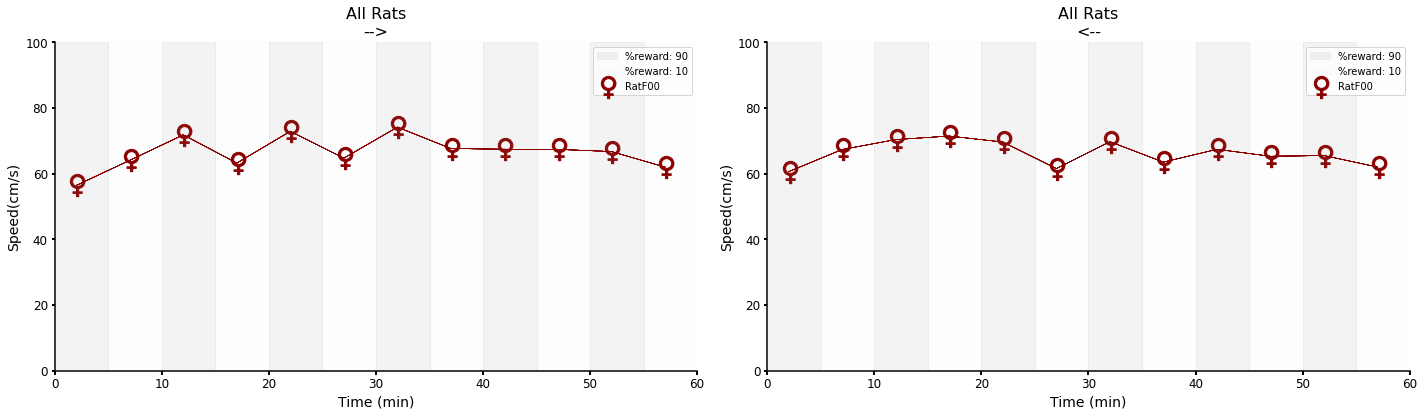

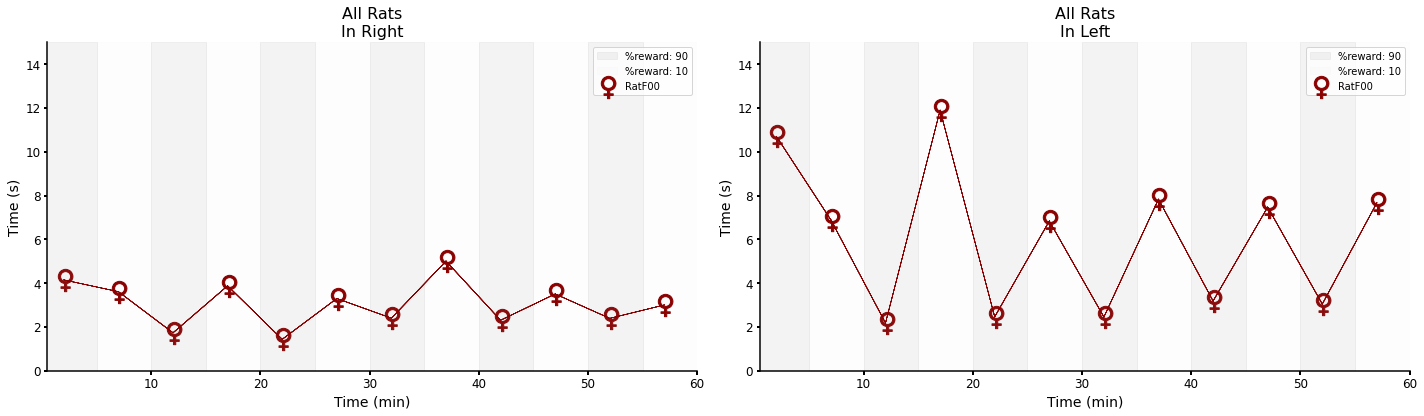

In [59]:
def plot_runSpeedBin(gooddataRight, gooddataLeft, baddataRight, baddataLeft, rewardProba, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    for i in range(0, len(blocks)):
        ax1 = plt.subplot(1,2,1)
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProba[i]/1000, label = "%reward: " + str(rewardProba[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataRight[i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = animal if (i==0) else "")
        #plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataRight[i]+baddataRight[i]), s=50, marker=rat_markers[animal][1], alpha = 0.5, color = rat_markers[animal][0],label = animal if i == 0 else "")
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataRight[i]), np.mean(gooddataRight[i+1])), color = rat_markers[animal][0], linewidth = 0.5)
            #plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataRight[i]+baddataRight[i]), np.mean(gooddataRight[i+1]+baddataRight[i+1])), alpha=0.5, color = rat_markers[animal][0], linewidth = 0.5)
        ax1.set_title(title[0], fontsize = title[3])
        ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax1.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax1.spines['bottom'].set_linewidth(linewidth[0])
        ax1.spines['left'].set_linewidth(linewidth[0])
        ax1.spines['top'].set_color("none")
        ax1.spines['right'].set_color("none")
        ax1.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()

    for i in range(0, len(blocks)):
        ax3 = plt.subplot(1,2,2)
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProba[i]/1000,  label = "%reward: " + str(rewardProba[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataLeft[i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = animal if (i==0) else "")
        #plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataLeft[i]+baddataLeft[i]), s=50, marker=rat_markers[animal][1], alpha = 0.5, color = rat_markers[animal][0],label = animal if i == 0 else "")
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataLeft[i]), np.mean(gooddataLeft[i+1])), color = rat_markers[animal][0], linewidth = 0.5)
            #plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataLeft[i]+baddataLeft[i]), np.mean(gooddataLeft[i+1]+baddataLeft[i+1])), alpha=0.5, color = rat_markers[animal][0], linewidth = 0.5)
        ax3.set_title(title[1], fontsize = title[3])
        ax3.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax3.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax3.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax3.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax3.spines['bottom'].set_linewidth(linewidth[0])
        ax3.spines['left'].set_linewidth(linewidth[0])
        ax3.spines['top'].set_color("none")
        ax3.spines['right'].set_color("none")
        ax3.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
    plt.tight_layout(pad=1.5)
    return plt

#SR BR
plt.figure(figsize = [20, 6])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            plot_runSpeedBin(good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], rewardProba[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 100], xyLabels=["Time (min)","Speed(cm/s)", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "-->", "All Rats"+"\n"+ "<--", "", 16], linewidth = [1.5])
plt.show()  

plt.figure(figsize = [20, 6])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            plot_runSpeedBin(good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], rewardProba[animal, session], params[animal, session]['blocks'], barplotaxes = [0.5, params[animal, session]['sessionDuration']/60, 0, 15], xyLabels=["Time (min)","Time (s)", "Time (min)", "Time (s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "In Right", "All Rats"+"\n"+ "In Left", "", 16], linewidth = [1.5])

plt.show()

In [60]:
def plot_runSpeedBinPooled(gooddataRight, gooddataLeft, baddataRight, baddataLeft, rewardProba, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):

    for i in range(0, len(blocks)):
        ax2 = plt.gca()
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProba[i]/1000, label = "%reward: " + str(rewardProba[i]) if (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataRight[i]), s=25, color = 'c', label = "Right" if i == 0 else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataLeft[i]), s=25, color = 'b', label = "Left" if i == 0 else "")
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataRight[i]), np.mean(gooddataRight[i+1])), color = 'c', linewidth = 0.5)
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataLeft[i]), np.mean(gooddataLeft[i+1])), color = 'b', linewidth = 0.5)
        
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataRight[i] + baddataRight[i]), s=25, color = 'c', label = "Right" if i == 0 else "", alpha = 0.1)
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(gooddataLeft[i] + baddataLeft[i]), s=25, color = 'b', label = "Left" if i == 0 else "", alpha = 0.1)
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataRight[i] + baddataRight[i]), np.mean(gooddataRight[i+1] + baddataRight[i+1])), color = 'c', linewidth = 0.5, alpha = 0.1)
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(gooddataLeft[i] + baddataLeft[i]), np.mean(gooddataLeft[i+1] + baddataLeft[i+1])), color = 'b', linewidth = 0.5, alpha = 0.1)

        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
        
    plt.tight_layout(pad=0.5)
    return plt

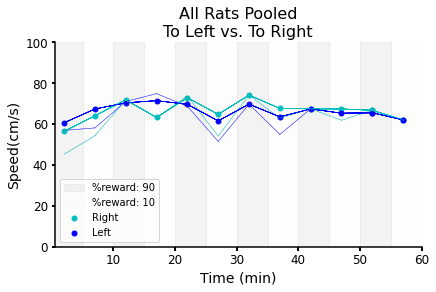

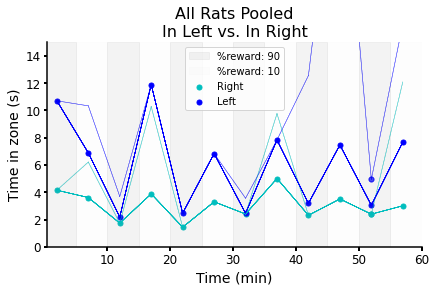

In [61]:
plot_runSpeedBinPooled(good_speedRunToRightPooledBin, good_speedRunToLeftPooledBin, bad_speedRunToRightPooledBin, bad_speedRunToLeftPooledBin, rewardProba[animal, session], params[animal, session]['blocks'], barplotaxes = [0.5, params[animal, session]['sessionDuration']/60, 0, 100], xyLabels=["Time (min)","Speed(cm/s)", "Time (min)", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "To Left vs. To Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()
plot_runSpeedBinPooled(good_timeStayInRightPooledBin, good_timeStayInLeftPooledBin, bad_timeStayInRightPooledBin, bad_timeStayInLeftPooledBin, rewardProba[animal, session], params[animal, session]['blocks'], barplotaxes = [0.5, params[animal, session]['sessionDuration']/60, 0, 15], xyLabels=["Time (min)","Time in zone (s)", "Time (min)", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "In Left vs. In Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()

# Number of runs per block

In [67]:
#compute number of runs per bin
nb_trials_to_right = {}#bin
nb_trials_to_left = {}
nb_trials = {}#per bin, maybe rename
total_trials = {}

for animal in animalList:
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]:
        print(session)
        nb_trials_to_right[animal, session] = {}
        nb_trials_to_left[animal, session] = {}  
        nb_trials[animal, session] = {}  
        total_trials[animal, session] = 0
        for i in range (0, len(params[animal, session]['blocks'])):
            nb_trials_to_right[animal, session][i] = []
            nb_trials_to_left[animal, session][i] = []
            nb_trials[animal, session][i] = []

            nb_trials_to_right[animal, session][i] = len(good_speedRunToRightBin[animal, session][i])
            nb_trials_to_left[animal, session][i] = len(good_speedRunToLeftBin[animal, session][i])
            nb_trials[animal, session][i] = len(good_speedRunToRightBin[animal, session][i]) + len(good_speedRunToLeftBin[animal, session][i])
            total_trials[animal, session] = total_trials[animal, session] + nb_trials[animal, session][i]
            #print("block", i+1, "trials: ", nb_trials[animal, session][i], "\t average per min: ", nb_trials[animal, session][i]/(int((params[animal, session]['blocks'][i][1]-params[animal, session]['blocks'][i][0])/60)))

poolR = {}
poolL = {}
pool = {}
for i in range(0, len(params[animal, session]['blocks'])):
    poolR[i] = []
    poolL[i] = []
    pool[i] = []
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            poolR[i].append(nb_trials_to_right[animal, session][i])
            poolL[i].append(nb_trials_to_left[animal, session][i])
            pool[i].append(nb_trials_to_right[animal, session][i]+nb_trials_to_left[animal, session][i])

RatF00_2021_04_26_13_23_30


In [68]:
for animal in animalList:
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]:
        print(total_trials[animal, session])

407


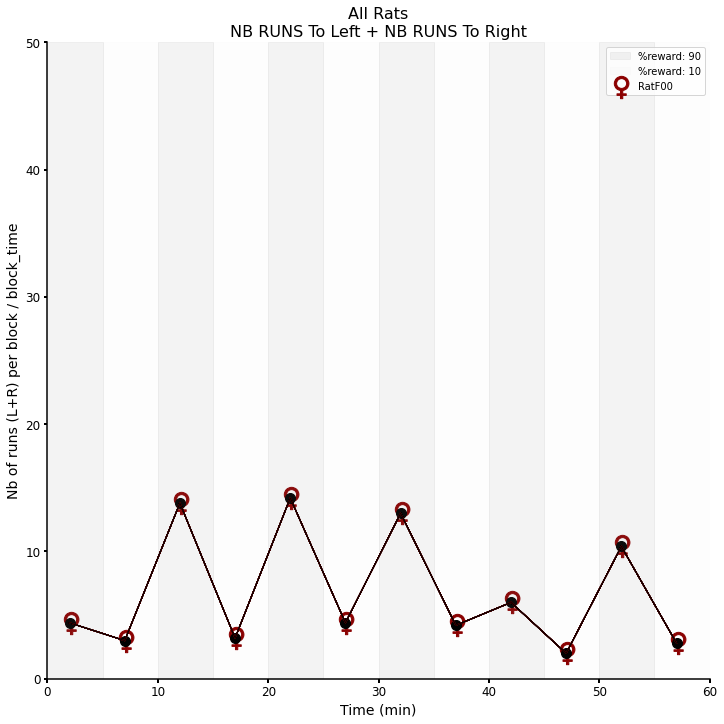

In [63]:
#plot one curve for left one for right
def plot_nbtrials(trialsR, trialsL, rewardProba, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):

    for i in range(0, len(blocks)):
        ax2 = plt.gca()
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProba[i]/1000, label = "%reward: " + str(rewardProba[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), trialsR[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), trialsL[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (trialsR[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), trialsR[animal, session][i+1]/(int((blocks[i][1]-blocks[i][0])/60))), color = rat_markers[animal][0], linewidth = 1, linestyle = '-.')
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (trialsL[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), trialsL[animal, session][i+1]/(int((blocks[i][1]-blocks[i][0])/60))), color = rat_markers[animal][0], linewidth = 1)

        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()

    plt.tight_layout(pad=0.5)
    return plt

#plot sum of left + right   
def plot_nbtrialsBin(trials, pool, rewardProba, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    for i in range(0, len(blocks)):
        ax2 = plt.gca()
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProba[i]/1000, label = "%reward: " + str(rewardProba[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        plt.scatter(np.full((1, 1), int((blocks[i][1] + blocks[i][0])/120)), np.mean(pool[i])/(int((blocks[i][1]-blocks[i][0])/60)), s=100, color = 'k', label = "Average" if i == 0 and animal == "RatM03" else "")
        for i in range(0, len(blocks)-1):
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), trials[animal, session][i+1]/(int((blocks[i+1][1]-blocks[i+1][0])/60))), color = rat_markers[animal][0], linewidth = 1)
            plt.plot((int((blocks[i][1] + blocks[i][0])/120), int((blocks[i+1][1] + blocks[i+1][0])/120)), (np.mean(pool[i])/(int((blocks[i][1]-blocks[i][0])/60)), np.mean(pool[i+1])/(int((blocks[i+1][1]-blocks[i+1][0])/60))), color = 'k', linewidth = 1)
        
        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()

    plt.tight_layout(pad=0.5)
    return plt

plt.figure(figsize = [10, 10])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #plot_nbtrials(nb_trials_to_right, nb_trials_to_left, rewardProba[animal, session], params[animal, session]['blocks'], barplotaxes = [0.5, params[animal, session]['sessionDuration']/60, 0, 20], xyLabels=["Time (min)","Nb of runs (R--, L..)", "Time (min)", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "To Left vs. To Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
            plot_nbtrialsBin(nb_trials, pool, rewardProba[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 50], xyLabels=["Time (min)","Nb of runs (L+R) per block / block_time", "Time (min)", "nb of trials left + right", "", "", 14, 12], title=["All Rats"+"\n"+ "NB RUNS To Left + NB RUNS To Right", "All Rats"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()


#not ordered in dict
for animal in animalList:
    i = 0
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]: 
        ax2 = plt.gca()
        plt.scatter(i, np.mean(list(nb_trials[animal, session].values())), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        i+=1
    print()

90


AttributeError: 'int' object has no attribute 'append'

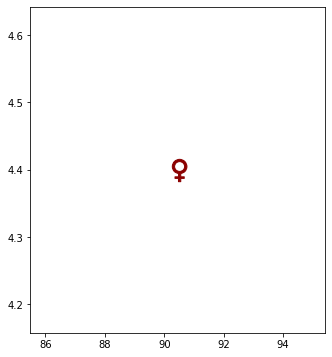

In [64]:
plt.figure(figsize = [18, 6])
for animal in animalList:
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]: 
        for i in range(0, len(params[animal, session]['blocks'])):
            print(rewardProba[animal, session][i])
            ax1 = plt.subplot(1,3,1)
            ax1.scatter(np.random.normal(rewardProba[animal, session][i], 1, 1), nb_trials[animal, session][i]/(int((params[animal, session]['blocks'][i][1]-params[animal, session]['blocks'][i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            a.append()
            ax2 = plt.subplot(1,3,2)
            ax2.scatter(np.random.normal(rewardProba[animal, session][i], 1, 1), np.mean(good_speedRunToRightBin[animal, session][i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            ax3 = plt.subplot(1,3,3)
            ax3.scatter(np.random.normal(rewardProba[animal, session][i], 1, 1), np.mean(good_speedRunToLeftBin[animal, session][i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        
        #print(nb_trials[animal, session][i::2])
        #ax1.scatter(20, np.mean(nb_trials[animal, session][::2]))
        #ax1.scatter(np.random.normal(rewardProba[animal, session][i]+5, 1, 1), np.mean(nb_trials[animal, session]/(int((params[animal, session]['blocks'][i][1]-params[animal, session]['blocks'][i][0])/60))), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        #ax2.scatter(np.random.normal(rewardProba[animal, session][i]+5, 1, 1), np.mean(good_speedRunToRightBin[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        #ax3.scatter(np.random.normal(rewardProba[animal, session][i]+5, 1, 1), np.mean(good_speedRunToLeftBin[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")

    ax1.set_xlim(-5, 105)
    ax1.set_ylim(-5, 20)
    ax1.set_xlabel("Reward probability", fontsize = 12)
    ax1.set_ylabel("number of crossings per block / block_time", fontsize = 12)
    ax2.set_xlim(-5, 105)
    ax2.set_ylim(20, 100)
    ax2.set_xlabel("Reward probability", fontsize = 12)
    ax2.set_ylabel("average speed to right per block (cm/s)", fontsize = 12)
    ax3.set_xlim(-5, 105)
    ax3.set_ylim(20, 100)
    ax3.set_xlabel("Reward probability", fontsize = 12)
    ax3.set_ylabel("average speed to left per block (cm/s)", fontsize = 12)

In [ ]:
print(rewardProba[animal, session][::2])

# test donut

In [ ]:
plt.figure(figsize = [20, 5])
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.figure(figsize = [30, 5])
        print(animal, session)
        plt.plot(rawPositionX[animal, session],rawPositionY[animal, session],[0,120,1],[0,15,1], linewidth=0.1)
        plt.plot([None if x == 0 else x for x in rawLickLeft1X[animal, session]],rawPositionY[animal, session],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)
        #plt.plot([None if x == 0 else x for x in rawLickRight1X[animal, session]],rawPositionY[animal, session],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)

In [ ]:
#donut for each block
"""plt.figure(figsize = [20, 5])
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        for i in range(0, len(params[animal, session]['blocks'])):
            plt.figure(figsize = [30, 5])
            print(animal, session)
            plt.plot(binPositionX[animal, session][i], binPositionY[animal, session][i],[0,120,1],[0,15,1], linewidth=0.1)
            plt.plot([None if x == 0 else x for x in binLickLeft1X[animal, session][i]],binPositionY[animal, session][i],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)
            plt.plot([None if x == 0 else x for x in binLickRight1X[animal, session][i]],binPositionY[animal, session][i],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)"""

# weight

In [ ]:
plt.figure(figsize = [6, 8])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            
            xline = [params[animal, session]["weight"], params[animal, session]["weight"]]
            yline = [np.mean(good_speedRunToRight[animal, session]),np.mean(good_speedRunToLeft[animal, session])]
            
            plt.xlabel('Rat Weight (g)')
            plt.ylabel('speed(cm/s)')
            plt.title('Effect of weight on speed')

            plt.scatter(params[animal, session]["weight"], np.mean(good_speedRunToRight[animal, session]), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "toRight")
            plt.scatter(params[animal, session]["weight"], np.mean(good_speedRunToLeft[animal, session]), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "toLeft")
            plt.scatter(params[animal, session]["weight"], abs(np.mean(good_speedRunToRight[animal, session]) - np.mean(good_speedRunToLeft[animal, session])), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "|Right-left|")
            plt.plot(xline, yline, ":", color='k')
            plt.axis([100, 500, 0, 80 ])
            plt.legend()

# Bin POs

In [ ]:
for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.figure(figsize = [20, 5])
        print(animal, session)
        for i in range(len(params[animal, session]['blocks'])):
            #plot_BASEtrajectory(binTime[animal, session][i],binPositionX[animal, session][i], np.zeros(len(binPositionX[animal, session][i])), np.zeros(len(binPositionX[animal, session][i])), [0,1800,1],[0,1400,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
            plt.show();

# bug time

In [ ]:
a = np.diff(rawTime[animal, session])
def movinavg(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')
plt.plot(a, label = "data")
plt.plot(movinavg(a, 100), label="moving average")

plt.xlim(0, len(a))
plt.ylim(0, 0.1)
plt.xlabel("frame index")
plt.ylabel("time per frame (s)")
plt.legend()

In [ ]:
ON = {}
OFF = {}
for animal in animalList:
    for session in [os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]: 
        ON[animal, session] = []
        OFF[animal, session] = []      
        print("nb valve openings L-R", len(split_a_list_at_zeros(solenoid_ON_Left[animal, session])), "+", len(split_a_list_at_zeros(solenoid_ON_Right[animal, session])), "=", len(split_a_list_at_zeros(solenoid_ON_Left[animal, session])) + len(split_a_list_at_zeros(solenoid_ON_Right[animal, session])))
        print("qty water L-R", len(split_a_list_at_zeros(solenoid_ON_Left[animal, session]))*params[animal, session]["waterLeft"], "+", len(split_a_list_at_zeros(solenoid_ON_Right[animal, session]))*params[animal, session]["waterRight"], "=", len(split_a_list_at_zeros(solenoid_ON_Left[animal, session]))*params[animal, session]["waterLeft"] + len(split_a_list_at_zeros(solenoid_ON_Right[animal, session]))*params[animal, session]["waterRight"])
        #print("nb licks L-R", len(lick_waitLeft[animal, session]), "+", len(lick_waitRight[animal, session]), "=", len(lick_waitLeft[animal, session]) + len(lick_waitRight[animal, session]))
        print(total_trials[animal, session])
        for i in range(0, len(params[animal, session]['blocks'])):
            if i%2 == 0:#change %2 with values in params
                ON[animal, session].append(nb_trials[animal, session][i])
            if i%2 == 1:
                OFF[animal, session].append(nb_trials[animal, session][i])
        print("nb trials ON-OFF", sum(ON[animal, session]), sum(OFF[animal, session]))#sum of nb trial ON, sum of nb trials OFF
        print("expected reward",sum(ON[animal, session])*0.9, sum(OFF[animal, session])*0.1)#sum of nb trial ON, sum of nb trials OFF
        print()

# TODOLIST


In [ ]:
###TODO###
#convert position to cm cleaner
#comments
#explain how data is processed
#explore weight effect and evolution /speed /peakspeed /number of runs
#do something with number of runs
#look for instant speed inside the identified runs --> see if both methods give the same result
#look for peak speed
#!!!!!!!evolution of speed in the session
#smooth position ?
#runs +extremities on one plot
#generate html/pdf recap+stats
#pickle useful data
#compare between days
#lickdata
#lick data --> waiting time
#add stats on figs
#noise videotrack / improve videotrack
#Investigate change in speed during a single session (hypothese [case reward size is the same for leftward or rightward trials] : speed should go down ?; [case reward size is diffrent for leftward and rightward trials]: does speed slow down more quickly for left or right runs ?
#test median
#BIG/small on figs
#problem with time............
#average track per animal/group 
#specify analysis groups for stats
#analyse training data
#analyse /2 data
#clean graphes for talk 
#stats timeBins
#spread in scatter plot proportional to density
#fix time bins
#scatterplot xes not used in distrib, maxminstep bin not used in scatter plot when plotting runs

##DONE##
#######see git log for DONE

In [ ]:
>errorstop

# Graphes inter sessions

# Clean That

In [ ]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        print([animal, session])

In [ ]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        print("['" +animal+ "\',\'" +session + "\']")

In [ ]:
sessionList60cm = [
['RatF00','RatF00_2020_08_30_14_01_32'], ['RatF00','RatF00_2020_08_26_12_37_41'],
['RatF01','RatF01_2020_08_26_13_19_04'], ['RatF01','RatF01_2020_08_30_14_33_21'],
['RatF02','RatF02_2020_08_30_15_11_56'], ['RatF02','RatF02_2020_08_26_13_54_39'],
['RatF03','RatF03_2020_08_26_14_25_56'], ['RatF03','RatF03_2020_08_30_15_43_21'],
['RatM00','RatM00_2020_08_29_15_30_16'], ['RatM00','RatM00_2020_08_27_14_51_35'],
['RatM01','RatM01_2020_08_29_16_02_14'],
['RatM02','RatM02_2020_08_27_16_07_40'], ['RatM02','RatM02_2020_08_29_17_01_08'],
['RatM03','RatM03_2020_08_29_17_33_03'], ['RatM03','RatM03_2020_08_27_16_39_19']]

sessionList90cm = [
['RatF00','RatF00_2020_08_25_12_30_23'],
['RatF01','RatF01_2020_08_25_13_01_41'],
['RatF02','RatF02_2020_08_25_13_33_24'],
['RatF03','RatF03_2020_08_25_14_04_38'],
['RatM00','RatM00_2020_08_25_14_42_40'],
['RatM01','RatM01_2020_08_25_15_16_13'],
['RatM02','RatM02_2020_08_25_15_47_30'],
['RatM03','RatM03_2020_08_25_16_19_00']]

sessionList120cm = [
['RatF00','RatF00_2020_08_29_13_12_25'], ['RatF00','RatF00_2020_08_27_12_28_15'],
['RatF01','RatF01_2020_08_27_13_04_29'], ['RatF01','RatF01_2020_08_29_13_44_02'],
['RatF02','RatF02_2020_08_29_14_19_56'], ['RatF02','RatF02_2020_08_27_13_35_41'],
['RatF03','RatF03_2020_08_27_14_07_57'], ['RatF03','RatF03_2020_08_29_14_51_53'],
['RatM00','RatM00_2020_08_30_16_23_05'], ['RatM00','RatM00_2020_08_26_15_12_46'],
['RatM01','RatM01_2020_08_30_16_54_32'], ['RatM01','RatM01_2020_08_26_15_44_08'],
['RatM02','RatM02_2020_08_30_17_25_55'], ['RatM02','RatM02_2020_08_26_16_25_57'],
['RatM03','RatM03_2020_08_26_16_57_27'], ['RatM03','RatM03_2020_08_30_17_57_40']]

In [ ]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L = [], [], [], [], [], []
    for animal, session in sessionList60cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 1, linestyle = ':')
    avg1R.append(gooddataRight[animal, session])       
    avg1L.append(gooddataLeft[animal, session])  
    plt.scatter(0.95, np.mean(avg1R), s=40, color ='k')
    plt.scatter(2.05, np.mean(avg1L), s=40, color ='k')
    plt.plot((0.95, 2.05), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 1, linestyle = ':')

    for animal, session in sessionList120cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 4, linestyle = '--')
    avg2R.append(gooddataRight[animal, session])       
    avg2L.append(gooddataLeft[animal, session])  
    plt.scatter(0.95, np.mean(avg2R), s=40, color ='k')
    plt.scatter(2.05, np.mean(avg2L), s=40, color ='k')
    plt.plot((0.95, 2.05), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 4, linestyle = '--')


    for animal, session in sessionList90cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 2.5, linestyle = '-.')
    avg3R.append(gooddataRight[animal, session])       
    avg3L.append(gooddataLeft[animal, session])  
    plt.scatter(0.95, np.mean(avg3R), s=40, color ='k')
    plt.scatter(2.05, np.mean(avg3L), s=40, color ='k')
    plt.plot((0.95, 2.05), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2.5, linestyle = '-.')



    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1,2])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    #plt.legend()


fig = plt.figure(constrained_layout = False, figsize=(10, 15))
plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0.7, 2.3, 30, 90], xyLabels=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Direction", "Speed (cm/s)", 14, 12], title=["Recap runs", 16], linewidth = [1.5])

In [ ]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L = [], [], [], [], [], []
    for animal, session in sessionList60cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = ':')
        avg1R.extend(gooddataRight[animal, session])       
        avg1L.extend(gooddataLeft[animal, session])
    plt.scatter(1, np.mean(avg1R), s=40, color ='k')
    plt.scatter(2, np.mean(avg1L), s=40, color ='k')
    plt.plot((1, 2), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 2)#= 1, linestyle = ':')

    for animal, session in sessionList120cm:
        ax3 = plt.gca()
        plt.scatter(7, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(8, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((7, 8), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '--')
        avg2R.extend(gooddataRight[animal, session])       
        avg2L.extend(gooddataLeft[animal, session])  
    plt.scatter(7, np.mean(avg2R), s=40, color ='k')
    plt.scatter(8, np.mean(avg2L), s=40, color ='k')
    plt.plot((7, 8), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 2)#4, linestyle = '--')

    for animal, session in sessionList90cm:
        ax3 = plt.gca()
        plt.scatter(4, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(5, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((4, 5), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '-.')
        avg3R.extend(gooddataRight[animal, session])       
        avg3L.extend(gooddataLeft[animal, session])  
    plt.scatter(4, np.mean(avg3R), s=40, color ='k')
    plt.scatter(5, np.mean(avg3L), s=40, color ='k')
    plt.plot((4, 5), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1.5, 4.5, 7.5])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1], xyLabels[6]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    #custom_lines = [Line2D([0], [0], color="c", lw=4, linestyle = ':'), Line2D([0], [0], color="b", lw=4, linestyle = '-.'), Line2D([0], [0], color="r", lw=4, linestyle = '--')]
    #ax3.legend(custom_lines, ['Short 60 cm', 'Medium 90 cm', 'Long 120 cm'], bbox_to_anchor = (0., 1.02, 1., .102), ncol = 3, loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    #plt.legend()

fig = plt.figure(constrained_layout = False, figsize=(15, 15))
plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 9, 30, 90], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])

In [ ]:
fig = plt.figure(constrained_layout = False, figsize=(15, 15))
plot_recapfigDistance(animal, session, lick_waitRight, lick_waitLeft, [], [], axes = [0, 9, 0, 3], xyLabels=["60cm", "90cm", "Treadmill Size", "Time spent waiting (s)", 14, 12, "120cm"], title=["Recap wait", 16], linewidth = [1.5])

In [ ]:
sessionList60cm[0]

In [ ]:
#add average run distance of the two sessions as well

In [ ]:
testR = {}
testL = {}
for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            for run in good_timeRunToRight[animal, session]:
                testR[animal, session] = []
                #print(sum(np.diff(run)))
                testR[animal, session].append(sum(np.diff(run)))
            for run in good_timeRunToLeft[animal, session]:
                testL[animal, session] = []
                #print(sum(np.diff(run)))
                testL[animal, session].append(sum(np.diff(run)))
            print(session, np.mean(testR[animal, session]))
            print(session, np.mean(testL[animal, session]))
            print()

both = {}
for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            both[animal, session] = []
            testR[animal, session] = np.mean(testR[animal, session])
            testL[animal, session] = np.mean(testL[animal, session])
            both[animal, session] = (testR[animal, session] + testL[animal, session])/2

In [ ]:
i=0
for animal, session in sessionList60cm[0:-1]:
    if sessionList60cm[i][0] == sessionList60cm[i+1][0]:
        #print(sessionList60cm[i][0], sessionList60cm[i+1][0], i)
        #print(sessionList60cm[i], sessionList60cm[i+1], i)
        both[sessionList60cm[i][0], sessionList60cm[i][1]] = (both[sessionList60cm[i][0], sessionList60cm[i][1]] + both[sessionList60cm[i+1][0], sessionList60cm[i+1][1]]) /2
        both[sessionList60cm[i+1][0], sessionList60cm[i+1][1]] = []
        #print()
    i+=1

for animal, session in sessionList60cm:
    if both[animal, session] == []:
        sessionList60cm.remove([animal, session])

In [ ]:
i=0
for animal, session in sessionList120cm[0:-1]:
    if sessionList120cm[i][0] == sessionList120cm[i+1][0]:
        #print(sessionList120cm[i][0], sessionList120cm[i+1][0], i)
        #print(sessionList120cm[i], sessionList120cm[i+1], i)
        both[sessionList120cm[i][0], sessionList120cm[i][1]] = (both[sessionList120cm[i][0], sessionList120cm[i][1]] + both[sessionList120cm[i+1][0], sessionList120cm[i+1][1]]) /2
        both[sessionList120cm[i+1][0], sessionList120cm[i+1][1]] = []
        #print()
    i+=1
    
for animal, session in sessionList120cm:
    if both[animal, session] == []:
        sessionList120cm.remove([animal, session])

In [ ]:
x, y, z = [], [], []
distS, distM, distL = [], [], []
fig = plt.figure(constrained_layout = False, figsize=(10, 10))
for animal, session in sessionList60cm:
    plt.scatter(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5, both[animal, session], marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)
    x.append(both[animal, session])
    distS.append(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5)
print()
for animal, session in sessionList120cm:
    plt.scatter(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5, both[animal, session], marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)
    z.append(both[animal, session])
    distL.append(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5)
print()
for animal, session in sessionList90cm:
    plt.scatter(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5, both[animal, session], marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)
    y.append(both[animal, session])
    distM.append(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5)
listzip = list(zip(x, y, z))
distzip = list(zip(distS, distM, distL))

for meantime, rundist, animal in zip(listzip, distzip, animalList):
    b, m = polyfit(np.array(rundist), meantime, 1)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(rundist), meantime)
    #print(animal, slope)
    #print(animal, r_value**2)
    plt.plot(np.array(rundist), b + m * np.array(rundist), '-', color = rat_markers[animal][0], linewidth = 2, label= animal + " r²= " +  str(round(r_value**2, 2)))

ax3 = plt.gca()
ax3.set_xlabel("Distance of Run", fontsize = 14)
ax3.set_ylabel("Time Running (s)", fontsize = 14)
ax3.set_title("Run Duration and Distance of Run", fontsize = 16)
ax3.set_xlim([16, 80])
ax3.set_ylim([0.2, 1.5])
ax3.set_xticks([round(np.mean(distS),0), round(np.mean(distM),0), round(np.mean(distL),0)])
ax3.set_xticklabels(["%s cm" %round(np.mean(distS),0),"%s cm" %round(np.mean(distM),0), "%s cm" %round(np.mean(distL),0)], fontsize = 14)
ax3.spines['bottom'].set_linewidth(1.5)
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['top'].set_color("none")
ax3.spines['right'].set_color("none")
ax3.tick_params(width=2, labelsize = 12)
plt.legend()
plt.show();

In [ ]:
#initial size 
sessionListBigR = [
['RatF00','RatF00_2020_07_23_13_18_57'],
['RatF01','RatF01_2020_07_23_13_50_34'],
['RatF02','RatF02_2020_07_23_14_22_08'],
['RatF03','RatF03_2020_07_23_14_53_37'],
['RatM00','RatM00_2020_07_23_15_26_17'],
['RatM01','RatM01_2020_07_23_15_57_31'],
['RatM02','RatM02_2020_07_23_16_30_07'],
['RatM03','RatM03_2020_07_23_17_02_00']]

sessionListBigL = [
['RatF00','RatF00_2020_07_24_13_05_57'],
['RatF01','RatF01_2020_07_24_13_37_41'],
['RatF02','RatF02_2020_07_24_14_09_08'],
['RatF03','RatF03_2020_07_24_14_40_30'],
['RatM00','RatM00_2020_07_24_15_13_52'],
['RatM01','RatM01_2020_07_24_15_45_23'],
['RatM02','RatM02_2020_07_24_16_17_15'],
['RatM03','RatM03_2020_07_24_16_48_48']]

sessionListSamebis = [
['RatF00','RatF00_2020_07_25_15_27_19'],
['RatF01','RatF01_2020_07_25_15_58_46'],
['RatF02','RatF02_2020_07_25_16_30_02'],
['RatF03','RatF03_2020_07_25_17_01_48'],
['RatM00','RatM00_2020_07_25_17_40_06'],
['RatM01','RatM01_2020_07_25_18_11_18'],
['RatM02','RatM02_2020_07_25_18_42_52'],
['RatM03','RatM03_2020_07_25_19_14_30']]

sessionListSame = [
['RatF00','RatF00_2020_07_22_13_17_25'],
['RatF01','RatF01_2020_07_22_13_49_33'],
['RatF02','RatF02_2020_07_22_14_36_11'],
['RatF03','RatF03_2020_07_22_15_07_14'],
['RatM00','RatM00_2020_07_22_15_38_49'],
['RatM01','RatM01_2020_07_22_16_09_59'],
['RatM02','RatM02_2020_07_22_16_41_19'],
['RatM03','RatM03_2020_07_22_17_12_34']]

In [ ]:
#div:2
sessionListBigR = [
['RatF00','RatF00_2020_07_30_12_54_57'],
['RatF01','RatF01_2020_07_30_13_27_00'],
['RatF02','RatF02_2020_07_30_13_59_18'],
['RatF03','RatF03_2020_07_30_14_30_53'],
['RatM00','RatM00_2020_07_30_15_03_53'],
['RatM01','RatM01_2020_07_30_15_35_54'],
['RatM02','RatM02_2020_07_30_16_07_41'],
['RatM03','RatM03_2020_07_30_16_39_48']]

sessionListBigL = [
['RatF00','RatF00_2020_07_29_13_18_31'],
['RatF01','RatF01_2020_07_29_13_50_11'],
['RatF02','RatF02_2020_07_29_14_25_14'],
['RatF03','RatF03_2020_07_29_14_56_35'],
['RatM00','RatM00_2020_07_29_15_28_55'],
['RatM01','RatM01_2020_07_29_16_00_28'],
['RatM02','RatM02_2020_07_29_16_32_07'],
['RatM03','RatM03_2020_07_29_17_03_49']]

sessionListSame = [
['RatF00','RatF00_2020_07_28_13_29_20'],
['RatF01','RatF01_2020_07_28_14_01_35'],
['RatF02','RatF02_2020_07_28_14_33_13'],
['RatF03','RatF03_2020_07_28_15_05_03'],
['RatM00','RatM00_2020_07_28_15_37_01'],
['RatM01','RatM01_2020_07_28_16_08_57'],
['RatM02','RatM02_2020_07_28_16_40_58'],
['RatM03','RatM03_2020_07_28_17_13_02']]

sessionListSamebis=[]

In [ ]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L, avg4R, avg4L = [], [], [], [], [], [], [], []
    for animal, session in sessionListBigR:
        ax3 = plt.gca()
        plt.scatter(4, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label=animal)# if i == good_PosdataRight[0] and index ==0 else "")
        plt.scatter(5, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((4, 5), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = ':')
        avg1R.extend(gooddataRight[animal, session])       
        avg1L.extend(gooddataLeft[animal, session])
    plt.scatter(4, np.mean(avg1R), s=40, color ='k')
    plt.scatter(5, np.mean(avg1L), s=40, color ='k')
    plt.plot((4, 5), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 2)#= 1, linestyle = ':')

    for animal, session in sessionListBigL:
        ax3 = plt.gca()
        plt.scatter(7, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(8, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((7, 8), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '--')
        avg2R.extend(gooddataRight[animal, session])       
        avg2L.extend(gooddataLeft[animal, session])  
    plt.scatter(7, np.mean(avg2R), s=40, color ='k')
    plt.scatter(8, np.mean(avg2L), s=40, color ='k')
    plt.plot((7, 8), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 2)#4, linestyle = '--')

    for animal, session in sessionListSame:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '-.')
        avg3R.extend(gooddataRight[animal, session])       
        avg3L.extend(gooddataLeft[animal, session])  
    plt.scatter(1, np.mean(avg3R), s=40, color ='k')
    plt.scatter(2, np.mean(avg3L), s=40, color ='k')
    plt.plot((1, 2), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    for animal, session in sessionListSamebis:
        ax3 = plt.gca()
        plt.scatter(10, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(11, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((10, 11), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '-.')
        avg4R.extend(gooddataRight[animal, session])       
        avg4L.extend(gooddataLeft[animal, session])  
    plt.scatter(10, np.mean(avg4R), s=40, color ='k')
    plt.scatter(11, np.mean(avg4L), s=40, color ='k')
    plt.plot((10, 11), (np.mean(avg4R), np.mean(avg4L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1.5, 4.5, 7.5, 10.5])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1], xyLabels[6], xyLabels[1]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    #custom_lines = [Line2D([0], [0], color="c", lw=4, linestyle = ':'), Line2D([0], [0], color="b", lw=4, linestyle = '-.'), Line2D([0], [0], color="r", lw=4, linestyle = '--')]
    #ax3.legend(custom_lines, ['SR to BR ; BR to SR', 'Same Size', 'BR to SR ; SR to BR '], bbox_to_anchor = (0., 1.02, 1., .102), ncol = 3, loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    plt.legend()

fig = plt.figure(constrained_layout = False, figsize=(15, 10))
plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 12, 30, 90], xyLabels=["Same Size","SR to BR ; BR to SR", "", "Speed (cm/s)", 14, 12, "BR to SR ; SR to BR"], title=["Recap runs", 16], linewidth = [1.5])

In [ ]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L, avg4R, avg4L = [], [], [], [], [], [], [], []
    for animal, session in sessionListBigR:
        ax3 = plt.gca()
        plt.scatter(4, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label=animal)# if i == good_PosdataRight[0] and index ==0 else "")
        plt.scatter(5, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((4, 5), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = ':')
        avg1R.extend(gooddataRight[animal, session])       
        avg1L.extend(gooddataLeft[animal, session])
    plt.scatter(4, np.mean(avg1R), s=40, color ='k')
    plt.scatter(5, np.mean(avg1L), s=40, color ='k')
    plt.plot((4, 5), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 2)#= 1, linestyle = ':')

    for animal, session in sessionListBigL:
        ax3 = plt.gca()
        plt.scatter(7, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(8, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((7, 8), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '--')
        avg2R.extend(gooddataRight[animal, session])       
        avg2L.extend(gooddataLeft[animal, session])  
    plt.scatter(7, np.mean(avg2R), s=40, color ='k')
    plt.scatter(8, np.mean(avg2L), s=40, color ='k')
    plt.plot((7, 8), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 2)#4, linestyle = '--')

    for animal, session in sessionListSame:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '-.')
        avg3R.extend(gooddataRight[animal, session])       
        avg3L.extend(gooddataLeft[animal, session])  
    plt.scatter(1, np.mean(avg3R), s=40, color ='k')
    plt.scatter(2, np.mean(avg3L), s=40, color ='k')
    plt.plot((1, 2), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    for animal, session in sessionListSamebis:
        ax3 = plt.gca()
        plt.scatter(10, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(11, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((10, 11), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '-.')
        avg4R.extend(gooddataRight[animal, session])       
        avg4L.extend(gooddataLeft[animal, session])  
    plt.scatter(10, np.mean(avg4R), s=40, color ='k')
    plt.scatter(11, np.mean(avg4L), s=40, color ='k')
    plt.plot((10, 11), (np.mean(avg4R), np.mean(avg4L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1.5, 4.5, 7.5, 10.5])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1], xyLabels[6], xyLabels[1]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    #custom_lines = [Line2D([0], [0], color="c", lw=4, linestyle = ':'), Line2D([0], [0], color="b", lw=4, linestyle = '-.'), Line2D([0], [0], color="r", lw=4, linestyle = '--')]
    #ax3.legend(custom_lines, ['SR to BR ; BR to SR', 'Same Size', 'BR to SR ; SR to BR '], bbox_to_anchor = (0., 1.02, 1., .102), ncol = 3, loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    plt.legend()

fig = plt.figure(constrained_layout = False, figsize=(15, 10))
plot_recapfigDistance(animal, session, lick_waitRight, lick_waitLeft, [], [], axes = [0, 12, 0, 3], xyLabels=[ "Same Size", "SR to BR ; BR to SR", "", "Time spent waiting post-drink (s)", 14, 12, "BR to SR ; SR to BR"], title=["Time waiting", 16], linewidth = [1.5])

In [ ]:
sessionListBigR = [
['RatF00','RatF00_2020_08_01_14_45_35'],
['RatF01','RatF01_2020_08_01_15_17_34'],
['RatF02','RatF02_2020_08_01_15_49_20'],
['RatF03','RatF03_2020_08_01_16_21_05'],
['RatM00','RatM00_2020_08_01_16_53_27'],
['RatM01','RatM01_2020_08_01_17_25_16'],
['RatM02','RatM02_2020_08_01_17_56_55'],
['RatM03','RatM03_2020_08_01_18_28_51']]

sessionListBigL = [
['RatF00','RatF00_2020_08_02_14_37_59'],
['RatF01','RatF01_2020_08_02_15_09_36'],
['RatF02','RatF02_2020_08_02_15_41_21'],
['RatF03','RatF03_2020_08_02_16_13_09'],
['RatM00','RatM00_2020_08_02_16_45_55'],
['RatM01','RatM01_2020_08_02_17_17_32'],
['RatM02','RatM02_2020_08_02_17_49_12'],
['RatM03','RatM03_2020_08_02_18_20_55']]

sessionListSame = [
['RatF00','RatF00_2020_07_31_12_32_45'],
['RatF01','RatF01_2020_07_31_13_04_40'],
['RatF02','RatF02_2020_07_31_13_36_26'],
['RatF03','RatF03_2020_07_31_14_08_26'],
['RatM00','RatM00_2020_07_31_14_41_04'],
['RatM01','RatM01_2020_07_31_15_12_38'],
['RatM02','RatM02_2020_07_31_15_44_00'],
['RatM03','RatM03_2020_07_31_16_16_16']]

sessionListSamebis=[]

In [ ]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.scatter(np.mean(lick_waitRight[animal, session]+ lick_waitLeft[animal, session]) , np.mean(good_speedRunToRight[animal, session]+ good_speedRunToLeft[animal, session]), marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)

In [ ]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L = [], [], [], [], [], []
    a, b, c = [], [], []
    for animal, session in sessionList60cm:
        a.append(np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]))
        print(session, np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]))
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        #plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        
        avg1R.extend(gooddataRight[animal, session])       
        avg1L.extend(gooddataLeft[animal, session])
    plt.scatter(1, np.mean(avg1R), s=40, color ='k')
    plt.scatter(2, np.mean(avg1L), s=40, color ='k')
    plt.plot((1, 2), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 2)#= 1, linestyle = ':')

    for animal, session in sessionList120cm:
        c.append(np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]))
        print(session, np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]))
        ax3 = plt.gca()
        plt.scatter(7, np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        
        avg2R.extend(gooddataRight[animal, session])       
        avg2L.extend(gooddataLeft[animal, session])  
    plt.scatter(7, np.mean(avg2R), s=40, color ='k')
    plt.scatter(8, np.mean(avg2L), s=40, color ='k')
    plt.plot((7, 8), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 2)#4, linestyle = '--')

    for animal, session in sessionList90cm:
        b.append(np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]))
        print(session, np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]))
        ax3 = plt.gca()
        plt.scatter(4, np.mean(gooddataRight[animal, session] + gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        
        avg3R.extend(gooddataRight[animal, session])       
        avg3L.extend(gooddataLeft[animal, session])  
    plt.scatter(4, np.mean(avg3R), s=40, color ='k')
    plt.scatter(5, np.mean(avg3L), s=40, color ='k')
    plt.plot((4, 5), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1.5, 4.5, 7.5])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1], xyLabels[6]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    #custom_lines = [Line2D([0], [0], color="c", lw=4, linestyle = ':'), Line2D([0], [0], color="b", lw=4, linestyle = '-.'), Line2D([0], [0], color="r", lw=4, linestyle = '--')]
    #ax3.legend(custom_lines, ['Short 60 cm', 'Medium 90 cm', 'Long 120 cm'], bbox_to_anchor = (0., 1.02, 1., .102), ncol = 3, loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    #plt.legend()
    return a, b, c

fig = plt.figure(constrained_layout = False, figsize=(15, 15))
plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 9, 30, 90], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])


In [ ]:
a = plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 9, 30, 90], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])[0]
b = plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 9, 30, 90], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])[2]
c = plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 9, 30, 90], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])[1]

In [ ]:
a

In [ ]:
b

In [ ]:
c

In [ ]:
fig = plt.figure(constrained_layout = False, figsize=(10, 10))
index=0
for i, j, k in zip(a, b, c):
    plt.scatter(1, i/j, color = palette[index], s=50)
    plt.scatter(2, j/k, color = palette[index], s =50)
    plt.plot((1, 2), (i/j, j/k), color = palette[index], linewidth = 2)
    plt.plot((1, 2), (1, 1), color = 'k', lw=1)
    index+=1
#xaxis is 1, 2
#y axis is speed gain between 2 distances

In [ ]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for animal, session in sessionList60cm: 
        plt.scatter(np.mean(lick_waitRight[animal, session]+ lick_waitLeft[animal, session]) , np.mean(good_speedRunToRight[animal, session]+ good_speedRunToLeft[animal, session]), marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)

In [ ]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for animal, session in sessionList90cm: 
        plt.scatter(np.mean(lick_waitRight[animal, session]+ lick_waitLeft[animal, session]) , np.mean(good_speedRunToRight[animal, session]+ good_speedRunToLeft[animal, session]), marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)

In [ ]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for animal, session in sessionList120cm: 
        plt.scatter(np.mean(lick_waitRight[animal, session]+ lick_waitLeft[animal, session]) , np.mean(good_speedRunToRight[animal, session]+ good_speedRunToLeft[animal, session]), marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)

In [ ]:
def create_RandBlocks(nbBlocks, totalTimeBlocks): #generate N blocks with randomly determined length. Sum of all blocks is equal to totalTimeBLocks. 
    randomBlocks = [] #initiate array
    randList = np.random.rand(nbBlocks) #generate N random numbers 
    sum_randList = sum(randList) #sum the N rand nums generated
    for i in randList:
        randomBlocks.append(round(i/sum_randList*totalTimeBlocks)) # divide each rand generated number by the sum. this way we ensure that the sum of all generated blocks is equal to 1h or 30min. 
    if sum(randomBlocks) != totalTimeBlocks: #becaus eof rounding imprecisions we have to check if the sum of the generated blocks is equal to the target. If not it means that we have a few extra or missing seconds. we allocate/remove them randomly from a block. 
        leftover = totalTimeBlocks - sum(randomBlocks)
        if leftover > 0: #if.. means we are short of a few seconds, we add them to a random block
            while leftover != 0:
                foo = np.random.randint(nbBlocks)
                randomBlocks[foo] += 1
                leftover -= 1
        if leftover < 0: #same except we have too mush so we substract. 
            while leftover != 0:
                foo = np.random.randint(nbBlocks)
                randomBlocks[foo] -= 1
                leftover += 1
    return randomBlocks

RNG = np.random.rand(1) #generate rand number [0:1] to determine if first block is High or Low. 
print("Start with:", "High% Block" if RNG > 0.5 else "Low% Block")
lowBlocks = create_RandBlocks(6, 1800) #generate rand blocks. 6 blocks High, 6 Low, session is 1h, so we want total High and total Low = 1800s. 
highBlocks = create_RandBlocks(6, 1800)
print("Low blocks", lowBlocks, sum(lowBlocks))
print("High blocks", highBlocks, sum(highBlocks))

sessionBlocks = [] # merge them to make the session. 
for i, j in zip(lowBlocks, highBlocks):
    if RNG < 0.5:
        sessionBlocks.append([i, j])
    if RNG > 0.5:
        sessionBlocks.append([j, i])
print("sessionBlocks", sessionBlocks)